### (c) Models and metrics

The following models are estimated:
- linear regression without any of the constructed variables (baseline)
- linear regressions with the constructed variables in addition to the baseline model
- Huber regressions with the constructed variables in addition to the basineline model
- Ridge and Lasso regressions with the constructed variables in addition to the basineline model
- Random Forest with the constructed variables in addition to the basineline model
- AdaBoost and XGBoost with the constructed variables in addition to the basineline model

A validation set is used to fine-tune the hyper-parameters.

We also experiment with a slightly larger set of variables (with the drawback of having less observations), cross-validation instead of a validation set, airbnb prices instead of log, and PCA (principal component analysis) as a preprocessing step.

Huber, Ridge and Lasso contain a regularization term. Regularization is helpful to deal with overfitting. Random Forest is a bagging method where the results of many weak learners are aggregated to reduced variance. An advantage of Random Forest is that the algorithm is parallelizable. AdaBoost and XGBoosts are boosting methods where weak learners are trained sequentially with the aim to improve predictions (https://medium.com/greyatom/a-quick-guide-to-boosting-in-ml-acf7c1585cb5). Due to the sequential architecture boosting algorithms are usually slower than bagging approaches.

Linear, Huber, Lasso and Ridge regression are computationally fast to learn because no or not a lot of hyper-parameters have to be fine-tuned and because only one instance of the model is estimated. The latter has also the effect that these models are easier to interpret and coefficient and errors of the coefficient estimations can be computed. In contrast to these algorithms, bagging and boosting algorithmns consists of learning many weak learners and usually a lot of hyper-parameters. It is clear that these algorithmns need much more computing power and time. We see it also in this project.

Three different metrics are considered to evaluate the performance of the different approaches:
- $R^2$ score, which defines the fraction of variability that can be explained by the model (https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score)
- RMSE (root mean squared error): $ \sqrt{\frac{1}{n} \sum_{i=1}^n (\hat{Y}_i - Y_i )^2}$, where $\hat{Y}_i$ is the predicted and $Y_i$ the true value.
- MAE (mean absolute error): $ \frac{1}{n} \sum_{i=1}^n |\hat{Y}_i - Y_i |$, where $\hat{Y}_i$ is the predicted and $Y_i$ the true value.

<!---
EXPLAIN APPROACH 
- baseline model why to use these variables
- grid search / randomized search
- improvements (estimation of prices instead of log prices, more variables, pca of some or all variables

Links <br>
https://scikit-learn.org/stable/modules/cross_validation.html#predefined-fold-splits-validation-sets <br>
https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn <br>
https://pypi.org/project/hypopt/ <br>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html <br>
https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net <br>

Scaling <br>
https://stats.stackexchange.com/questions/244507/what-algorithms-need-feature-scaling-beside-from-svm

XGBoost <br>
https://www.datacamp.com/community/tutorials/xgboost-in-python <br>
https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7 <br>
*Parameters* <br>
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ <br>
https://xgboost.readthedocs.io/en/latest/python/python_api.html -> go to Scikit-Learn API for the parameters
https://xgboost.readthedocs.io/en/latest/parameter.html

Accuracy: https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/
--->

In the following, the different models are estimated and the results are presented. The larger the $R^2$-score and the lower the RMSE and MAE the better is a model. If possible we compare the results obtained with `sklearn` to the ones estimated with `statsmodel`.

In [271]:
def prepare_datasets(X, y):
    
    """
    Parameters
    ----------
        X: ``numpy.array``
            The explanatory values of the training/test set
        y: ``numpy.array``
            The target values of the training/test set
    
    Returns
    -------
        X and y without nan and inf values.
    """
    
    X = np.c_[X, y]
    X = X[~np.isnan(X).any(axis=1)]
    X = X[~np.isinf(X).any(axis=1)]
    y = X[:, X.shape[1]-1]
    X = X[:, range(X.shape[1]-1)]
    
    return (X, y)

In [272]:
def model_estimation(train, 
                     model,
                     param_grid=None, 
                     grid_search_type=None,
                     n_iter = None,
                     validation = None,
                     cv = None,
                     back_transform = False,
                     file_path=None):
    """
    
    This is a wrapper for doing the grid search inclusively to
    compute the r2 score, mse, mae for the untransformed and 
    transformed model and to save the model.
    
    Parameters
    -----------
        train: a tuple of DataFrames
            The regressors and the target variable of the training 
            set as a tuple. The dataset can contain 
            missing values.
        model: sklearn model instance or pipeline instance
            The model or pipeline to be fitted.
        param_grid: Dict, default None
            A dictionary with the parameters for the grid search.
        grid_search_type: string, default None
            Either 'GridSearchCV, 'RandomizedSearchCV' or None
        n_iter: int, default None
            The number of draws for 'RandomizedSearchCV'
        validation: a tuple of DataFrames, default None
            The regressors and the target variable of the validation 
            set as a tuple. The dataset can contain 
            missing values.
        cv: int
            The number of cross-validation folds. 
        back_transform: boolean, default False
            If True, the values are back transformed.
        file_path: string, default None
            The file name. If None, the model is not saved
            to disk.
    
    Returns
    -------
    A dictionary with the fitted model ('model') and the r2 score of the 
    in-sample fit ('score') and the number of the observations in the 
    training set.
        
        
    Rk.: The function uses the function `prepare_datasets`.
    """
    
    model = copy.deepcopy(model)
    
    # clean datasets
    X_train, y_train = prepare_datasets(train[0], train[1])
    nobs = X_train.shape[0]
    
    X_for_score = X_train.copy()
    y_for_score = y_train.copy()
    
    # validation set (optional)
    if validation is not None:
        X_valid, y_valid = prepare_datasets(validation[0], validation[1])
        
        valid_fold = [-1]*X_train.shape[0] + [0]*X_valid.shape[0]
        valid_fold = np.array(valid_fold)
        
        ps = PredefinedSplit(test_fold=valid_fold)
        
        X_train = np.concatenate((X_train, X_valid))
        y_train = np.concatenate((y_train, y_valid))
    else:
        ps = None
        
    # grid search preparation (optional)
    if validation is not None:
        if grid_search_type == 'GridSearchCV':
            model = GridSearchCV(model, param_grid=param_grid, cv=ps)
        elif grid_search_type == 'RandomizedSearchCV':
            model = RandomizedSearchCV(model, param_distributions=param_grid, 
                                       cv=ps, n_iter=n_iter, random_state=1)
    if cv is not None:
        if grid_search_type == 'GridSearchCV':
            model = GridSearchCV(model, param_grid=param_grid, cv=cv)
        elif grid_search_type == 'RandomizedSearchCV':
            model = RandomizedSearchCV(model, param_distributions=param_grid, 
                                       cv=cv, n_iter=n_iter, random_state=1)
     
    # Model estimation
    fitted_model = model.fit(X_train, y_train)
    
    # In-sample fit
    # -------------
    # Untransformed
    predicted = fitted_model.predict(X_train)
    train_r2 = r2_score(y_train, predicted)
    train_mse = mean_squared_error(y_train, predicted)
    train_mae = mean_absolute_error(y_train, predicted)
    
    # Transformed
    if back_transform:
        predicted_trans = 10**(predicted)
        y_train_trans = 10**(y_train)
        train_r2_trans = r2_score(y_train_trans, predicted_trans)
        train_mse_trans = mean_squared_error(y_train_trans, predicted_trans)
        train_mae_trans = mean_absolute_error(y_train_trans, predicted_trans)
    else:
        predicted_trans = None
        y_train_trans = None
        train_r2_trans = None
        train_mse_trans = None
        train_mae_trans = None
    
    # Validation fold
    if validation is not None:
        used_for_valid = valid_fold.copy() 
        used_for_valid[used_for_valid == -1] = False
        used_for_valid[used_for_valid == 0] = True
    else:
        used_for_valid = [False]*X_train.shape[0]
    used_for_valid = np.array(used_for_valid)
    
    res = {'model': copy.deepcopy(fitted_model), 
           'train_r2': train_r2,
           'train_mse': train_mse,
           'train_mae': train_mae,
           'train_r2_transformed': train_r2_trans,
           'train_mse_transformed': train_mse_trans,
           'train_mae_transformed': train_mae_trans,
           'used_for_validation': used_for_valid,
           'nobs': nobs}
    
    # Save to disk
    if file_path is not None:
        pickle.dump(res, open(file_path, 'wb'))
        
    return res

In [273]:
def plot(predicted, true, t, transformation=None, add_density_plots=False):
    
    """
    Helper function for plotting the results.
    
    Parameters
    ----------
        predicted: array-like.
            The predicted values.
        true: array-like
            The true values.
        t: string
            The type. Either 'train' or 'test'.
        transformation: string, default None
            How to back transform the values. Either None, 'Power of 10'
            or 'both'.
        add_density_plots: boolean, default False
            If True seaborn kdeplots and rugplots are added to the output.
            See https://seaborn.pydata.org/tutorial/distributions.html for
            more informations.
    
    """
    if t == 'train':
        col_dots = 'royalblue'
    elif t == 'test':
        col_dots = 'crimson'
    
    col_line = 'black'

    if transformation == 'Power of 10' or transformation == 'both':
        predicted_back_trans = 10**(predicted)
        true_back_trans = 10**(true)
        min_val_back_trans = min(min(predicted_back_trans), min(true_back_trans))
        max_val_back_trans = max(max(predicted_back_trans), max(true_back_trans))
        min_val = min(min(predicted), min(true))
        max_val = max(max(predicted), max(true))
    else:
        min_val = min(min(predicted), min(true))
        max_val = max(max(predicted), max(true))
    
    # Plots
    if transformation == 'both':
        
        if add_density_plots:
            fig, ax = plt.subplots(1, 4, figsize=(20,5))
        else:
            fig, ax = plt.subplots(1, 2, figsize=(10,5))
            
        if t == 'train':
            fig.suptitle('In-sample predictions')
        elif t == 'test':
            fig.suptitle('Out-of-sample predictions')
        
        #plt.gca().set_aspect('equal', adjustable='box')
        
        # Scatter plots
        ax[0].scatter(predicted, true, color=col_dots, s=2)
        #ax[0].set_title("Predicted vs true log prices")
        ax[0].set_title("Predicted vs true")
        ax[0].set_xlabel('Predicted')
        ax[0].set_ylabel('True')
        ax[0].set_xlim([min_val, max_val])
        ax[0].set_ylim([min_val, max_val])
        ax[0].plot([min_val, max_val], [min_val, max_val], color=col_line)
        ax[0].set_aspect('equal', 'box')
        
        ax[1].scatter(predicted_back_trans, true_back_trans, color=col_dots, s=2)
        #ax[1].set_title("Transformed: Predicted vs true prices")
        ax[1].set_title("Transformed: Predicted vs true")
        ax[1].set_xlabel('Predicted')
        ax[1].set_ylabel('True')
        ax[1].set_xlim([min_val_back_trans, max_val_back_trans])
        ax[1].set_ylim([min_val_back_trans, max_val_back_trans])
        ax[1].plot([min_val_back_trans, max_val_back_trans], [min_val_back_trans, max_val_back_trans], color=col_line)
        ax[1].set_aspect('equal', 'box')
        
        # Add density plots
        if add_density_plots:
            sns.kdeplot(predicted, true, ax=ax[2], shade=False, color=col_dots)
            sns.rugplot(predicted, ax=ax[2], color=col_dots)
            sns.rugplot(true, vertical=True, ax=ax[2], color=col_dots)
            #ax[2].set_title("Predicted vs true log prices")
            ax[2].set_title("Predicted vs true")
            ax[2].set_xlabel('Predicted')
            ax[2].set_ylabel('True')
            ax[2].set_xlim([min_val, max_val])
            ax[2].set_ylim([min_val, max_val])
            ax[2].plot([min_val, max_val], [min_val, max_val], color=col_line)
            ax[2].set_aspect('equal', 'box')
        
            sns.kdeplot(predicted_back_trans, true_back_trans, ax=ax[3], shade=False, color=col_dots)
            sns.rugplot(predicted_back_trans, ax=ax[3], color=col_dots)
            sns.rugplot(true_back_trans, vertical=True, ax=ax[3], color=col_dots)
            #ax[3].set_title("Transformed: Predicted vs true prices")
            ax[3].set_title("Transformed: Predicted vs true")
            ax[3].set_xlabel('Predicted')
            ax[3].set_ylabel('True')
            ax[3].set_xlim([min_val_back_trans, max_val_back_trans])
            ax[3].set_ylim([min_val_back_trans, max_val_back_trans])
            ax[3].plot([min_val_back_trans, max_val_back_trans], [min_val_back_trans, max_val_back_trans], color=col_line)
            ax[3].set_aspect('equal', 'box')
        
    elif transformation == 'Power of 10':
        
        if add_density_plots:
            fig, ax = plt.subplots(1, 2, figsize=(10,5))
        else:
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
        
        #fig, ax = plt.subplots(1, 1, figsize=(5,5))
        if t == 'train':
            fig.suptitle('In-sample predictions')
        elif t == 'test':
            fig.suptitle('Out-of-sample predictions')
        
        if add_density_plots == False:
            ax.scatter(predicted_back_trans, true_back_trans, color=col_dots, s=2)
            #ax.set_title("Transformed: Predicted vs true prices")
            ax.set_title("Transformed: Predicted vs true")
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xlim([min_val_back_trans, max_val_back_trans])
            ax.set_ylim([min_val_back_trans, max_val_back_trans])
            ax.plot([min_val_back_trans, max_val_back_trans], [min_val_back_trans, max_val_back_trans], color=col_line)
            ax.set_aspect('equal', 'box')
        elif add_density_plots:
            ax[0].scatter(predicted_back_trans, true_back_trans, color=col_dots, s=2)
            #ax[0].set_title("Transformed: Predicted vs true prices")
            ax[0].set_title("Transformed: Predicted vs true")
            ax[0].set_xlabel('Predicted')
            ax[0].set_ylabel('True')
            ax[0].set_xlim([min_val_back_trans, max_val_back_trans])
            ax[0].set_ylim([min_val_back_trans, max_val_back_trans])
            ax[0].plot([min_val_back_trans, max_val_back_trans], [min_val_back_trans, max_val_back_trans], color=col_line)
            ax[0].set_aspect('equal', 'box')
        
        # Add density plots
        if add_density_plots:
            sns.kdeplot(predicted_back_trans, true_back_trans, ax=ax[1], shade=False, color=col_dots)
            sns.rugplot(predicted_back_trans, ax=ax[1], color=col_dots)
            sns.rugplot(true_back_trans, vertical=True, ax=ax[1], color=col_dots)
            #ax[1].set_title("Transformed: Predicted vs true prices")
            ax[1].set_title("Transformed: Predicted vs true")
            ax[1].set_xlabel('Predicted')
            ax[1].set_ylabel('True')
            ax[1].set_xlim([min_val_back_trans, max_val_back_trans])
            ax[1].set_ylim([min_val_back_trans, max_val_back_trans])
            ax[1].plot([min_val_back_trans, max_val_back_trans], [min_val_back_trans, max_val_back_trans], color=col_line)
            ax[1].set_aspect('equal', 'box')
    else: 
        
        if add_density_plots:
            fig, ax = plt.subplots(1, 2, figsize=(10,5))
        else:
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
        
        if t == 'train':
            fig.suptitle('In-sample predictions')
        elif t == 'test':
            fig.suptitle('Out-of-sample predictions')
        
        if add_density_plots == False:
            ax.scatter(predicted, true, color=col_dots, s=2)
            #ax.set_title("Predicted vs true log prices")
            ax.set_title("Predicted vs true")
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xlim([min_val, max_val])
            ax.set_ylim([min_val, max_val])
            ax.plot([min_val, max_val], [min_val, max_val], color=col_line)
            ax.set_aspect('equal', 'box')
        elif add_density_plots:
            ax[0].scatter(predicted, true, color=col_dots, s=2)
            #ax[0].set_title("Predicted vs true log prices")
            ax[0].set_title("Predicted vs true")
            ax[0].set_xlabel('Predicted')
            ax[0].set_ylabel('True')
            ax[0].set_xlim([min_val, max_val])
            ax[0].set_ylim([min_val, max_val])
            ax[0].plot([min_val, max_val], [min_val, max_val], color=col_line)
            ax[0].set_aspect('equal', 'box')
        
        # Add density plots
        if add_density_plots:
            sns.kdeplot(predicted, true, ax=ax[1], shade=False, color=col_dots)
            sns.rugplot(predicted, ax=ax[1], color=col_dots)
            sns.rugplot(true, vertical=True, ax=ax[1], color=col_dots)
            #ax[1].set_title("Predicted vs true log prices")
            ax[1].set_title("Predicted vs true")
            ax[1].set_xlabel('Predicted')
            ax[1].set_ylabel('True')
            ax[1].set_xlim([min_val, max_val])
            ax[1].set_ylim([min_val, max_val])
            ax[1].plot([min_val, max_val], [min_val, max_val], color=col_line)
            ax[1].set_aspect('equal', 'box')

In [274]:
def print_results(file_path, test, train, transformation=None, add_density_plots=False):
    
    """
    Parameters
    ----------
        file_path: string, default None
            The file path to the dictionary of the fitted model or 
            pipeline
        test: a tuple of DataFrames
            The regressors and the target variable of the test 
            set as a tuple. The dataset can contain 
            missing values.
        train: a tuple of DataFrames
            The regressors and the target variable of the train 
            set as a tuple. The dataset can contain 
            missing values.
        transformation: string, default None
            How to transform the values. Either None, 'Power of 10'
            or 'both'.
        add_density_plots: boolean, default False
            If True seaborn kdeplots and rugplots are added to the output.
            See https://seaborn.pydata.org/tutorial/distributions.html for
            more informations.
    
    This function uses `prepare_datasets()` and `plot()`. 
    """
    
    # load the estimated model
    res = pickle.load(open(file_path, 'rb'))
    fitted_model = res['model']
    
    # Number of observations
    nobs = res['nobs']
    
    # clean the test set
    # ------------------
    X_train, y_train = prepare_datasets(train[0], train[1])
    X_test, y_test = prepare_datasets(test[0], test[1])
    
    # predict
    in_sample_pred = fitted_model.predict(X_train)
    predicted = fitted_model.predict(X_test)
    
    # Scores and errors train set
    # ---------------------------
    # Untransformed
    train_r2 = r2_score(y_train, in_sample_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, in_sample_pred))
    train_mae = mean_absolute_error(y_train, in_sample_pred)
    
    # Transformed
    if transformation is not None:
        in_sample_pred_trans = 10**(in_sample_pred)
        y_train_trans = 10**(y_train)
        train_r2_trans = r2_score(y_train_trans, in_sample_pred_trans)
        train_rmse_trans = np.sqrt(mean_squared_error(y_train_trans, in_sample_pred_trans))
        train_mae_trans = mean_absolute_error(y_train_trans, in_sample_pred_trans)
    else:
        in_sample_pred_trans = None
        y_train_trans = None
        train_r2_trans = None
        train_rmse_trans = None
        train_mae_trans = None
    
    # Scores test set
    # ---------------
    # Untransformed
    test_r2 = r2_score(y_test, predicted)
    test_rmse = np.sqrt(mean_squared_error(y_test, predicted))
    test_mae = mean_absolute_error(y_test, predicted)
    
    # Transformed
    if transformation is not None:
        predicted_trans = 10**(predicted)
        y_test_trans = 10**(y_test)
        test_r2_trans = r2_score(y_test_trans, predicted_trans)
        test_rmse_trans = np.sqrt(mean_squared_error(y_test_trans, predicted_trans))
        test_mae_trans = mean_absolute_error(y_test_trans, predicted_trans)
    else:
        predicted_trans = None
        y_test_trans = None
        test_r2_trans = None
        test_rmse_trans = None
        test_mae_trans = None
    
    # print
    if transformation in ['both', None]:
        print('Untransformed')
        print('-------------')
        print('{} {:04.2f} {} {:04.2f} {} {:04.2f} {} {}'.format('R2 train:', train_r2, '/ RMSE train', train_rmse, '/ MAE train', train_mae, '/ Nobs:', X_train.shape[0]))
        print('{} {:04.2f} {} {:04.2f} {} {:04.2f} {} {}'.format('R2 test:', test_r2, '/ RMSE test', test_rmse, '/ MAE test', test_mae, '/ Nobs:', X_test.shape[0]))
    if transformation in ['both', 'Power of 10']:
        print('')
        print('Transformed')
        print('-----------')
        print('{} {:04.2f} {} {:04.2f} {} {:04.2f} {} {}'.format('R2 train:', train_r2_trans, '/ RMSE train', train_rmse_trans, '/ MAE train', train_mae_trans, '/ Nobs:', X_train.shape[0]))
        print('{} {:04.2f} {} {:04.2f} {} {:04.2f} {} {}'.format('R2 test:', test_r2_trans, '/ RMSE test', test_rmse_trans, '/ MAE test', test_mae_trans, '/ Nobs:', X_test.shape[0]))
        print('')
    
    # plot
    plot(in_sample_pred, y_train, 'train', transformation, add_density_plots)
    plot(predicted, y_test, 'test', transformation, add_density_plots)
    
    
    return {'predicted': predicted,
            'y_test': y_test,
            'train_r2': train_r2,
            'train_rmse': train_rmse,
            'train_mae': train_mae,
            'train_r2_transformed': train_r2_trans,
            'train_rmse_transformed': train_rmse_trans,
            'train_mae_transformed': train_mae_trans,
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_r2_transformed': test_r2_trans,
            'test_rmse_transformed': test_rmse_trans,
            'test_mae_transformed': test_mae_trans,
            'fitted_model': copy.deepcopy(fitted_model)}

**0. Baseline model**

The baseline model is a linear regression on the features `Air_calculated_host_listings_count`, `Air_bathrooms`, `Air_beds`, `Air_bedrooms`, `Air_accommodates`, `Air_extra_people`, `Air_guests_included`, `Air_distance_to_CBD`, `Air_property_type_2`, `Air_room_type`, `Air_cancellation_policy_2`, `Air_neighbourhood_cleansed`. All other models contain one or three more variables.

Untransformed
-------------
R2 train: 0.61 / RMSE train 0.17 / MAE train 0.13 / Nobs: 14266
R2 test: 0.63 / RMSE test 0.16 / MAE test 0.12 / Nobs: 4456

Transformed
-----------
R2 train: 0.48 / RMSE train 62.04 / MAE train 37.72 / Nobs: 14266
R2 test: 0.49 / RMSE test 61.08 / MAE test 36.74 / Nobs: 4456



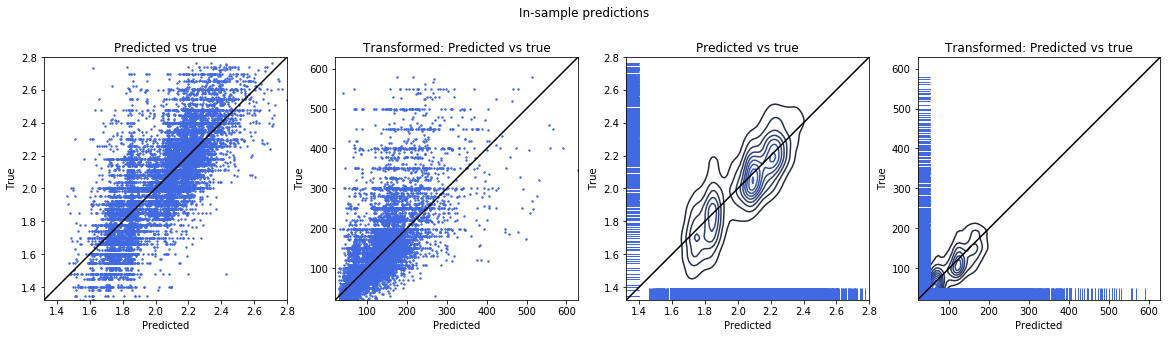

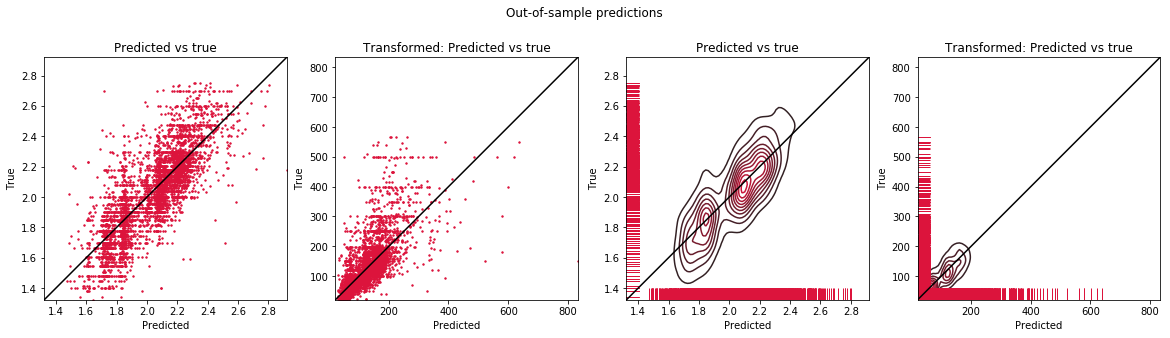

In [275]:
train_tpl = (X_train_base, y_train_base)
test_tpl = (X_test_base, y_test_base)
base = print_results('linear_regression_base.p', test_tpl, train_tpl, 'both', True)

In [276]:
df = pd.DataFrame(data={'Coefficient': list(base['fitted_model'].coef_)})
df.index = [c for c in list(train_base.columns) if c != 'Air_log_price']
df

Coefficient
Air_calculated_host_listings_count              -0.000134
Air_bathrooms                                    0.041846
Air_beds                                        -0.003577
Air_bedrooms                                     0.071544
Air_accommodates                                 0.017561
Air_extra_people                                 0.000388
Air_guests_included                              0.005790
Air_distance_to_CBD                             -0.003803
Air_property_type_2_House_Cottage_Villa          0.009814
Air_property_type_2_Other                        0.056793
Air_property_type_2_Townhouse                    0.026348
Air_room_type_Private room                      -0.230026
Air_room_type_Shared room                       -0.446868
Air_cancellation_policy_2_moderate              -0.011824
Air_cancellation_policy_2_strict                -0.001591
Air_neighbourhood_cleansed_Bayside               0.141323
Air_neighbourhood_cleansed_Boroondara            0.059092
Air_neighbourhood_cleansed_Brimbank             -0.098295
Air_neighbourhood_cleansed_Cardinia              0.300458
Air_neighbourhood_cleansed_Casey                 0.160543
Air_neighbourhood_cleansed_Darebin               0.000238
Air_neighbourhood_cleansed_Frankston             0.176420
Air_neighbourhood_cleansed_Glen Eira             0.051380
Air_neighbourhood_cleansed_Greater Dandenong     0.031131
Air_neighbourhood_cleansed_Hobsons Bay           0.076217
Air_neighbourhood_cleansed_Hume                  0.026582
Air_neighbourhood_cleansed_Kingston              0.112990
Air_neighbourhood_cleansed_Knox                  0.065799
Air_neighbourhood_cleansed_Manningham            0.131584
Air_neighbourhood_cleansed_Maribyrnong           0.000630
Air_neighbourhood_cleansed_Maroondah             0.045037
Air_neighbourhood_cleansed_Melbourne             0.104336
Air_neighbourhood_cleansed_Melton                0.038836
Air_neighbourhood_cleansed_Monash                0.035237
Air_neighbourhood_cleansed_Moonee Valley         0.013564
Air_neighbourhood_cleansed_Moreland              0.007581
Air_neighbourhood_cleansed_Nillumbik             0.201933
Air_neighbourhood_cleansed_Port Phillip          0.116139
Air_neighbourhood_cleansed_Stonnington           0.114096
Air_neighbourhood_cleansed_Whitehorse            0.037735
Air_neighbourhood_cleansed_Whittlesea           -0.011635
Air_neighbourhood_cleansed_Wyndham               0.043507
Air_neighbourhood_cleansed_Yarra                 0.099188
Air_neighbourhood_cleansed_Yarra Ranges          0.374218

To get a better overview over the relevance of the variables the model is also estimated with `statsmodels`. We see from the output that there might be an issue with muliticollinearity which can results in biased coefficients and uncorrect error estimations but this is not a huge problem in our case since we are mainly interested in predictions.

In [277]:
X, y = prepare_datasets(X_train_base, y_train_base)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = [c for c in train_base.columns if c != 'Air_log_price']
y.columns = ['Air_log_price']
X = sm.add_constant(X)
base_sm = sm.OLS(y, X).fit()
print(base_sm.summary())

                            OLS Regression Results                            
Dep. Variable:          Air_log_price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     499.3
Date:                Wed, 08 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:09:56   Log-Likelihood:                 5137.2
No. Observations:               14266   AIC:                        -1.018e+04
Df Residuals:                   14221   BIC:                            -9844.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

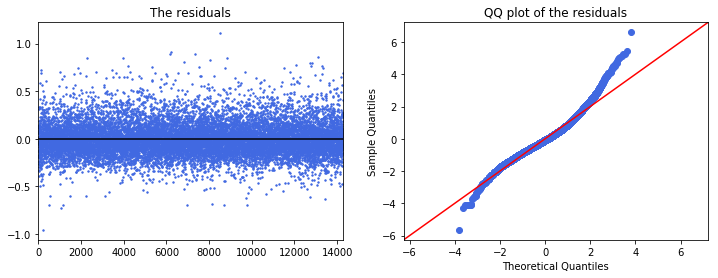

In [278]:
mean = np.mean(base_sm.resid)
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(x=range(base_sm.resid.shape[0]), y=base_sm.resid, alpha=1, s=2, color=col1)
ax[0].set_title("The residuals")
ax[0].axhline(mean, color='black')
ax[0].set_xlim(0, base_sm.resid.shape[0])
stdized = (base_sm.resid - np.mean(base_sm.resid)) / np.std(base_sm.resid)
sm.qqplot(stdized, line='45', color=col1, ax=ax[1])
ax[1].set_title("QQ plot of the residuals");

**1. Linear regression**

*Aggregation by suburbs*

For this model we add `Air_log_price_suburb_same_room_type` to the baseline model. **All subsequent model are built by the same logic.**

Untransformed
-------------
R2 train: 0.61 / RMSE train 0.17 / MAE train 0.13 / Nobs: 14261
R2 test: 0.63 / RMSE test 0.16 / MAE test 0.12 / Nobs: 4451

Transformed
-----------
R2 train: 0.48 / RMSE train 62.05 / MAE train 37.72 / Nobs: 14261
R2 test: 0.49 / RMSE test 61.13 / MAE test 36.77 / Nobs: 4451



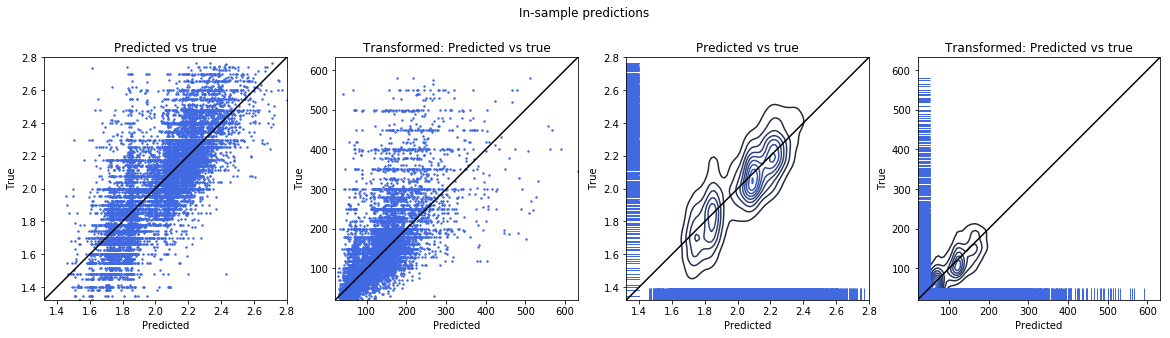

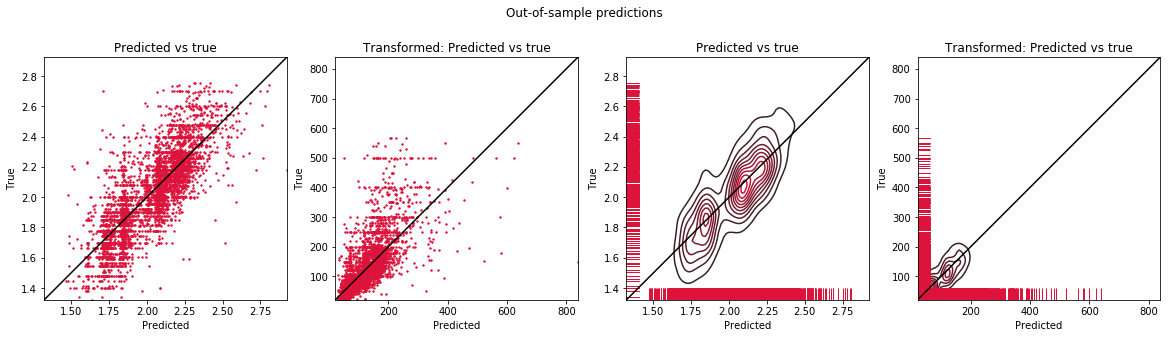

In [279]:
train_tpl = (X_train_suburb, y_train_suburb)
test_tpl = (X_test_suburb, y_test_suburb)
lin_reg_suburb = print_results('linear_regression_suburbs.p', test_tpl, train_tpl, 'both', True)

In [280]:
#lin_reg_suburb['fitted_model'].coef_
df = pd.DataFrame(data={'Coefficient': list(lin_reg_suburb['fitted_model'].coef_)})
df.index = [c for c in list(train_suburb.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_suburb_same_room_type             -0.013365
Air_calculated_host_listings_count              -0.000135
Air_bathrooms                                    0.041762
Air_beds                                        -0.003760
Air_bedrooms                                     0.071661
Air_accommodates                                 0.017751
Air_extra_people                                 0.000388
Air_guests_included                              0.005731
Air_distance_to_CBD                             -0.003750
Air_property_type_2_House_Cottage_Villa          0.009588
Air_property_type_2_Other                        0.057093
Air_property_type_2_Townhouse                    0.026035
Air_room_type_Private room                      -0.234121
Air_room_type_Shared room                       -0.458114
Air_cancellation_policy_2_moderate              -0.011808
Air_cancellation_policy_2_strict                -0.001561
Air_neighbourhood_cleansed_Bayside               0.143250
Air_neighbourhood_cleansed_Boroondara            0.059944
Air_neighbourhood_cleansed_Brimbank             -0.099664
Air_neighbourhood_cleansed_Cardinia              0.301515
Air_neighbourhood_cleansed_Casey                 0.160440
Air_neighbourhood_cleansed_Darebin               0.000272
Air_neighbourhood_cleansed_Frankston             0.176106
Air_neighbourhood_cleansed_Glen Eira             0.052091
Air_neighbourhood_cleansed_Greater Dandenong     0.027494
Air_neighbourhood_cleansed_Hobsons Bay           0.077344
Air_neighbourhood_cleansed_Hume                  0.021852
Air_neighbourhood_cleansed_Kingston              0.113596
Air_neighbourhood_cleansed_Knox                  0.065344
Air_neighbourhood_cleansed_Manningham            0.133033
Air_neighbourhood_cleansed_Maribyrnong           0.001088
Air_neighbourhood_cleansed_Maroondah             0.044621
Air_neighbourhood_cleansed_Melbourne             0.106228
Air_neighbourhood_cleansed_Melton                0.028847
Air_neighbourhood_cleansed_Monash                0.035380
Air_neighbourhood_cleansed_Moonee Valley         0.014088
Air_neighbourhood_cleansed_Moreland              0.007893
Air_neighbourhood_cleansed_Nillumbik             0.202807
Air_neighbourhood_cleansed_Port Phillip          0.117647
Air_neighbourhood_cleansed_Stonnington           0.115444
Air_neighbourhood_cleansed_Whitehorse            0.038098
Air_neighbourhood_cleansed_Whittlesea           -0.012152
Air_neighbourhood_cleansed_Wyndham               0.043612
Air_neighbourhood_cleansed_Yarra                 0.100790
Air_neighbourhood_cleansed_Yarra Ranges          0.376366

Again, we take a look at the results obtained from the `statsmodels` package. We see that the new variable `Air_log_price_suburb_same_room_type` is not significant. This is not surprising since all or at least a lot of information of this new variable is already covered by `Air_neighbourhood_cleansed` and `Air_room_type`.

<!--- However, `Air_room_type` is no longer significant and the coefficient of the intercept is smaller than in the baseline model. This is reasonable since most of the information of the intercept and of `Air_room_type` is now stored in `Air_log_price_suburb_same_room_type`. However, the new approach is different to the baseline by aggregating the log airbnb for the different suburbs w.r.t the different room types. This has a positive effect on the accuracy of the prediction. 
--->

`statsmodels` throws a again a warning that there might be a multicollinearity problem, which could lead to biased coefficient and error estimations. Therefore, coefficients and errors might be wrong and so the conclusion that the variable `Air_log_price_suburb_same_room_type` is not really relevant.

<!--- In the next cell, we solve this problem and one can see that coefficient of `Air_log_price_suburb_same_room_type` is only slightly affected. Thus, this new variable seems to be important.
--->

In [281]:
X, y = prepare_datasets(X_train_suburb, y_train_suburb)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = [c for c in train_suburb.columns if c != 'Air_log_price']
y.columns = ['Air_log_price']
X = sm.add_constant(X)
lin_reg_suburb_sm = sm.OLS(y, X).fit()
print(lin_reg_suburb_sm.summary())

                            OLS Regression Results                            
Dep. Variable:          Air_log_price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     488.8
Date:                Wed, 08 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:10:33   Log-Likelihood:                 5144.2
No. Observations:               14261   AIC:                        -1.020e+04
Df Residuals:                   14215   BIC:                            -9848.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

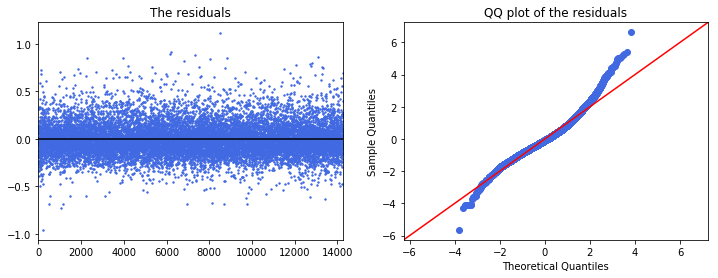

In [282]:
mean = np.mean(lin_reg_suburb_sm.resid)
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(x=range(lin_reg_suburb_sm.resid.shape[0]), y=lin_reg_suburb_sm.resid, alpha=1, s=2, color=col1)
ax[0].set_title("The residuals")
ax[0].axhline(mean, color='black')
ax[0].set_xlim(0, lin_reg_suburb_sm.resid.shape[0])
stdized = (lin_reg_suburb_sm.resid - np.mean(lin_reg_suburb_sm.resid)) / np.std(lin_reg_suburb_sm.resid)
sm.qqplot(stdized, line='45', color=col1, ax=ax[1])
ax[1].set_title("QQ plot of the residuals");

*Constructed aggregation - 500m*

Untransformed
-------------
R2 train: 0.63 / RMSE train 0.16 / MAE train 0.12 / Nobs: 13230
R2 test: 0.64 / RMSE test 0.16 / MAE test 0.12 / Nobs: 3739

Transformed
-----------
R2 train: 0.50 / RMSE train 60.72 / MAE train 36.82 / Nobs: 13230
R2 test: 0.51 / RMSE test 60.33 / MAE test 36.13 / Nobs: 3739



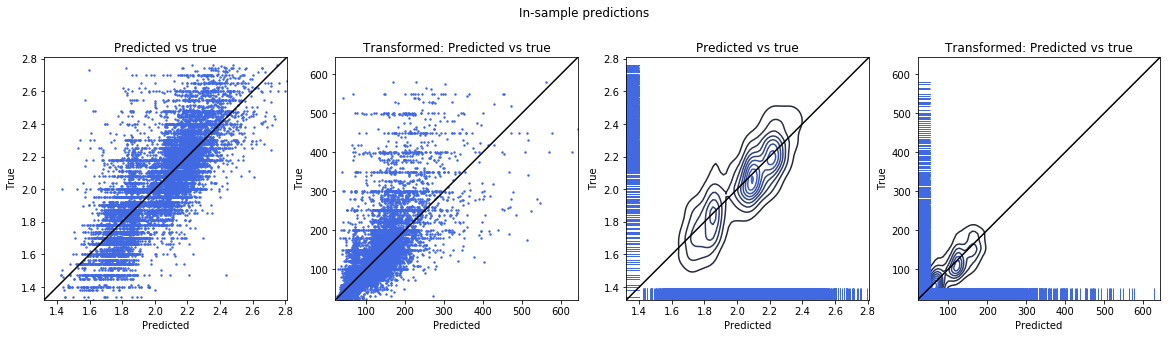

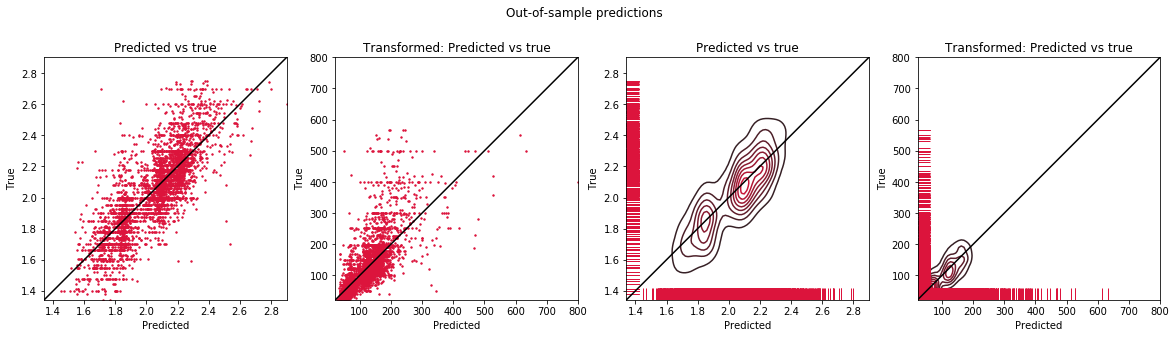

In [283]:
train_tpl = (X_train_500m, y_train_500m)
test_tpl = (X_test_500m, y_test_500m)
lin_reg_500m = print_results('linear_regression_500m.p', test_tpl, train_tpl, 'both', True)

In [284]:
df = pd.DataFrame(data={'Coefficient': list(lin_reg_500m['fitted_model'].coef_)})
df.index = [c for c in list(train_500m.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_500m_same_room_type                0.347770
Air_calculated_host_listings_count              -0.000149
Air_bathrooms                                    0.039777
Air_beds                                        -0.002011
Air_bedrooms                                     0.071294
Air_accommodates                                 0.015253
Air_extra_people                                 0.000321
Air_guests_included                              0.005978
Air_distance_to_CBD                             -0.004445
Air_property_type_2_House_Cottage_Villa          0.018695
Air_property_type_2_Other                        0.056990
Air_property_type_2_Townhouse                    0.030060
Air_room_type_Private room                      -0.122913
Air_room_type_Shared room                       -0.284465
Air_cancellation_policy_2_moderate              -0.010189
Air_cancellation_policy_2_strict                -0.001426
Air_neighbourhood_cleansed_Bayside               0.087620
Air_neighbourhood_cleansed_Boroondara            0.036906
Air_neighbourhood_cleansed_Brimbank             -0.092775
Air_neighbourhood_cleansed_Cardinia              0.277383
Air_neighbourhood_cleansed_Casey                 0.132914
Air_neighbourhood_cleansed_Darebin              -0.001023
Air_neighbourhood_cleansed_Frankston             0.161088
Air_neighbourhood_cleansed_Glen Eira             0.032780
Air_neighbourhood_cleansed_Greater Dandenong     0.009752
Air_neighbourhood_cleansed_Hobsons Bay           0.048552
Air_neighbourhood_cleansed_Hume                  0.013383
Air_neighbourhood_cleansed_Kingston              0.074522
Air_neighbourhood_cleansed_Knox                  0.057697
Air_neighbourhood_cleansed_Manningham            0.088799
Air_neighbourhood_cleansed_Maribyrnong          -0.016815
Air_neighbourhood_cleansed_Maroondah             0.008655
Air_neighbourhood_cleansed_Melbourne             0.061505
Air_neighbourhood_cleansed_Melton                0.034499
Air_neighbourhood_cleansed_Monash                0.025456
Air_neighbourhood_cleansed_Moonee Valley         0.001003
Air_neighbourhood_cleansed_Moreland             -0.000263
Air_neighbourhood_cleansed_Nillumbik             0.203555
Air_neighbourhood_cleansed_Port Phillip          0.075899
Air_neighbourhood_cleansed_Stonnington           0.078991
Air_neighbourhood_cleansed_Whitehorse            0.032836
Air_neighbourhood_cleansed_Whittlesea           -0.059420
Air_neighbourhood_cleansed_Wyndham               0.026441
Air_neighbourhood_cleansed_Yarra                 0.058081
Air_neighbourhood_cleansed_Yarra Ranges          0.305321

In contrast to `Air_log_price_suburb_same_room_type`, the variable `Air_log_price_500m_same_room_type` seems to add information to the model since it is highly signifcant. The sign of the coefficient is positive which perfectly fits to our expectation that airbnb prices are higher when neigbouring accommodations costs more and vice versa. `statsmodels` throws again a warning that there might be a multicollinearity problem.

In [285]:
X, y = prepare_datasets(X_train_500m, y_train_500m)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = [c for c in train_500m.columns if c != 'Air_log_price']
y.columns = ['Air_log_price']
X = sm.add_constant(X)
lin_reg_500m_sm = sm.OLS(y, X).fit()
print(lin_reg_500m_sm.summary())

                            OLS Regression Results                            
Dep. Variable:          Air_log_price   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     492.9
Date:                Wed, 08 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:11:04   Log-Likelihood:                 5286.5
No. Observations:               13230   AIC:                        -1.048e+04
Df Residuals:                   13184   BIC:                        -1.014e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

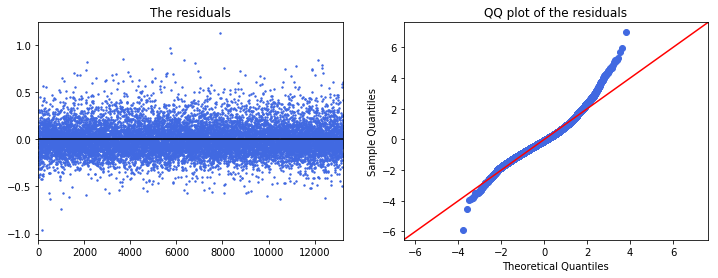

In [286]:
mean = np.mean(lin_reg_500m_sm.resid)
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(x=range(lin_reg_500m_sm.resid.shape[0]), y=lin_reg_500m_sm.resid, alpha=1, s=2, color=col1)
ax[0].set_title("The residuals")
ax[0].axhline(mean, color='black')
ax[0].set_xlim(0, lin_reg_500m_sm.resid.shape[0])
stdized = (lin_reg_500m_sm.resid - np.mean(lin_reg_500m_sm.resid)) / np.std(lin_reg_500m_sm.resid)
sm.qqplot(stdized, line='45', color=col1, ax=ax[1])
ax[1].set_title("QQ plot of the residuals");

*Constructed aggregation - 100m*

Untransformed
-------------
R2 train: 0.61 / RMSE train 0.15 / MAE train 0.11 / Nobs: 9203
R2 test: 0.62 / RMSE test 0.14 / MAE test 0.11 / Nobs: 2177

Transformed
-----------
R2 train: 0.49 / RMSE train 59.29 / MAE train 36.10 / Nobs: 9203
R2 test: 0.52 / RMSE test 53.67 / MAE test 34.18 / Nobs: 2177



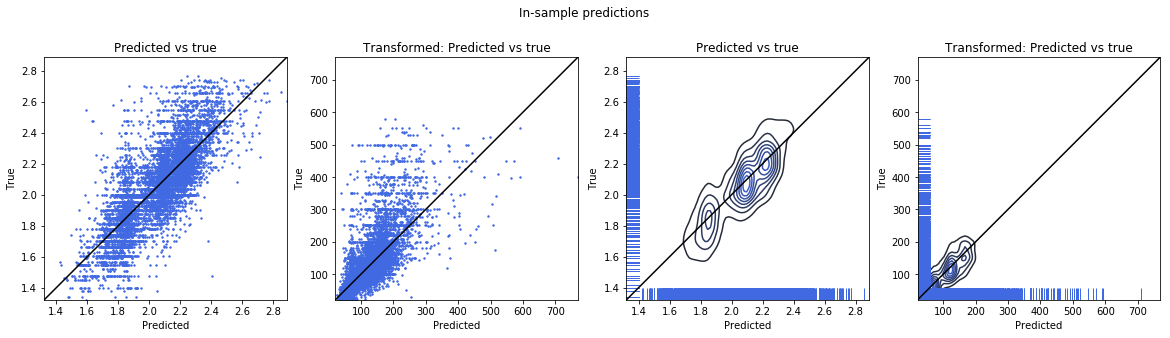

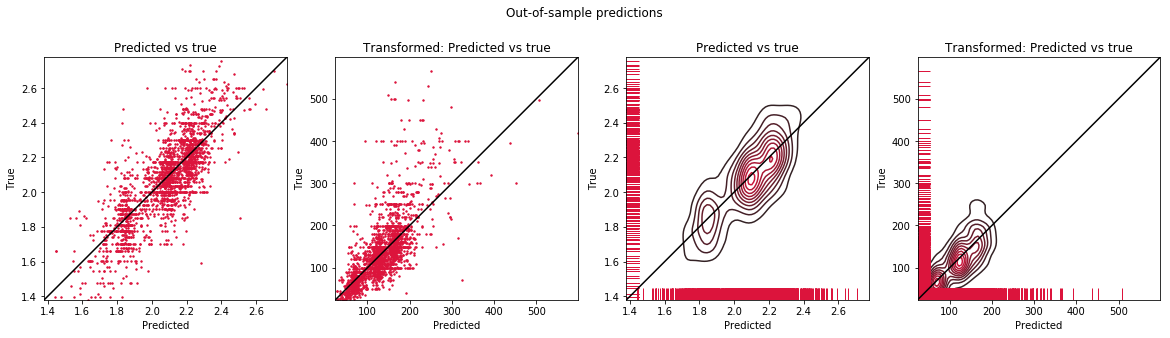

In [287]:
train_tpl = (X_train_100m, y_train_100m)
test_tpl = (X_test_100m, y_test_100m)
lin_reg_100m = print_results('linear_regression_100m.p', test_tpl, train_tpl, 'both', True)

In [288]:
lin_reg_100m['fitted_model'].coef_
df = pd.DataFrame(data={'Coefficient': list(lin_reg_100m['fitted_model'].coef_)})
df.index = [c for c in list(train_100m.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_100m_same_room_type                0.242209
Air_calculated_host_listings_count              -0.000218
Air_bathrooms                                    0.041013
Air_beds                                         0.003598
Air_bedrooms                                     0.082786
Air_accommodates                                 0.009494
Air_extra_people                                 0.000354
Air_guests_included                              0.004541
Air_distance_to_CBD                             -0.007401
Air_property_type_2_House_Cottage_Villa          0.007908
Air_property_type_2_Other                        0.062213
Air_property_type_2_Townhouse                    0.039469
Air_room_type_Private room                      -0.161677
Air_room_type_Shared room                       -0.356804
Air_cancellation_policy_2_moderate              -0.010899
Air_cancellation_policy_2_strict                -0.003543
Air_neighbourhood_cleansed_Bayside               0.140703
Air_neighbourhood_cleansed_Boroondara            0.044102
Air_neighbourhood_cleansed_Brimbank             -0.154986
Air_neighbourhood_cleansed_Cardinia              0.723493
Air_neighbourhood_cleansed_Casey                 0.283457
Air_neighbourhood_cleansed_Darebin              -0.012608
Air_neighbourhood_cleansed_Frankston             0.304439
Air_neighbourhood_cleansed_Glen Eira             0.024040
Air_neighbourhood_cleansed_Greater Dandenong    -0.002752
Air_neighbourhood_cleansed_Hobsons Bay           0.087591
Air_neighbourhood_cleansed_Hume                  0.012609
Air_neighbourhood_cleansed_Kingston              0.129312
Air_neighbourhood_cleansed_Knox                  0.050230
Air_neighbourhood_cleansed_Manningham            0.133170
Air_neighbourhood_cleansed_Maribyrnong          -0.010699
Air_neighbourhood_cleansed_Maroondah             0.046421
Air_neighbourhood_cleansed_Melbourne             0.047576
Air_neighbourhood_cleansed_Melton                0.123739
Air_neighbourhood_cleansed_Monash                0.078711
Air_neighbourhood_cleansed_Moonee Valley        -0.006536
Air_neighbourhood_cleansed_Moreland             -0.002589
Air_neighbourhood_cleansed_Nillumbik             0.270476
Air_neighbourhood_cleansed_Port Phillip          0.071446
Air_neighbourhood_cleansed_Stonnington           0.080052
Air_neighbourhood_cleansed_Whitehorse            0.059764
Air_neighbourhood_cleansed_Whittlesea           -0.174016
Air_neighbourhood_cleansed_Wyndham               0.108075
Air_neighbourhood_cleansed_Yarra                 0.051100
Air_neighbourhood_cleansed_Yarra Ranges          0.482897

In [289]:
X, y = prepare_datasets(X_train_100m, y_train_100m)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = [c for c in train_100m.columns if c != 'Air_log_price']
y.columns = ['Air_log_price']
X = sm.add_constant(X)
lin_reg_100m_sm = sm.OLS(y, X).fit()
print(lin_reg_100m_sm.summary())

                            OLS Regression Results                            
Dep. Variable:          Air_log_price   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     323.2
Date:                Wed, 08 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:11:29   Log-Likelihood:                 4186.1
No. Observations:                9203   AIC:                            -8280.
Df Residuals:                    9157   BIC:                            -7952.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

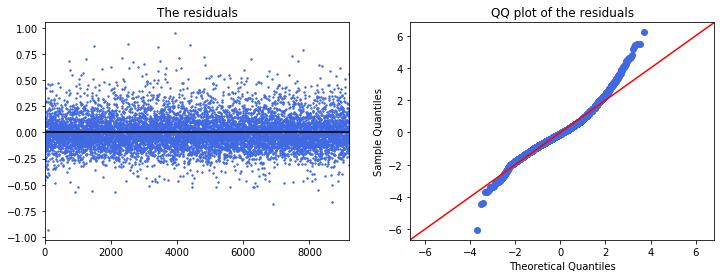

In [290]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(x=range(lin_reg_100m_sm.resid.shape[0]), y=lin_reg_100m_sm.resid, alpha=1, s=2, color=col1)
ax[0].set_title("The residuals")
ax[0].axhline(mean, color="black")
ax[0].set_xlim(0, lin_reg_100m_sm.resid.shape[0]) 
stdized = (lin_reg_100m_sm.resid - np.mean(lin_reg_100m_sm.resid)) / np.std(lin_reg_100m_sm.resid)
sm.qqplot(stdized, line='45', color=col1, ax=ax[1])
ax[1].set_title("QQ plot of the residuals");

*Constructed aggregation - 50m*

Untransformed
-------------
R2 train: 0.59 / RMSE train 0.15 / MAE train 0.11 / Nobs: 6522
R2 test: 0.62 / RMSE test 0.14 / MAE test 0.10 / Nobs: 1340

Transformed
-----------
R2 train: 0.47 / RMSE train 58.91 / MAE train 35.92 / Nobs: 6522
R2 test: 0.51 / RMSE test 50.96 / MAE test 32.90 / Nobs: 1340



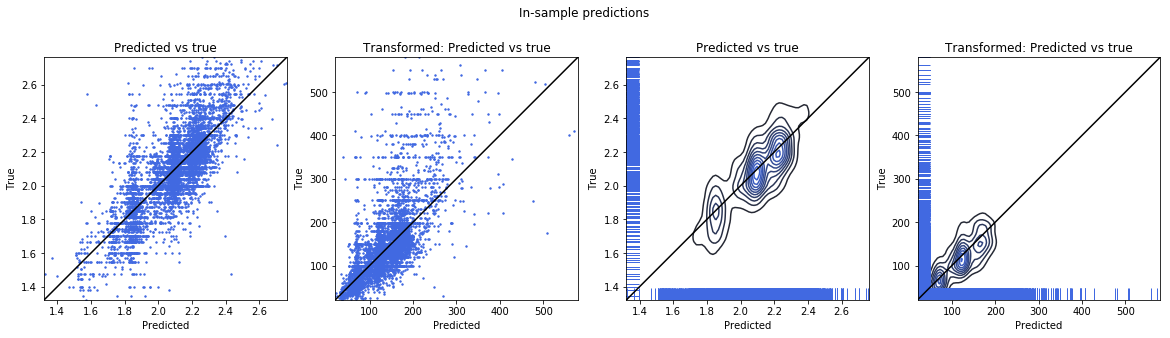

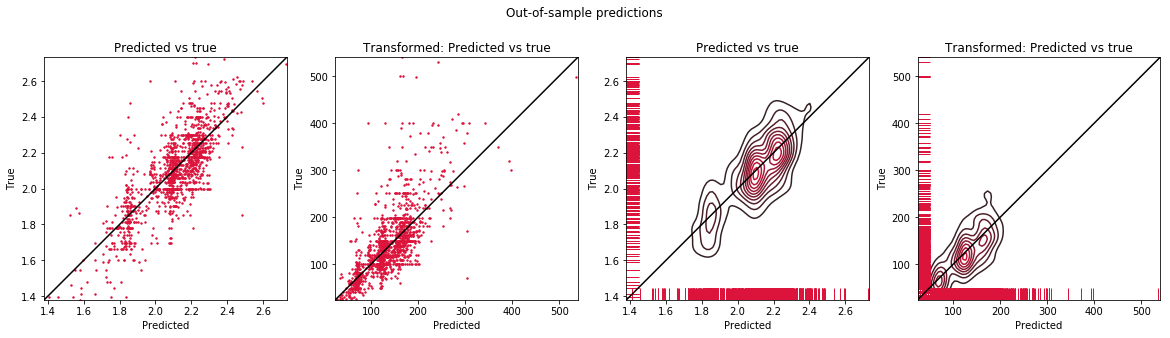

In [291]:
train_tpl = (X_train_50m, y_train_50m)
test_tpl = (X_test_50m, y_test_50m)
lin_reg_50m = print_results('linear_regression_50m.p', test_tpl, train_tpl, 'both', True)

In [292]:
lin_reg_50m['fitted_model'].coef_
df = pd.DataFrame(data={'Coefficient': list(lin_reg_50m['fitted_model'].coef_)})
df.index = [c for c in list(train_50m.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_50m_same_room_type                 0.129834
Air_calculated_host_listings_count              -0.000268
Air_bathrooms                                    0.043615
Air_beds                                         0.005969
Air_bedrooms                                     0.087004
Air_accommodates                                 0.005878
Air_extra_people                                 0.000401
Air_guests_included                              0.005479
Air_distance_to_CBD                             -0.009030
Air_property_type_2_House_Cottage_Villa          0.007927
Air_property_type_2_Other                        0.061034
Air_property_type_2_Townhouse                    0.027138
Air_room_type_Private room                      -0.198514
Air_room_type_Shared room                       -0.452481
Air_cancellation_policy_2_moderate              -0.008512
Air_cancellation_policy_2_strict                -0.003877
Air_neighbourhood_cleansed_Bayside               0.213254
Air_neighbourhood_cleansed_Boroondara            0.075421
Air_neighbourhood_cleansed_Brimbank             -0.414849
Air_neighbourhood_cleansed_Cardinia              0.847743
Air_neighbourhood_cleansed_Casey                 0.370584
Air_neighbourhood_cleansed_Darebin              -0.021580
Air_neighbourhood_cleansed_Frankston             0.347841
Air_neighbourhood_cleansed_Glen Eira             0.046973
Air_neighbourhood_cleansed_Greater Dandenong    -0.008011
Air_neighbourhood_cleansed_Hobsons Bay           0.078678
Air_neighbourhood_cleansed_Hume                  0.089573
Air_neighbourhood_cleansed_Kingston              0.208204
Air_neighbourhood_cleansed_Knox                  0.097118
Air_neighbourhood_cleansed_Manningham            0.171485
Air_neighbourhood_cleansed_Maribyrnong          -0.005917
Air_neighbourhood_cleansed_Maroondah            -0.019719
Air_neighbourhood_cleansed_Melbourne             0.049893
Air_neighbourhood_cleansed_Melton                0.256643
Air_neighbourhood_cleansed_Monash                0.100231
Air_neighbourhood_cleansed_Moonee Valley        -0.010473
Air_neighbourhood_cleansed_Moreland             -0.007279
Air_neighbourhood_cleansed_Nillumbik             0.389106
Air_neighbourhood_cleansed_Port Phillip          0.075027
Air_neighbourhood_cleansed_Stonnington           0.087347
Air_neighbourhood_cleansed_Whitehorse            0.067256
Air_neighbourhood_cleansed_Whittlesea           -0.251793
Air_neighbourhood_cleansed_Wyndham               0.086945
Air_neighbourhood_cleansed_Yarra                 0.056188
Air_neighbourhood_cleansed_Yarra Ranges          0.587192

In [293]:
X, y = prepare_datasets(X_train_50m, y_train_50m)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = [c for c in train_50m.columns if c != 'Air_log_price']
y.columns = ['Air_log_price']
X = sm.add_constant(X)
lin_reg_50m_sm = sm.OLS(y, X).fit()
print(lin_reg_50m_sm.summary())

                            OLS Regression Results                            
Dep. Variable:          Air_log_price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     209.9
Date:                Wed, 08 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:11:47   Log-Likelihood:                 3186.8
No. Observations:                6522   AIC:                            -6282.
Df Residuals:                    6476   BIC:                            -5970.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

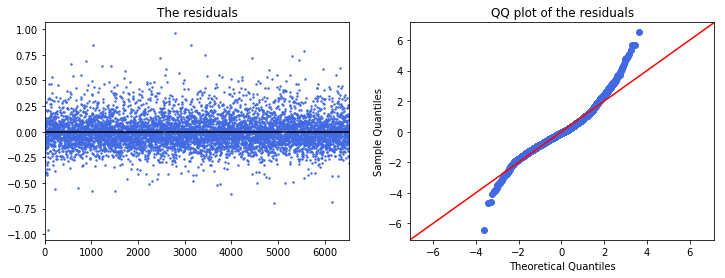

In [294]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
mean = np.mean(lin_reg_50m_sm.resid)
ax[0].scatter(x=range(lin_reg_50m_sm.resid.shape[0]), y=lin_reg_50m_sm.resid, alpha=1, s=2, color=col1)
ax[0].set_title("The residuals")
ax[0].axhline(mean, color="black")
ax[0].set_xlim(0, lin_reg_50m_sm.resid.shape[0])
stdized = (lin_reg_50m_sm.resid - np.mean(lin_reg_50m_sm.resid)) / np.std(lin_reg_50m_sm.resid)
sm.qqplot(stdized, line='45', color=col1, ax=ax[1])
ax[1].set_title("QQ plot of the residuals");

**2. Huber loss regression**

Huber regression has a regularization parameter $\alpha$ and a parameter $\epsilon$ that controls for the robustness. Since we use regularization the approach is usually to standardize the features to put equal weights on them (https://stats.stackexchange.com/questions/86434/is-standardisation-before-lasso-really-necessary). The data is therefore standardized before the estimation. A validation set is used to fine-tune the hyper-parameters.

*Aggregation by suburbs*

Untransformed
-------------
R2 train: 0.60 / RMSE train 0.17 / MAE train 0.13 / Nobs: 14261
R2 test: 0.62 / RMSE test 0.16 / MAE test 0.12 / Nobs: 4451

Transformed
-----------
R2 train: 0.47 / RMSE train 62.94 / MAE train 37.52 / Nobs: 14261
R2 test: 0.48 / RMSE test 61.85 / MAE test 36.66 / Nobs: 4451



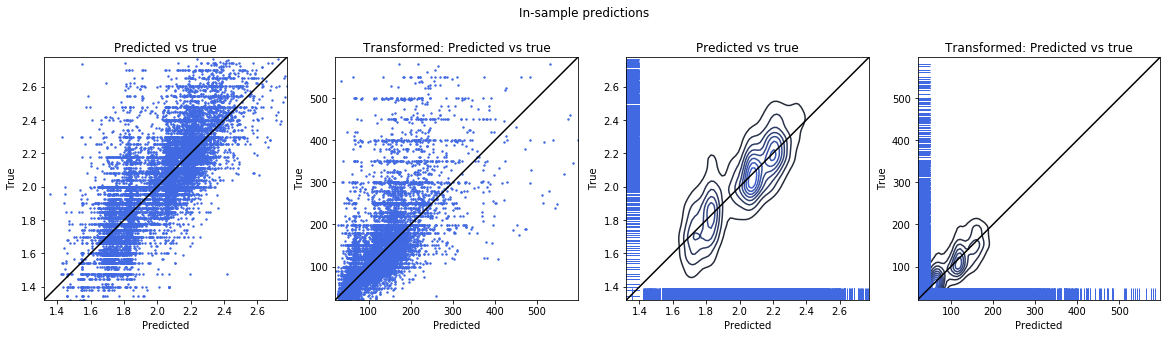

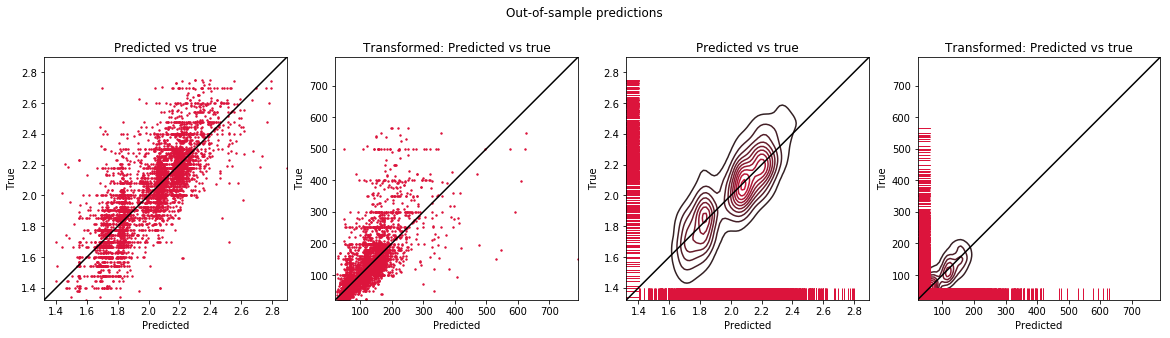

In [295]:
train_tpl = (X_train_suburb, y_train_suburb)
test_tpl = (X_test_suburb, y_test_suburb)
huber_suburb = print_results('Huber_regression_suburbs.p', test_tpl, train_tpl, 'both', True)

In [296]:
best_params = huber_suburb['fitted_model'].best_params_
best_params

{'huber__alpha': 0.0001, 'huber__epsilon': 1}

Next, we create a model with the best parameters and extract the model coefficients.

In [297]:
X_train, y_train = prepare_datasets(X_train_suburb, y_train_suburb)
regr = HuberRegressor(alpha=best_params['huber__alpha'], epsilon=best_params['huber__epsilon'])
model = Pipeline([('scaler', StandardScaler()), ('huber', regr)])
model.fit(X_train, y_train)
# https://stackoverflow.com/questions/28822756/getting-model-attributes-from-scikit-learn-pipeline/28837740
df = pd.DataFrame(data={'Coefficient': list(model.steps[1][1].coef_)})
df.index = [c for c in list(train_suburb.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_suburb_same_room_type              0.005027
Air_calculated_host_listings_count              -0.003200
Air_bathrooms                                    0.021617
Air_beds                                        -0.001166
Air_bedrooms                                     0.066234
Air_accommodates                                 0.035110
Air_extra_people                                 0.003516
Air_guests_included                              0.006639
Air_distance_to_CBD                             -0.048211
Air_property_type_2_House_Cottage_Villa          0.005307
Air_property_type_2_Other                        0.012169
Air_property_type_2_Townhouse                    0.006181
Air_room_type_Private room                      -0.106482
Air_room_type_Shared room                       -0.058846
Air_cancellation_policy_2_moderate              -0.000485
Air_cancellation_policy_2_strict                 0.000966
Air_neighbourhood_cleansed_Bayside               0.012736
Air_neighbourhood_cleansed_Boroondara            0.004994
Air_neighbourhood_cleansed_Brimbank             -0.009504
Air_neighbourhood_cleansed_Cardinia              0.018957
Air_neighbourhood_cleansed_Casey                 0.010797
Air_neighbourhood_cleansed_Darebin              -0.005623
Air_neighbourhood_cleansed_Frankston             0.014145
Air_neighbourhood_cleansed_Glen Eira             0.002677
Air_neighbourhood_cleansed_Greater Dandenong    -0.000535
Air_neighbourhood_cleansed_Hobsons Bay           0.003558
Air_neighbourhood_cleansed_Hume                 -0.000829
Air_neighbourhood_cleansed_Kingston              0.011889
Air_neighbourhood_cleansed_Knox                  0.005506
Air_neighbourhood_cleansed_Manningham            0.011386
Air_neighbourhood_cleansed_Maribyrnong          -0.004001
Air_neighbourhood_cleansed_Maroondah             0.001151
Air_neighbourhood_cleansed_Melbourne             0.032324
Air_neighbourhood_cleansed_Melton                0.002296
Air_neighbourhood_cleansed_Monash               -0.001127
Air_neighbourhood_cleansed_Moonee Valley        -0.001445
Air_neighbourhood_cleansed_Moreland             -0.003786
Air_neighbourhood_cleansed_Nillumbik             0.013810
Air_neighbourhood_cleansed_Port Phillip          0.025524
Air_neighbourhood_cleansed_Stonnington           0.019258
Air_neighbourhood_cleansed_Whitehorse            0.003386
Air_neighbourhood_cleansed_Whittlesea           -0.001533
Air_neighbourhood_cleansed_Wyndham              -0.000321
Air_neighbourhood_cleansed_Yarra                 0.018968
Air_neighbourhood_cleansed_Yarra Ranges          0.064632

`statsmodels`' Huber regression coefficients are **different** to `sklearn`'s. We also notice that there are no parameters like `alpha` and `epsilon`. 

In [298]:
X, y = prepare_datasets(X_train_suburb, y_train_suburb)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = [c for c in train_suburb.columns if c != 'Air_log_price']
y.columns = ['Air_log_price']
X = sm.add_constant(X)
huber_suburb_sm = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()
print(huber_suburb_sm.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:          Air_log_price   No. Observations:                14261
Model:                            RLM   Df Residuals:                    14215
Method:                          IRLS   Df Model:                           45
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 08 Jul 2020                                         
Time:                        19:12:29                                         
No. Iterations:                    24                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

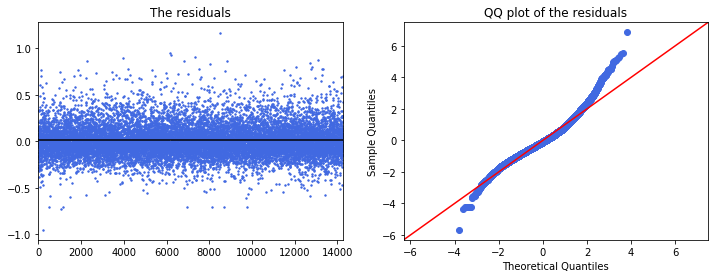

In [299]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
mean = np.mean(huber_suburb_sm.resid)
ax[0].scatter(x=range(huber_suburb_sm.resid.shape[0]), y=huber_suburb_sm.resid, alpha=1, s=2, color=col1)
ax[0].set_title("The residuals")
ax[0].axhline(mean, color="black")
ax[0].set_xlim(0, huber_suburb_sm.resid.shape[0])
stdized = (huber_suburb_sm.resid - np.mean(huber_suburb_sm.resid)) / np.std(huber_suburb_sm.resid)
sm.qqplot(stdized, line='45', color=col1, ax=ax[1])
ax[1].set_title("QQ plot of the residuals");

*Constructed aggregation - 500m*

Untransformed
-------------
R2 train: 0.62 / RMSE train 0.16 / MAE train 0.12 / Nobs: 13230
R2 test: 0.64 / RMSE test 0.16 / MAE test 0.12 / Nobs: 3739

Transformed
-----------
R2 train: 0.49 / RMSE train 61.46 / MAE train 36.65 / Nobs: 13230
R2 test: 0.50 / RMSE test 60.84 / MAE test 35.88 / Nobs: 3739



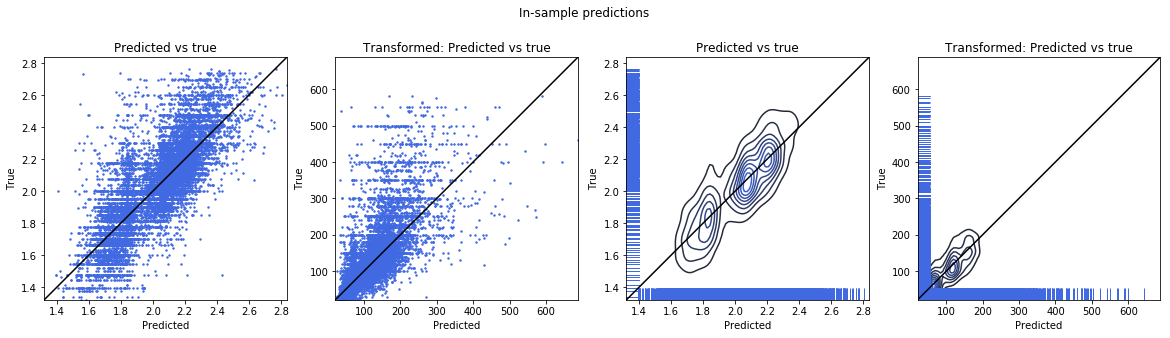

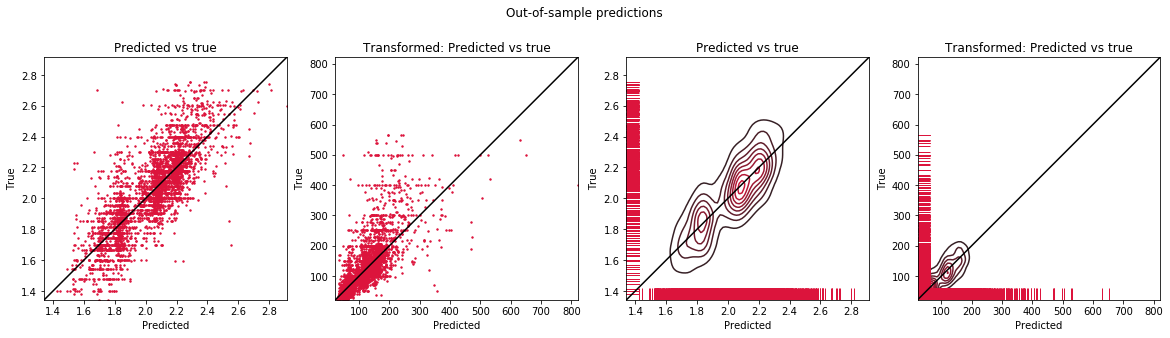

In [300]:
train_tpl = (X_train_500m, y_train_500m)
test_tpl = (X_test_500m, y_test_500m)
huber_500m = print_results('Huber_regression_500m.p', test_tpl, train_tpl, 'both', True)

In [301]:
best_params = huber_500m['fitted_model'].best_params_
best_params

{'huber__alpha': 0.001, 'huber__epsilon': 1}

Again, we extract the coefficients.

In [302]:
X_train, y_train = prepare_datasets(X_train_500m, y_train_500m)
regr = HuberRegressor(alpha=best_params['huber__alpha'], epsilon=best_params['huber__epsilon'])
model = Pipeline([('scaler', StandardScaler()), ('huber', regr)])
model.fit(X_train, y_train)
df = pd.DataFrame(data={'Coefficient': list(model.steps[1][1].coef_)})
df.index = [c for c in list(train_500m.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_500m_same_room_type                0.071056
Air_calculated_host_listings_count              -0.003406
Air_bathrooms                                    0.020964
Air_beds                                        -0.000405
Air_bedrooms                                     0.065059
Air_accommodates                                 0.029266
Air_extra_people                                 0.003906
Air_guests_included                              0.006065
Air_distance_to_CBD                             -0.051336
Air_property_type_2_House_Cottage_Villa          0.009909
Air_property_type_2_Other                        0.012205
Air_property_type_2_Townhouse                    0.007469
Air_room_type_Private room                      -0.061041
Air_room_type_Shared room                       -0.034946
Air_cancellation_policy_2_moderate              -0.001037
Air_cancellation_policy_2_strict                 0.001429
Air_neighbourhood_cleansed_Bayside               0.006062
Air_neighbourhood_cleansed_Boroondara            0.000436
Air_neighbourhood_cleansed_Brimbank             -0.007623
Air_neighbourhood_cleansed_Cardinia              0.012253
Air_neighbourhood_cleansed_Casey                 0.005718
Air_neighbourhood_cleansed_Darebin              -0.006706
Air_neighbourhood_cleansed_Frankston             0.012828
Air_neighbourhood_cleansed_Glen Eira            -0.001150
Air_neighbourhood_cleansed_Greater Dandenong    -0.000804
Air_neighbourhood_cleansed_Hobsons Bay          -0.000152
Air_neighbourhood_cleansed_Hume                 -0.000173
Air_neighbourhood_cleansed_Kingston              0.007011
Air_neighbourhood_cleansed_Knox                  0.003241
Air_neighbourhood_cleansed_Manningham            0.006078
Air_neighbourhood_cleansed_Maribyrnong          -0.008356
Air_neighbourhood_cleansed_Maroondah            -0.002253
Air_neighbourhood_cleansed_Melbourne             0.007058
Air_neighbourhood_cleansed_Melton                0.001396
Air_neighbourhood_cleansed_Monash               -0.003091
Air_neighbourhood_cleansed_Moonee Valley        -0.003208
Air_neighbourhood_cleansed_Moreland             -0.009381
Air_neighbourhood_cleansed_Nillumbik             0.005921
Air_neighbourhood_cleansed_Port Phillip          0.009673
Air_neighbourhood_cleansed_Stonnington           0.008261
Air_neighbourhood_cleansed_Whitehorse            0.001307
Air_neighbourhood_cleansed_Whittlesea           -0.002592
Air_neighbourhood_cleansed_Wyndham              -0.002058
Air_neighbourhood_cleansed_Yarra                 0.004933
Air_neighbourhood_cleansed_Yarra Ranges          0.047023

A comparison with `statsmodels`'s values is is shown below. **The values differ from the ones from sklearn.**

In [303]:
X, y = prepare_datasets(X_train_500m, y_train_500m)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = [c for c in train_500m.columns if c != 'Air_log_price']
y.columns = ['Air_log_price']
X = sm.add_constant(X)
huber_500m_sm = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()
print(huber_500m_sm.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:          Air_log_price   No. Observations:                13230
Model:                            RLM   Df Residuals:                    13184
Method:                          IRLS   Df Model:                           45
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 08 Jul 2020                                         
Time:                        19:13:27                                         
No. Iterations:                    25                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

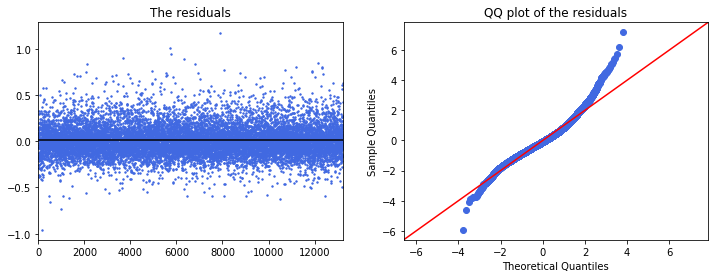

In [304]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
mean = np.mean(huber_500m_sm.resid)
ax[0].scatter(x=range(huber_500m_sm.resid.shape[0]), y=huber_500m_sm.resid, alpha=1, s=2, color=col1)
ax[0].set_title("The residuals")
ax[0].axhline(mean, color="black")
ax[0].set_xlim(0, huber_500m_sm.resid.shape[0])
stdized = (huber_500m_sm.resid - np.mean(huber_500m_sm.resid)) / np.std(huber_500m_sm.resid)
sm.qqplot(stdized, line='45', color=col1, ax=ax[1])
ax[1].set_title("QQ plot of the residuals");

*Constructed aggregation - 100m*

Untransformed
-------------
R2 train: 0.61 / RMSE train 0.15 / MAE train 0.11 / Nobs: 9203
R2 test: 0.62 / RMSE test 0.14 / MAE test 0.11 / Nobs: 2177

Transformed
-----------
R2 train: 0.48 / RMSE train 60.00 / MAE train 35.94 / Nobs: 9203
R2 test: 0.51 / RMSE test 54.12 / MAE test 34.01 / Nobs: 2177



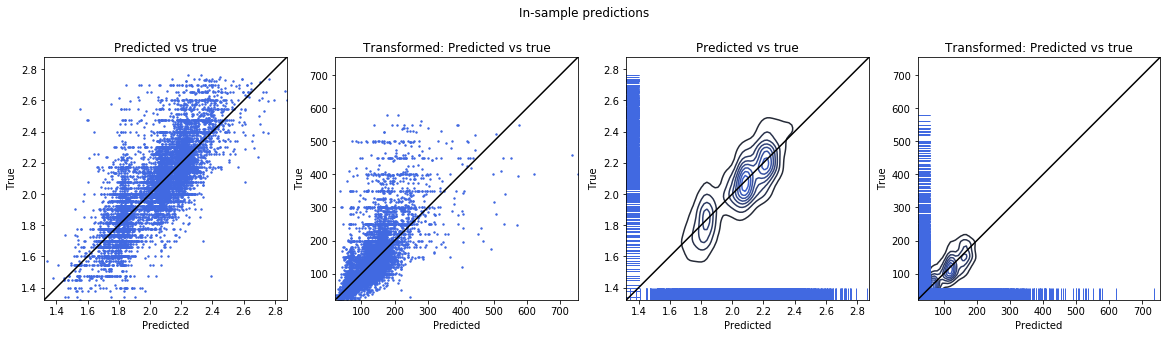

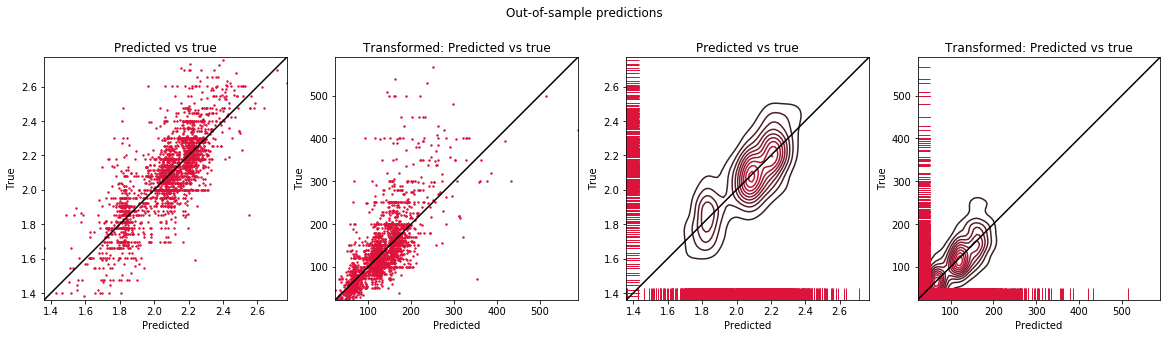

In [305]:
train_tpl = (X_train_100m, y_train_100m)
test_tpl = (X_test_100m, y_test_100m)
huber_100m = print_results('Huber_regression_100m.p', test_tpl, train_tpl, 'both', True)

In [306]:
best_params = huber_100m['fitted_model'].best_params_
best_params

{'huber__alpha': 0.0001, 'huber__epsilon': 1}

In [307]:
X_train, y_train = prepare_datasets(X_train_100m, y_train_100m)
regr = HuberRegressor(alpha=best_params['huber__alpha'], epsilon=best_params['huber__epsilon'])
model = Pipeline([('scaler', StandardScaler()), ('huber', regr)])
model.fit(X_train, y_train)
# https://stackoverflow.com/questions/28822756/getting-model-attributes-from-scikit-learn-pipeline/28837740
model.steps[1][1].coef_
df = pd.DataFrame(data={'Coefficient': list(model.steps[1][1].coef_)})
df.index = [c for c in list(train_100m.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_100m_same_room_type                0.050610
Air_calculated_host_listings_count              -0.004550
Air_bathrooms                                    0.021518
Air_beds                                         0.004303
Air_bedrooms                                     0.063628
Air_accommodates                                 0.020474
Air_extra_people                                 0.002806
Air_guests_included                              0.005354
Air_distance_to_CBD                             -0.053251
Air_property_type_2_House_Cottage_Villa          0.004976
Air_property_type_2_Other                        0.013182
Air_property_type_2_Townhouse                    0.006812
Air_room_type_Private room                      -0.075709
Air_room_type_Shared room                       -0.036624
Air_cancellation_policy_2_moderate              -0.000996
Air_cancellation_policy_2_strict                 0.000949
Air_neighbourhood_cleansed_Bayside               0.007292
Air_neighbourhood_cleansed_Boroondara            0.002366
Air_neighbourhood_cleansed_Brimbank             -0.006792
Air_neighbourhood_cleansed_Cardinia              0.013816
Air_neighbourhood_cleansed_Casey                 0.008637
Air_neighbourhood_cleansed_Darebin              -0.006208
Air_neighbourhood_cleansed_Frankston             0.013569
Air_neighbourhood_cleansed_Glen Eira            -0.002056
Air_neighbourhood_cleansed_Greater Dandenong    -0.000239
Air_neighbourhood_cleansed_Hobsons Bay           0.001423
Air_neighbourhood_cleansed_Hume                 -0.000982
Air_neighbourhood_cleansed_Kingston              0.006125
Air_neighbourhood_cleansed_Knox                  0.001255
Air_neighbourhood_cleansed_Manningham            0.005943
Air_neighbourhood_cleansed_Maribyrnong          -0.005225
Air_neighbourhood_cleansed_Maroondah             0.001721
Air_neighbourhood_cleansed_Melbourne            -0.002589
Air_neighbourhood_cleansed_Melton                0.003033
Air_neighbourhood_cleansed_Monash                0.002945
Air_neighbourhood_cleansed_Moonee Valley        -0.004181
Air_neighbourhood_cleansed_Moreland             -0.008693
Air_neighbourhood_cleansed_Nillumbik             0.005769
Air_neighbourhood_cleansed_Port Phillip          0.007700
Air_neighbourhood_cleansed_Stonnington           0.007142
Air_neighbourhood_cleansed_Whitehorse            0.004500
Air_neighbourhood_cleansed_Whittlesea           -0.009405
Air_neighbourhood_cleansed_Wyndham               0.006157
Air_neighbourhood_cleansed_Yarra                -0.000634
Air_neighbourhood_cleansed_Yarra Ranges          0.045968

A comparison with `statsmodels`'s values is is shown below. **The values differ from the ones from sklearn.**

In [308]:
X, y = prepare_datasets(X_train_100m, y_train_100m)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = [c for c in train_100m.columns if c != 'Air_log_price']
y.columns = ['Air_log_price']
X = sm.add_constant(X)
huber_100m_sm = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()
print(huber_100m_sm.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:          Air_log_price   No. Observations:                 9203
Model:                            RLM   Df Residuals:                     9157
Method:                          IRLS   Df Model:                           45
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 08 Jul 2020                                         
Time:                        19:14:04                                         
No. Iterations:                    22                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

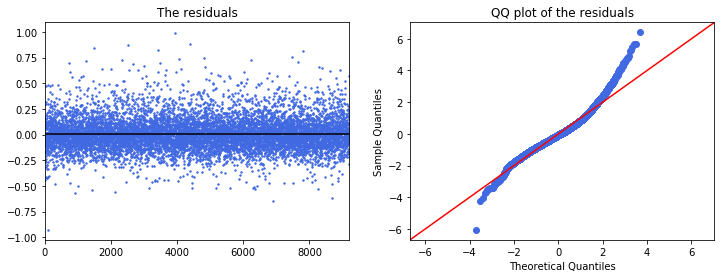

In [309]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
mean = np.mean(huber_100m_sm.resid)
ax[0].scatter(x=range(huber_100m_sm.resid.shape[0]), y=huber_100m_sm.resid, alpha=1, s=2, color=col1)
ax[0].set_title("The residuals")
ax[0].axhline(mean, color="black")
ax[0].set_xlim(0, huber_100m_sm.resid.shape[0])
stdized = (huber_100m_sm.resid - np.mean(huber_100m_sm.resid)) / np.std(huber_100m_sm.resid)
sm.qqplot(stdized, line='45', color=col1, ax=ax[1])
ax[1].set_title("QQ plot of the residuals");

*Constructed aggregation - 50m*

Untransformed
-------------
R2 train: 0.59 / RMSE train 0.15 / MAE train 0.11 / Nobs: 6522
R2 test: 0.62 / RMSE test 0.14 / MAE test 0.10 / Nobs: 1340

Transformed
-----------
R2 train: 0.45 / RMSE train 59.75 / MAE train 35.71 / Nobs: 6522
R2 test: 0.50 / RMSE test 51.53 / MAE test 32.66 / Nobs: 1340



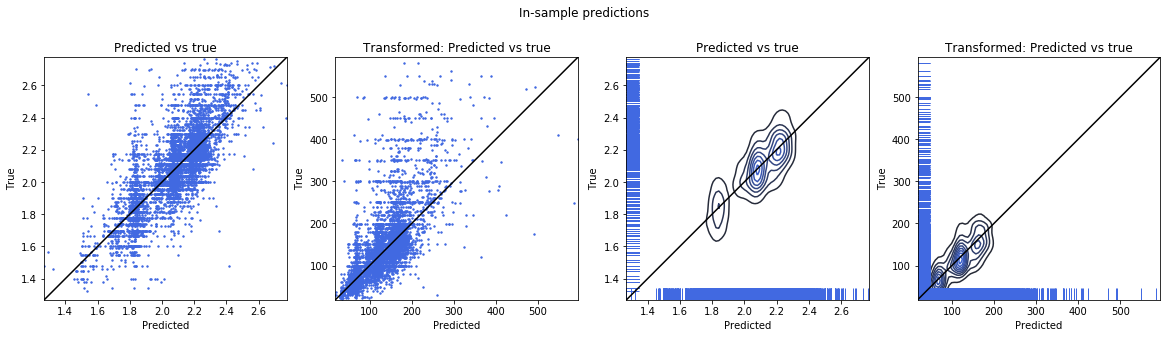

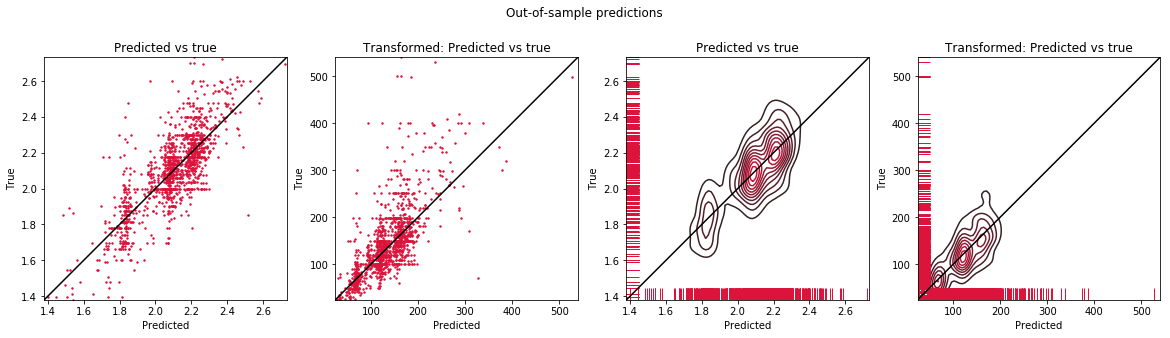

In [310]:
train_tpl = (X_train_50m, y_train_50m)
test_tpl = (X_test_50m, y_test_50m)
huber_50m = print_results('Huber_regression_50m.p', test_tpl, train_tpl, 'both', True)

In [311]:
best_params = huber_50m['fitted_model'].best_params_
best_params

{'huber__alpha': 1.0, 'huber__epsilon': 1}

In [312]:
X_train, y_train = prepare_datasets(X_train_50m, y_train_50m)
regr = HuberRegressor(alpha=best_params['huber__alpha'], epsilon=best_params['huber__epsilon'])
model = Pipeline([('scaler', StandardScaler()), ('huber', regr)])
model.fit(X_train, y_train)
# https://stackoverflow.com/questions/28822756/getting-model-attributes-from-scikit-learn-pipeline/28837740
model.steps[1][1].coef_
df = pd.DataFrame(data={'Coefficient': list(model.steps[1][1].coef_)})
df.index = [c for c in list(train_50m.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_50m_same_room_type                 0.025290
Air_calculated_host_listings_count              -0.004081
Air_bathrooms                                    0.024187
Air_beds                                         0.007393
Air_bedrooms                                     0.064319
Air_accommodates                                 0.015954
Air_extra_people                                 0.003901
Air_guests_included                              0.005371
Air_distance_to_CBD                             -0.043499
Air_property_type_2_House_Cottage_Villa          0.000837
Air_property_type_2_Other                        0.012625
Air_property_type_2_Townhouse                    0.001167
Air_room_type_Private room                      -0.083752
Air_room_type_Shared room                       -0.045682
Air_cancellation_policy_2_moderate              -0.003181
Air_cancellation_policy_2_strict                -0.001325
Air_neighbourhood_cleansed_Bayside               0.006913
Air_neighbourhood_cleansed_Boroondara            0.003147
Air_neighbourhood_cleansed_Brimbank             -0.008957
Air_neighbourhood_cleansed_Cardinia              0.014549
Air_neighbourhood_cleansed_Casey                 0.004284
Air_neighbourhood_cleansed_Darebin              -0.004528
Air_neighbourhood_cleansed_Frankston             0.010850
Air_neighbourhood_cleansed_Glen Eira            -0.002294
Air_neighbourhood_cleansed_Greater Dandenong    -0.000992
Air_neighbourhood_cleansed_Hobsons Bay          -0.000085
Air_neighbourhood_cleansed_Hume                 -0.002729
Air_neighbourhood_cleansed_Kingston              0.006069
Air_neighbourhood_cleansed_Knox                  0.002960
Air_neighbourhood_cleansed_Manningham            0.005332
Air_neighbourhood_cleansed_Maribyrnong          -0.004092
Air_neighbourhood_cleansed_Maroondah             0.000068
Air_neighbourhood_cleansed_Melbourne            -0.002213
Air_neighbourhood_cleansed_Melton                0.006401
Air_neighbourhood_cleansed_Monash               -0.000451
Air_neighbourhood_cleansed_Moonee Valley        -0.005892
Air_neighbourhood_cleansed_Moreland             -0.007466
Air_neighbourhood_cleansed_Nillumbik             0.006021
Air_neighbourhood_cleansed_Port Phillip          0.007515
Air_neighbourhood_cleansed_Stonnington           0.007973
Air_neighbourhood_cleansed_Whitehorse            0.003255
Air_neighbourhood_cleansed_Whittlesea           -0.010350
Air_neighbourhood_cleansed_Wyndham               0.001174
Air_neighbourhood_cleansed_Yarra                 0.001846
Air_neighbourhood_cleansed_Yarra Ranges          0.036071

A comparison with `statsmodels`'s values is is shown below. **The values differ from the ones from sklearn.**

In [313]:
X, y = prepare_datasets(X_train_50m, y_train_50m)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = [c for c in train_50m.columns if c != 'Air_log_price']
y.columns = ['Air_log_price']
X = sm.add_constant(X)
huber_50m_sm = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()
print(huber_50m_sm.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:          Air_log_price   No. Observations:                 6522
Model:                            RLM   Df Residuals:                     6476
Method:                          IRLS   Df Model:                           45
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 08 Jul 2020                                         
Time:                        19:14:27                                         
No. Iterations:                    31                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

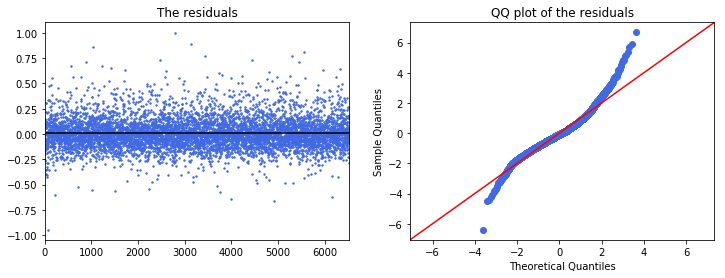

In [314]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
mean = np.mean(huber_50m_sm.resid)
ax[0].scatter(x=range(huber_50m_sm.resid.shape[0]), y=huber_50m_sm.resid, alpha=1, s=2, color=col1)
ax[0].set_title("The residuals")
ax[0].axhline(mean, color="black")
ax[0].set_xlim(0, huber_50m_sm.resid.shape[0])
stdized = (huber_50m_sm.resid - np.mean(huber_50m_sm.resid)) / np.std(huber_50m_sm.resid)
sm.qqplot(stdized, line='45', color=col1, ax=ax[1])
ax[1].set_title("QQ plot of the residuals");

**3. Lasso and Ridge regression**

As the Huber model, Ridge and Lasso have a regularization parameter $\alpha$. We therefore standardize the features and use a validation set to fine-tune the hyperparameter as in the Huber regression case.

*Aggregation by suburbs*

Lasso

Untransformed
-------------
R2 train: 0.61 / RMSE train 0.17 / MAE train 0.13 / Nobs: 14261
R2 test: 0.63 / RMSE test 0.16 / MAE test 0.12 / Nobs: 4451

Transformed
-----------
R2 train: 0.48 / RMSE train 62.20 / MAE train 37.77 / Nobs: 14261
R2 test: 0.49 / RMSE test 61.00 / MAE test 36.76 / Nobs: 4451



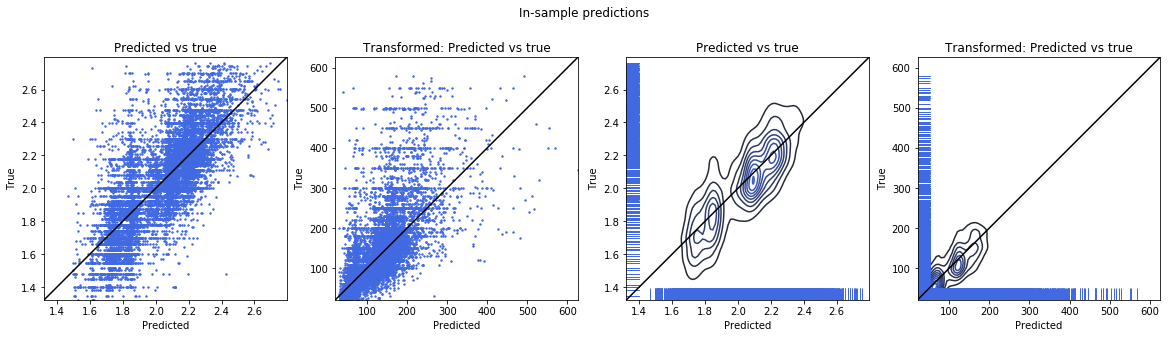

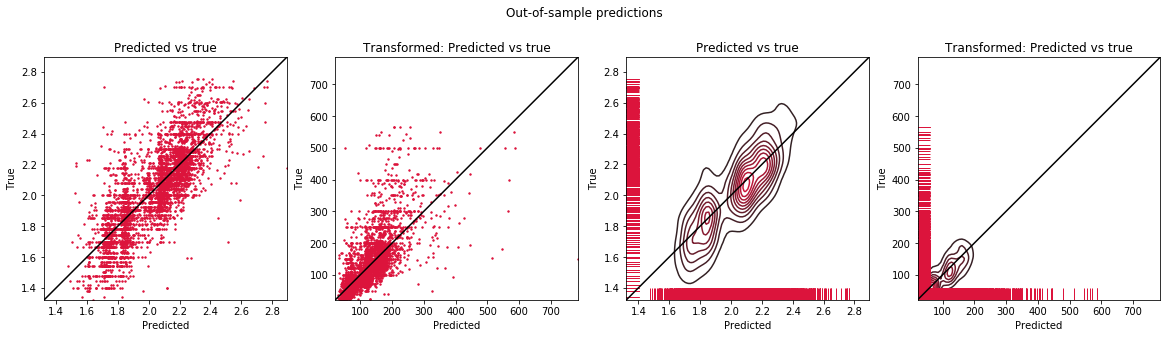

In [315]:
train_tpl = (X_train_suburb, y_train_suburb)
test_tpl = (X_test_suburb, y_test_suburb)
lasso_suburb = print_results('Lasso_suburbs.p', test_tpl, train_tpl, 'both', True)

In [316]:
best_params = lasso_suburb['fitted_model'].best_params_
best_params

{'lasso__alpha': 0.0001}

In [317]:
X_train, y_train = prepare_datasets(X_train_suburb, y_train_suburb)
regr = linear_model.Lasso(alpha=best_params['lasso__alpha'])
model = Pipeline([('scaler', StandardScaler()), ('lasso', regr)])
model.fit(X_train, y_train)
df = pd.DataFrame(data={'Coefficient': list(model.steps[1][1].coef_)})
df.index = [c for c in list(train_suburb.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_suburb_same_room_type              0.006579
Air_calculated_host_listings_count              -0.001897
Air_bathrooms                                    0.021886
Air_beds                                        -0.004917
Air_bedrooms                                     0.062399
Air_accommodates                                 0.037406
Air_extra_people                                 0.008077
Air_guests_included                              0.007515
Air_distance_to_CBD                             -0.038005
Air_property_type_2_House_Cottage_Villa          0.003841
Air_property_type_2_Other                        0.015470
Air_property_type_2_Townhouse                    0.006118
Air_room_type_Private room                      -0.104485
Air_room_type_Shared room                       -0.051964
Air_cancellation_policy_2_moderate              -0.004863
Air_cancellation_policy_2_strict                -0.000356
Air_neighbourhood_cleansed_Bayside               0.013811
Air_neighbourhood_cleansed_Boroondara            0.005357
Air_neighbourhood_cleansed_Brimbank             -0.008170
Air_neighbourhood_cleansed_Cardinia              0.017889
Air_neighbourhood_cleansed_Casey                 0.009007
Air_neighbourhood_cleansed_Darebin              -0.003889
Air_neighbourhood_cleansed_Frankston             0.012472
Air_neighbourhood_cleansed_Glen Eira             0.004031
Air_neighbourhood_cleansed_Greater Dandenong    -0.000000
Air_neighbourhood_cleansed_Hobsons Bay           0.004870
Air_neighbourhood_cleansed_Hume                 -0.000536
Air_neighbourhood_cleansed_Kingston              0.009564
Air_neighbourhood_cleansed_Knox                  0.003003
Air_neighbourhood_cleansed_Manningham            0.011468
Air_neighbourhood_cleansed_Maribyrnong          -0.003168
Air_neighbourhood_cleansed_Maroondah             0.000999
Air_neighbourhood_cleansed_Melbourne             0.036587
Air_neighbourhood_cleansed_Melton                0.000000
Air_neighbourhood_cleansed_Monash                0.001004
Air_neighbourhood_cleansed_Moonee Valley        -0.001127
Air_neighbourhood_cleansed_Moreland             -0.003113
Air_neighbourhood_cleansed_Nillumbik             0.010469
Air_neighbourhood_cleansed_Port Phillip          0.029385
Air_neighbourhood_cleansed_Stonnington           0.022408
Air_neighbourhood_cleansed_Whitehorse            0.001635
Air_neighbourhood_cleansed_Whittlesea           -0.002956
Air_neighbourhood_cleansed_Wyndham               0.001672
Air_neighbourhood_cleansed_Yarra                 0.020911
Air_neighbourhood_cleansed_Yarra Ranges          0.057402

We also take a look at the output of `statsmodels`. Currently no standard errors and p-values are returned (work in progress, https://github.com/statsmodels/statsmodels/issues/3670). The estimated coefficients are different to the `sklearn` implementation.

In [318]:
X, y = prepare_datasets(X_train_suburb, y_train_suburb)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = [c for c in train_suburb.columns if c != 'Air_log_price']
y.columns = ['Air_log_price']
X = sm.add_constant(X)
lasso_suburb_sm = sm.OLS(y,X).fit_regularized(alpha=best_params['lasso__alpha'])
print(lasso_suburb_sm.summary())

None


In [319]:
print(lasso_suburb_sm.params)

const                                           2.033149
Air_log_price_suburb_same_room_type             0.073589
Air_calculated_host_listings_count              0.000000
Air_bathrooms                                   0.021687
Air_beds                                       -0.005619
Air_bedrooms                                    0.061326
Air_accommodates                                0.037889
Air_extra_people                                0.008477
Air_guests_included                             0.007419
Air_distance_to_CBD                            -0.037609
Air_property_type_2_House_Cottage_Villa         0.003771
Air_property_type_2_Other                       0.014951
Air_property_type_2_Townhouse                   0.006146
Air_room_type_Private room                     -0.047096
Air_room_type_Shared room                      -0.027687
Air_cancellation_policy_2_moderate             -0.004658
Air_cancellation_policy_2_strict                0.000000
Air_neighbourhood_cleansed_Bays

The `resid` attribute seems to be also missing for the `RegularizedResults` object. Hence, the code below is not working to extract and plot the residuals (https://github.com/statsmodels/statsmodels/issues/3835).

Ridge

Untransformed
-------------
R2 train: 0.61 / RMSE train 0.17 / MAE train 0.13 / Nobs: 14261
R2 test: 0.63 / RMSE test 0.16 / MAE test 0.12 / Nobs: 4451

Transformed
-----------
R2 train: 0.48 / RMSE train 62.17 / MAE train 37.76 / Nobs: 14261
R2 test: 0.49 / RMSE test 60.92 / MAE test 36.74 / Nobs: 4451



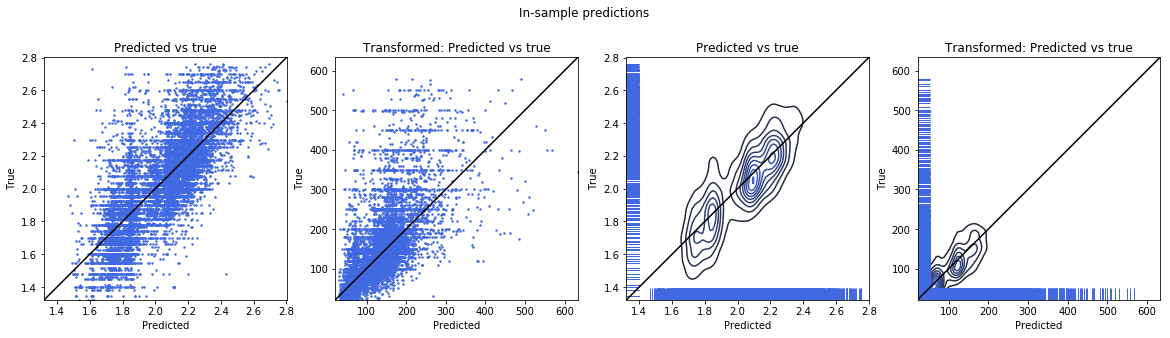

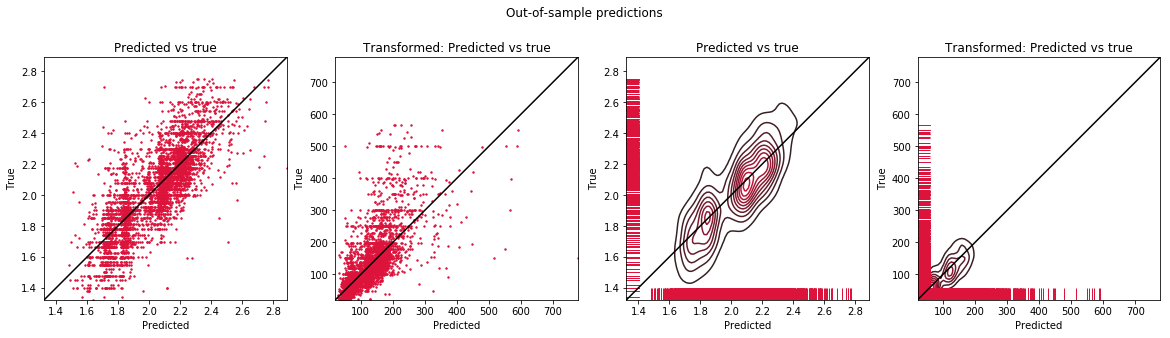

In [320]:
train_tpl = (X_train_suburb, y_train_suburb)
test_tpl = (X_test_suburb, y_test_suburb)
ridge_suburb = print_results('Ridge_suburbs.p', test_tpl, train_tpl, 'both', True)

In [321]:
best_params = ridge_suburb['fitted_model'].best_params_
best_params

{'ridge__alpha': 1.0}

In [322]:
X_train, y_train = prepare_datasets(X_train_suburb, y_train_suburb)
regr = linear_model.Ridge(alpha=best_params['ridge__alpha'])
model = Pipeline([('scaler', StandardScaler()), ('ridge', regr)])
model.fit(X_train, y_train)
df = pd.DataFrame(data={'Coefficient': list(model.steps[1][1].coef_)})
df.index = [c for c in list(train_suburb.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_suburb_same_room_type             -0.001947
Air_calculated_host_listings_count              -0.002088
Air_bathrooms                                    0.021927
Air_beds                                        -0.005435
Air_bedrooms                                     0.062691
Air_accommodates                                 0.037819
Air_extra_people                                 0.008120
Air_guests_included                              0.007628
Air_distance_to_CBD                             -0.040885
Air_property_type_2_House_Cottage_Villa          0.004286
Air_property_type_2_Other                        0.015823
Air_property_type_2_Townhouse                    0.006377
Air_room_type_Private room                      -0.111887
Air_room_type_Shared room                       -0.055104
Air_cancellation_policy_2_moderate              -0.005183
Air_cancellation_policy_2_strict                -0.000758
Air_neighbourhood_cleansed_Bayside               0.017873
Air_neighbourhood_cleansed_Boroondara            0.009738
Air_neighbourhood_cleansed_Brimbank             -0.006839
Air_neighbourhood_cleansed_Cardinia              0.020976
Air_neighbourhood_cleansed_Casey                 0.011827
Air_neighbourhood_cleansed_Darebin              -0.000046
Air_neighbourhood_cleansed_Frankston             0.015792
Air_neighbourhood_cleansed_Glen Eira             0.008508
Air_neighbourhood_cleansed_Greater Dandenong     0.002043
Air_neighbourhood_cleansed_Hobsons Bay           0.007779
Air_neighbourhood_cleansed_Hume                  0.001855
Air_neighbourhood_cleansed_Kingston              0.013378
Air_neighbourhood_cleansed_Knox                  0.005675
Air_neighbourhood_cleansed_Manningham            0.015175
Air_neighbourhood_cleansed_Maribyrnong           0.000064
Air_neighbourhood_cleansed_Maroondah             0.003132
Air_neighbourhood_cleansed_Melbourne             0.049238
Air_neighbourhood_cleansed_Melton                0.001871
Air_neighbourhood_cleansed_Monash                0.005366
Air_neighbourhood_cleansed_Moonee Valley         0.001603
Air_neighbourhood_cleansed_Moreland              0.001483
Air_neighbourhood_cleansed_Nillumbik             0.012727
Air_neighbourhood_cleansed_Port Phillip          0.038462
Air_neighbourhood_cleansed_Stonnington           0.029351
Air_neighbourhood_cleansed_Whitehorse            0.006066
Air_neighbourhood_cleansed_Whittlesea           -0.000997
Air_neighbourhood_cleansed_Wyndham               0.005808
Air_neighbourhood_cleansed_Yarra                 0.028521
Air_neighbourhood_cleansed_Yarra Ranges          0.065238

*Constructed aggregation - 500m*

Lasso

Untransformed
-------------
R2 train: 0.63 / RMSE train 0.16 / MAE train 0.12 / Nobs: 13230
R2 test: 0.64 / RMSE test 0.16 / MAE test 0.12 / Nobs: 3739

Transformed
-----------
R2 train: 0.50 / RMSE train 60.78 / MAE train 36.83 / Nobs: 13230
R2 test: 0.51 / RMSE test 60.20 / MAE test 36.05 / Nobs: 3739



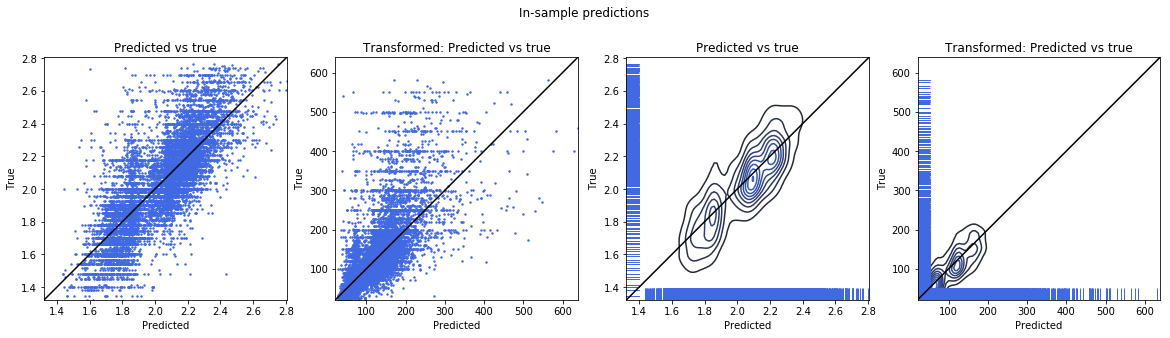

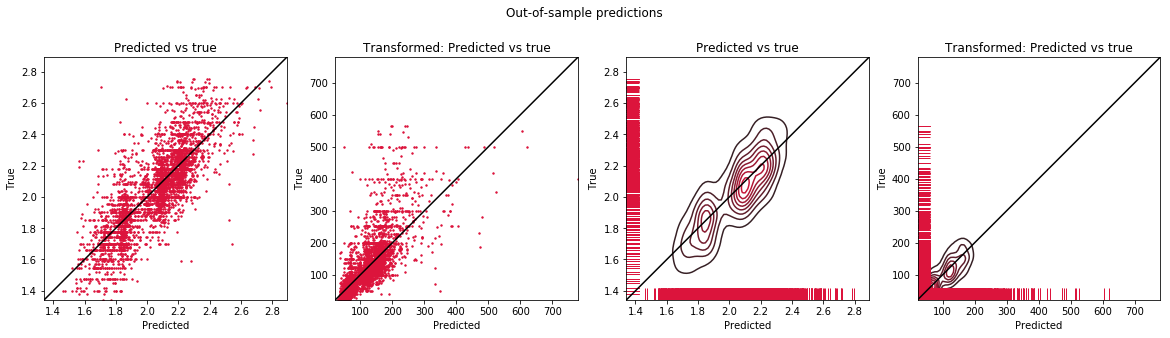

In [323]:
train_tpl = (X_train_500m, y_train_500m)
test_tpl = (X_test_500m, y_test_500m)
lasso_500m = print_results('Lasso_500m.p', test_tpl, train_tpl, 'both', True)

In [324]:
best_params = lasso_500m['fitted_model'].best_params_
best_params

{'lasso__alpha': 1e-10}

In [325]:
X_train, y_train = prepare_datasets(X_train_500m, y_train_500m)
regr = linear_model.Lasso(alpha=best_params['lasso__alpha'])
model = Pipeline([('scaler', StandardScaler()), ('lasso', regr)])
model.fit(X_train, y_train)
df = pd.DataFrame(data={'Coefficient': list(model.steps[1][1].coef_)})
df.index = [c for c in list(train_500m.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_500m_same_room_type                0.072017
Air_calculated_host_listings_count              -0.002372
Air_bathrooms                                    0.020674
Air_beds                                        -0.002800
Air_bedrooms                                     0.059884
Air_accommodates                                 0.031469
Air_extra_people                                 0.006575
Air_guests_included                              0.007827
Air_distance_to_CBD                             -0.041492
Air_property_type_2_House_Cottage_Villa          0.008088
Air_property_type_2_Other                        0.014974
Air_property_type_2_Townhouse                    0.007318
Air_room_type_Private room                      -0.058639
Air_room_type_Shared room                       -0.031189
Air_cancellation_policy_2_moderate              -0.004490
Air_cancellation_policy_2_strict                -0.000703
Air_neighbourhood_cleansed_Bayside               0.010951
Air_neighbourhood_cleansed_Boroondara            0.006061
Air_neighbourhood_cleansed_Brimbank             -0.005094
Air_neighbourhood_cleansed_Cardinia              0.012046
Air_neighbourhood_cleansed_Casey                 0.006108
Air_neighbourhood_cleansed_Darebin              -0.000178
Air_neighbourhood_cleansed_Frankston             0.012643
Air_neighbourhood_cleansed_Glen Eira             0.005426
Air_neighbourhood_cleansed_Greater Dandenong     0.000574
Air_neighbourhood_cleansed_Hobsons Bay           0.004807
Air_neighbourhood_cleansed_Hume                  0.000957
Air_neighbourhood_cleansed_Kingston              0.008320
Air_neighbourhood_cleansed_Knox                  0.003812
Air_neighbourhood_cleansed_Manningham            0.009401
Air_neighbourhood_cleansed_Maribyrnong          -0.002360
Air_neighbourhood_cleansed_Maroondah             0.000481
Air_neighbourhood_cleansed_Melbourne             0.029276
Air_neighbourhood_cleansed_Melton                0.001941
Air_neighbourhood_cleansed_Monash                0.003826
Air_neighbourhood_cleansed_Moonee Valley         0.000119
Air_neighbourhood_cleansed_Moreland             -0.000054
Air_neighbourhood_cleansed_Nillumbik             0.005594
Air_neighbourhood_cleansed_Port Phillip          0.025795
Air_neighbourhood_cleansed_Stonnington           0.020861
Air_neighbourhood_cleansed_Whitehorse            0.005306
Air_neighbourhood_cleansed_Whittlesea           -0.003095
Air_neighbourhood_cleansed_Wyndham               0.003335
Air_neighbourhood_cleansed_Yarra                 0.017116
Air_neighbourhood_cleansed_Yarra Ranges          0.045894

Ridge

Untransformed
-------------
R2 train: 0.63 / RMSE train 0.16 / MAE train 0.12 / Nobs: 13230
R2 test: 0.64 / RMSE test 0.16 / MAE test 0.12 / Nobs: 3739

Transformed
-----------
R2 train: 0.50 / RMSE train 60.78 / MAE train 36.83 / Nobs: 13230
R2 test: 0.51 / RMSE test 60.20 / MAE test 36.05 / Nobs: 3739



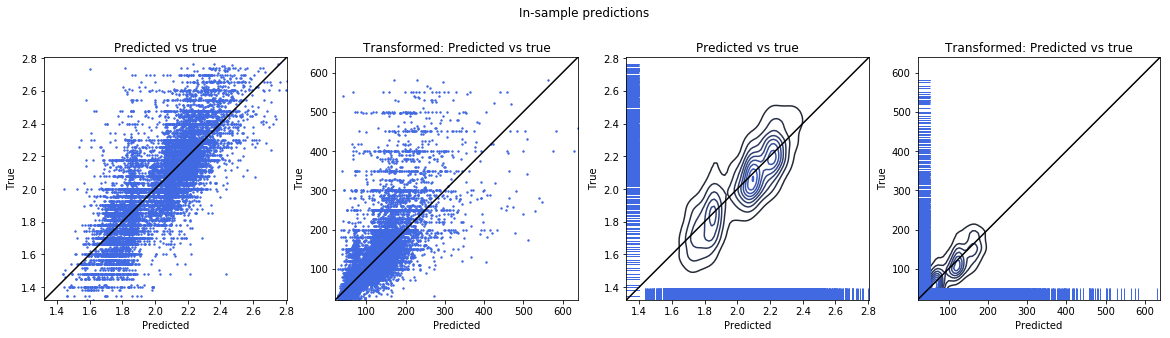

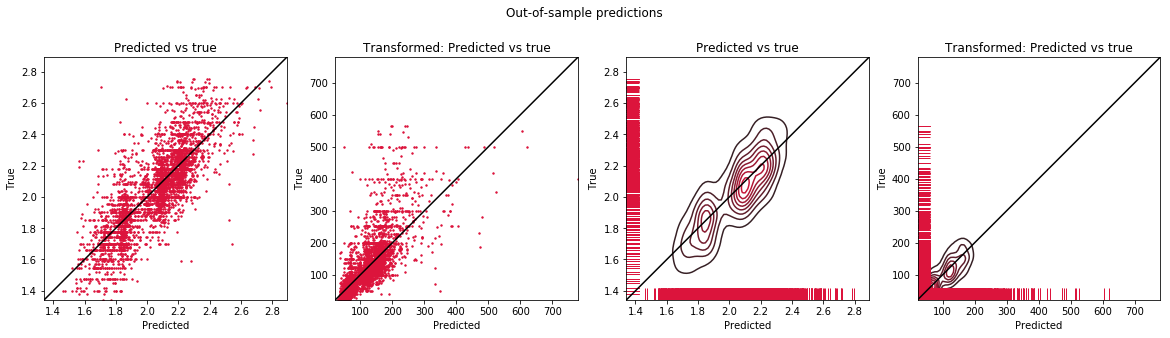

In [326]:
train_tpl = (X_train_500m, y_train_500m)
test_tpl = (X_test_500m, y_test_500m)
ridge_500m = print_results('Ridge_500m.p', test_tpl, train_tpl, 'both', True)

In [327]:
best_params = ridge_500m['fitted_model'].best_params_
best_params

{'ridge__alpha': 1e-10}

In [328]:
X_train, y_train = prepare_datasets(X_train_500m, y_train_500m)
regr = linear_model.Ridge(alpha=best_params['ridge__alpha'])
model = Pipeline([('scaler', StandardScaler()), ('ridge', regr)])
model.fit(X_train, y_train)
df = pd.DataFrame(data={'Coefficient': list(model.steps[1][1].coef_)})
df.index = [c for c in list(train_500m.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_500m_same_room_type                0.072017
Air_calculated_host_listings_count              -0.002372
Air_bathrooms                                    0.020674
Air_beds                                        -0.002800
Air_bedrooms                                     0.059884
Air_accommodates                                 0.031469
Air_extra_people                                 0.006575
Air_guests_included                              0.007827
Air_distance_to_CBD                             -0.041492
Air_property_type_2_House_Cottage_Villa          0.008088
Air_property_type_2_Other                        0.014974
Air_property_type_2_Townhouse                    0.007318
Air_room_type_Private room                      -0.058639
Air_room_type_Shared room                       -0.031189
Air_cancellation_policy_2_moderate              -0.004490
Air_cancellation_policy_2_strict                -0.000703
Air_neighbourhood_cleansed_Bayside               0.010951
Air_neighbourhood_cleansed_Boroondara            0.006061
Air_neighbourhood_cleansed_Brimbank             -0.005094
Air_neighbourhood_cleansed_Cardinia              0.012046
Air_neighbourhood_cleansed_Casey                 0.006108
Air_neighbourhood_cleansed_Darebin              -0.000178
Air_neighbourhood_cleansed_Frankston             0.012643
Air_neighbourhood_cleansed_Glen Eira             0.005426
Air_neighbourhood_cleansed_Greater Dandenong     0.000574
Air_neighbourhood_cleansed_Hobsons Bay           0.004807
Air_neighbourhood_cleansed_Hume                  0.000957
Air_neighbourhood_cleansed_Kingston              0.008320
Air_neighbourhood_cleansed_Knox                  0.003812
Air_neighbourhood_cleansed_Manningham            0.009401
Air_neighbourhood_cleansed_Maribyrnong          -0.002360
Air_neighbourhood_cleansed_Maroondah             0.000481
Air_neighbourhood_cleansed_Melbourne             0.029276
Air_neighbourhood_cleansed_Melton                0.001941
Air_neighbourhood_cleansed_Monash                0.003826
Air_neighbourhood_cleansed_Moonee Valley         0.000119
Air_neighbourhood_cleansed_Moreland             -0.000054
Air_neighbourhood_cleansed_Nillumbik             0.005594
Air_neighbourhood_cleansed_Port Phillip          0.025795
Air_neighbourhood_cleansed_Stonnington           0.020861
Air_neighbourhood_cleansed_Whitehorse            0.005306
Air_neighbourhood_cleansed_Whittlesea           -0.003095
Air_neighbourhood_cleansed_Wyndham               0.003335
Air_neighbourhood_cleansed_Yarra                 0.017116
Air_neighbourhood_cleansed_Yarra Ranges          0.045894

*Constructed aggregation - 100m*

Lasso

Untransformed
-------------
R2 train: 0.61 / RMSE train 0.15 / MAE train 0.11 / Nobs: 9203
R2 test: 0.62 / RMSE test 0.14 / MAE test 0.11 / Nobs: 2177

Transformed
-----------
R2 train: 0.49 / RMSE train 59.28 / MAE train 36.07 / Nobs: 9203
R2 test: 0.52 / RMSE test 53.54 / MAE test 34.09 / Nobs: 2177



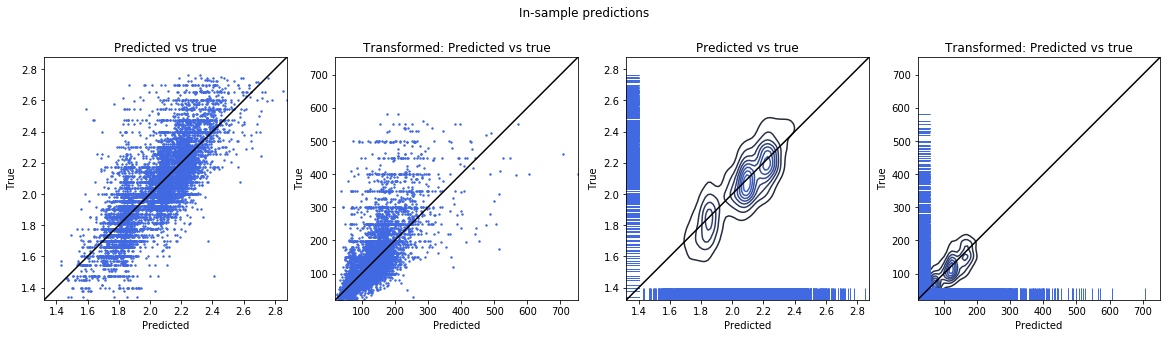

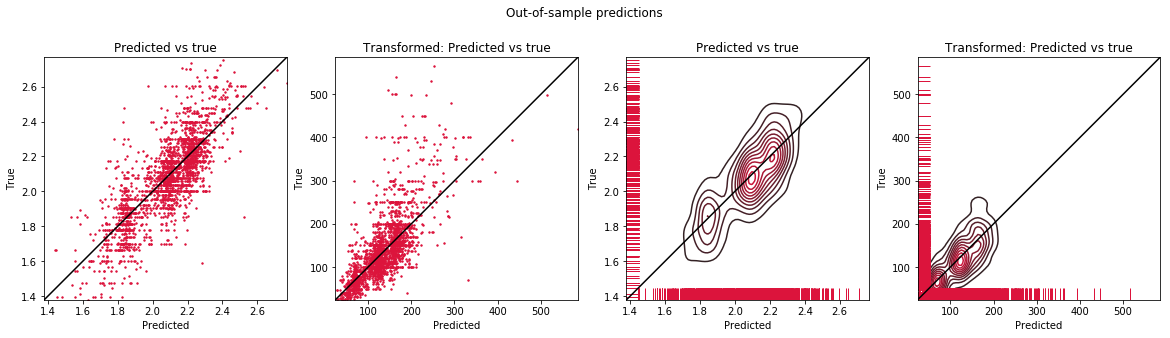

In [329]:
train_tpl = (X_train_100m, y_train_100m)
test_tpl = (X_test_100m, y_test_100m)
lasso_100m = print_results('Lasso_100m.p', test_tpl, train_tpl, 'both', True)

In [330]:
best_params = lasso_100m['fitted_model'].best_params_
best_params

{'lasso__alpha': 1e-10}

In [331]:
X_train, y_train = prepare_datasets(X_train_100m, y_train_100m)
regr = linear_model.Lasso(alpha=best_params['lasso__alpha'])
model = Pipeline([('scaler', StandardScaler()), ('lasso', regr)])
model.fit(X_train, y_train)
df = pd.DataFrame(data={'Coefficient': list(model.steps[1][1].coef_)})
df.index = [c for c in list(train_100m.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_100m_same_room_type                0.050536
Air_calculated_host_listings_count              -0.003934
Air_bathrooms                                    0.020505
Air_beds                                         0.004655
Air_bedrooms                                     0.062902
Air_accommodates                                 0.018612
Air_extra_people                                 0.007173
Air_guests_included                              0.005975
Air_distance_to_CBD                             -0.047910
Air_property_type_2_House_Cottage_Villa          0.002827
Air_property_type_2_Other                        0.015347
Air_property_type_2_Townhouse                    0.008265
Air_room_type_Private room                      -0.072731
Air_room_type_Shared room                       -0.033932
Air_cancellation_policy_2_moderate              -0.004780
Air_cancellation_policy_2_strict                -0.001768
Air_neighbourhood_cleansed_Bayside               0.009594
Air_neighbourhood_cleansed_Boroondara            0.004266
Air_neighbourhood_cleansed_Brimbank             -0.005107
Air_neighbourhood_cleansed_Cardinia              0.013060
Air_neighbourhood_cleansed_Casey                 0.007235
Air_neighbourhood_cleansed_Darebin              -0.001593
Air_neighbourhood_cleansed_Frankston             0.014526
Air_neighbourhood_cleansed_Glen Eira             0.002878
Air_neighbourhood_cleansed_Greater Dandenong    -0.000122
Air_neighbourhood_cleansed_Hobsons Bay           0.006109
Air_neighbourhood_cleansed_Hume                  0.000656
Air_neighbourhood_cleansed_Kingston              0.008182
Air_neighbourhood_cleansed_Knox                  0.002092
Air_neighbourhood_cleansed_Manningham            0.010892
Air_neighbourhood_cleansed_Maribyrnong          -0.001116
Air_neighbourhood_cleansed_Maroondah             0.001529
Air_neighbourhood_cleansed_Melbourne             0.023733
Air_neighbourhood_cleansed_Melton                0.006310
Air_neighbourhood_cleansed_Monash                0.007829
Air_neighbourhood_cleansed_Moonee Valley        -0.000536
Air_neighbourhood_cleansed_Moreland             -0.000480
Air_neighbourhood_cleansed_Nillumbik             0.005637
Air_neighbourhood_cleansed_Port Phillip          0.026390
Air_neighbourhood_cleansed_Stonnington           0.022083
Air_neighbourhood_cleansed_Whitehorse            0.007881
Air_neighbourhood_cleansed_Whittlesea           -0.005129
Air_neighbourhood_cleansed_Wyndham               0.008253
Air_neighbourhood_cleansed_Yarra                 0.015968
Air_neighbourhood_cleansed_Yarra Ranges          0.047257

Ridge

Untransformed
-------------
R2 train: 0.61 / RMSE train 0.15 / MAE train 0.11 / Nobs: 9203
R2 test: 0.62 / RMSE test 0.14 / MAE test 0.11 / Nobs: 2177

Transformed
-----------
R2 train: 0.49 / RMSE train 59.28 / MAE train 36.07 / Nobs: 9203
R2 test: 0.52 / RMSE test 53.54 / MAE test 34.09 / Nobs: 2177



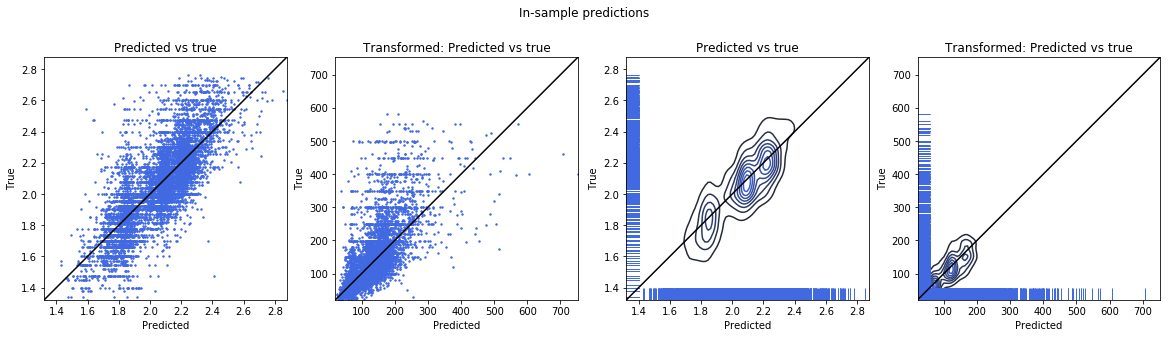

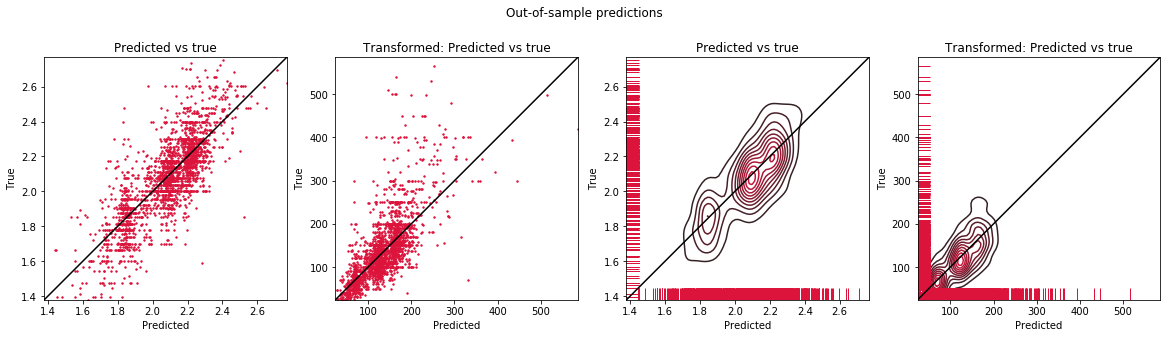

In [332]:
train_tpl = (X_train_100m, y_train_100m)
test_tpl = (X_test_100m, y_test_100m)
ridge_100m = print_results('Ridge_100m.p', test_tpl, train_tpl, 'both', True)

In [333]:
best_params = ridge_100m['fitted_model'].best_params_
best_params

{'ridge__alpha': 1e-10}

In [334]:
X_train, y_train = prepare_datasets(X_train_100m, y_train_100m)
regr = linear_model.Ridge(alpha=best_params['ridge__alpha'])
model = Pipeline([('scaler', StandardScaler()), ('ridge', regr)])
model.fit(X_train, y_train)
df = pd.DataFrame(data={'Coefficient': list(model.steps[1][1].coef_)})
df.index = [c for c in list(train_100m.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_100m_same_room_type                0.050536
Air_calculated_host_listings_count              -0.003934
Air_bathrooms                                    0.020505
Air_beds                                         0.004655
Air_bedrooms                                     0.062902
Air_accommodates                                 0.018612
Air_extra_people                                 0.007173
Air_guests_included                              0.005975
Air_distance_to_CBD                             -0.047909
Air_property_type_2_House_Cottage_Villa          0.002827
Air_property_type_2_Other                        0.015347
Air_property_type_2_Townhouse                    0.008265
Air_room_type_Private room                      -0.072731
Air_room_type_Shared room                       -0.033932
Air_cancellation_policy_2_moderate              -0.004780
Air_cancellation_policy_2_strict                -0.001768
Air_neighbourhood_cleansed_Bayside               0.009595
Air_neighbourhood_cleansed_Boroondara            0.004268
Air_neighbourhood_cleansed_Brimbank             -0.005106
Air_neighbourhood_cleansed_Cardinia              0.013060
Air_neighbourhood_cleansed_Casey                 0.007235
Air_neighbourhood_cleansed_Darebin              -0.001591
Air_neighbourhood_cleansed_Frankston             0.014526
Air_neighbourhood_cleansed_Glen Eira             0.002880
Air_neighbourhood_cleansed_Greater Dandenong    -0.000122
Air_neighbourhood_cleansed_Hobsons Bay           0.006110
Air_neighbourhood_cleansed_Hume                  0.000656
Air_neighbourhood_cleansed_Kingston              0.008183
Air_neighbourhood_cleansed_Knox                  0.002093
Air_neighbourhood_cleansed_Manningham            0.010894
Air_neighbourhood_cleansed_Maribyrnong          -0.001115
Air_neighbourhood_cleansed_Maroondah             0.001529
Air_neighbourhood_cleansed_Melbourne             0.023740
Air_neighbourhood_cleansed_Melton                0.006311
Air_neighbourhood_cleansed_Monash                0.007830
Air_neighbourhood_cleansed_Moonee Valley        -0.000535
Air_neighbourhood_cleansed_Moreland             -0.000477
Air_neighbourhood_cleansed_Nillumbik             0.005638
Air_neighbourhood_cleansed_Port Phillip          0.026396
Air_neighbourhood_cleansed_Stonnington           0.022087
Air_neighbourhood_cleansed_Whitehorse            0.007883
Air_neighbourhood_cleansed_Whittlesea           -0.005128
Air_neighbourhood_cleansed_Wyndham               0.008254
Air_neighbourhood_cleansed_Yarra                 0.015972
Air_neighbourhood_cleansed_Yarra Ranges          0.047258

*Constructed aggregation - 50m*

Lasso

Untransformed
-------------
R2 train: 0.59 / RMSE train 0.15 / MAE train 0.11 / Nobs: 6522
R2 test: 0.62 / RMSE test 0.14 / MAE test 0.10 / Nobs: 1340

Transformed
-----------
R2 train: 0.47 / RMSE train 58.91 / MAE train 35.91 / Nobs: 6522
R2 test: 0.51 / RMSE test 51.07 / MAE test 32.92 / Nobs: 1340



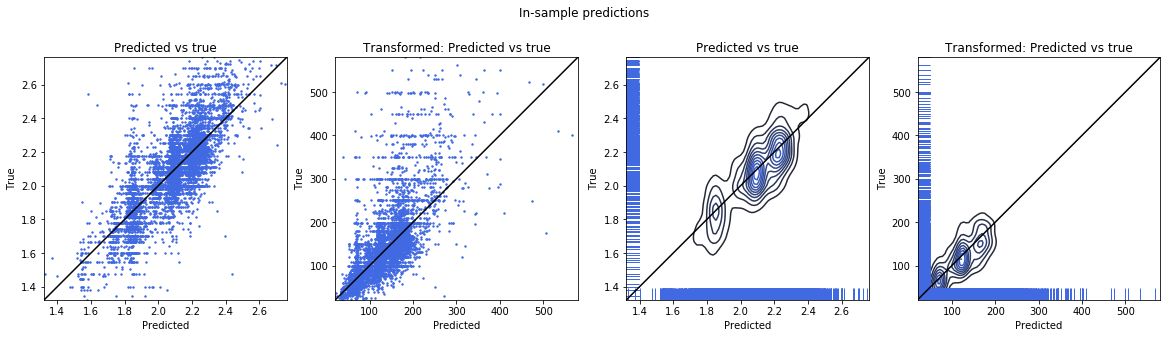

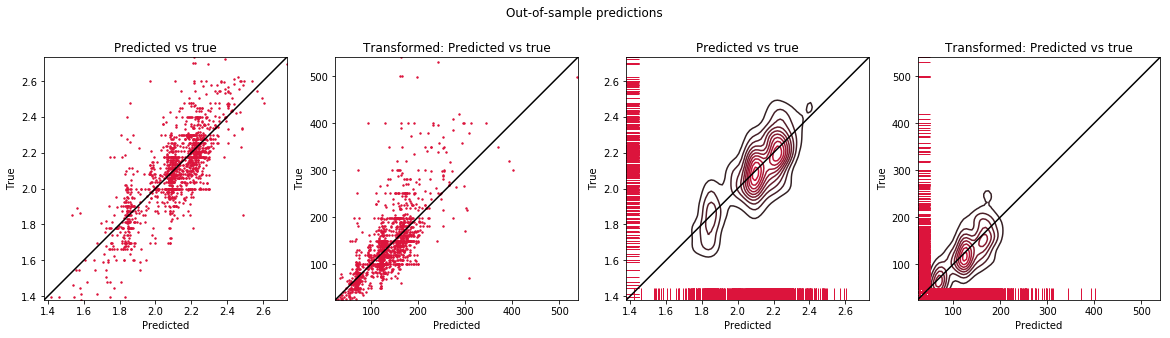

In [335]:
train_tpl = (X_train_50m, y_train_50m)
test_tpl = (X_test_50m, y_test_50m)
lasso_50m = print_results('Lasso_50m.p', test_tpl, train_tpl, 'both', True)

In [336]:
best_params = lasso_50m['fitted_model'].best_params_
best_params

{'lasso__alpha': 0.0001}

In [337]:
X_train, y_train = prepare_datasets(X_train_50m, y_train_50m)
regr = linear_model.Lasso(alpha=best_params['lasso__alpha'])
model = Pipeline([('scaler', StandardScaler()), ('lasso', regr)])
model.fit(X_train, y_train)
df = pd.DataFrame(data={'Coefficient': list(model.steps[1][1].coef_)})
df.index = [c for c in list(train_50m.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_50m_same_room_type                 0.026636
Air_calculated_host_listings_count              -0.005140
Air_bathrooms                                    0.021342
Air_beds                                         0.007403
Air_bedrooms                                     0.064463
Air_accommodates                                 0.011711
Air_extra_people                                 0.007733
Air_guests_included                              0.007199
Air_distance_to_CBD                             -0.045437
Air_property_type_2_House_Cottage_Villa          0.001931
Air_property_type_2_Other                        0.014725
Air_property_type_2_Townhouse                    0.004547
Air_room_type_Private room                      -0.082463
Air_room_type_Shared room                       -0.042578
Air_cancellation_policy_2_moderate              -0.003387
Air_cancellation_policy_2_strict                -0.001673
Air_neighbourhood_cleansed_Bayside               0.008678
Air_neighbourhood_cleansed_Boroondara            0.001448
Air_neighbourhood_cleansed_Brimbank             -0.008088
Air_neighbourhood_cleansed_Cardinia              0.013536
Air_neighbourhood_cleansed_Casey                 0.005201
Air_neighbourhood_cleansed_Darebin              -0.006386
Air_neighbourhood_cleansed_Frankston             0.010949
Air_neighbourhood_cleansed_Glen Eira            -0.000387
Air_neighbourhood_cleansed_Greater Dandenong    -0.002800
Air_neighbourhood_cleansed_Hobsons Bay           0.001174
Air_neighbourhood_cleansed_Hume                  0.001094
Air_neighbourhood_cleansed_Kingston              0.005825
Air_neighbourhood_cleansed_Knox                  0.001036
Air_neighbourhood_cleansed_Manningham            0.007967
Air_neighbourhood_cleansed_Maribyrnong          -0.004653
Air_neighbourhood_cleansed_Maroondah            -0.002311
Air_neighbourhood_cleansed_Melbourne             0.000000
Air_neighbourhood_cleansed_Melton                0.008736
Air_neighbourhood_cleansed_Monash                0.003112
Air_neighbourhood_cleansed_Moonee Valley        -0.003570
Air_neighbourhood_cleansed_Moreland             -0.008479
Air_neighbourhood_cleansed_Nillumbik             0.005642
Air_neighbourhood_cleansed_Port Phillip          0.008386
Air_neighbourhood_cleansed_Stonnington           0.009682
Air_neighbourhood_cleansed_Whitehorse            0.001364
Air_neighbourhood_cleansed_Whittlesea           -0.008391
Air_neighbourhood_cleansed_Wyndham               0.001526
Air_neighbourhood_cleansed_Yarra                 0.001599
Air_neighbourhood_cleansed_Yarra Ranges          0.036766

Ridge

Untransformed
-------------
R2 train: 0.59 / RMSE train 0.15 / MAE train 0.11 / Nobs: 6522
R2 test: 0.62 / RMSE test 0.14 / MAE test 0.10 / Nobs: 1340

Transformed
-----------
R2 train: 0.47 / RMSE train 58.91 / MAE train 35.93 / Nobs: 6522
R2 test: 0.51 / RMSE test 50.99 / MAE test 32.87 / Nobs: 1340



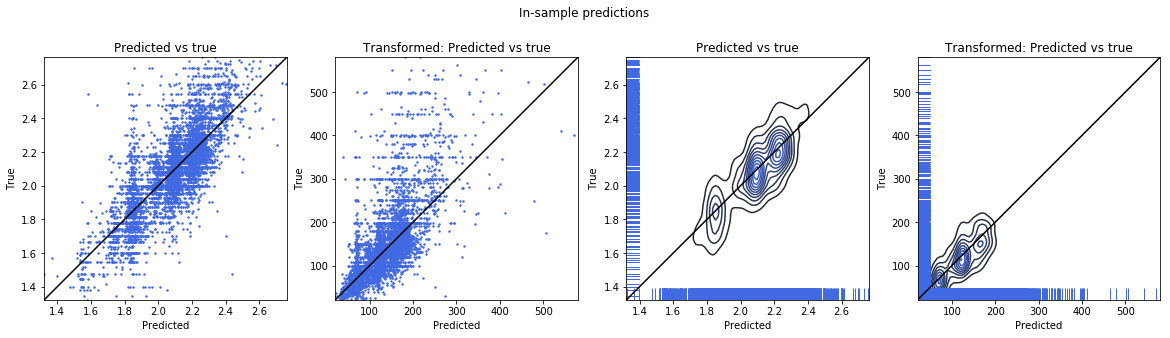

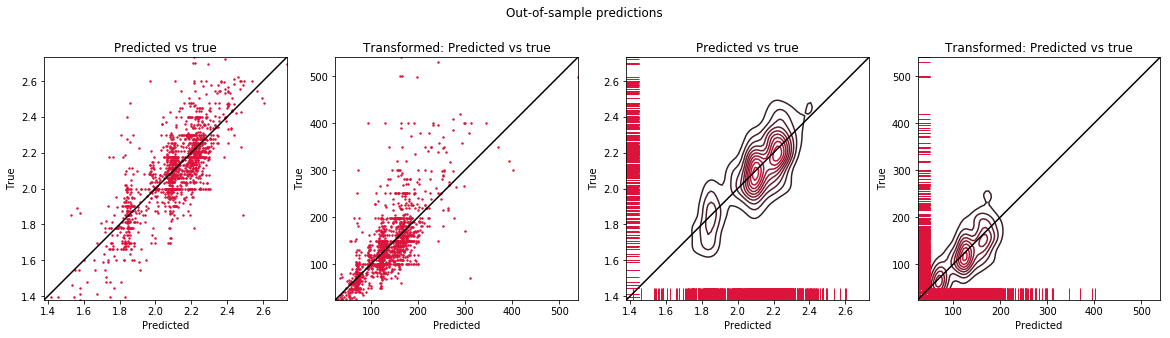

In [338]:
train_tpl = (X_train_50m, y_train_50m)
test_tpl = (X_test_50m, y_test_50m)
ridge_50m = print_results('Ridge_50m.p', test_tpl, train_tpl, 'both', True)

In [339]:
best_params =ridge_50m['fitted_model'].best_params_ 
best_params

{'ridge__alpha': 1e-10}

In [340]:
X_train, y_train = prepare_datasets(X_train_50m, y_train_50m)
regr = linear_model.Ridge(alpha=best_params['ridge__alpha'])
model = Pipeline([('scaler', StandardScaler()), ('ridge', regr)])
model.fit(X_train, y_train)
df = pd.DataFrame(data={'Coefficient': list(model.steps[1][1].coef_)})
df.index = [c for c in list(train_50m.columns) if c != 'Air_log_price']
df

Coefficient
Air_log_price_50m_same_room_type                 0.026285
Air_calculated_host_listings_count              -0.005202
Air_bathrooms                                    0.021357
Air_beds                                         0.007545
Air_bedrooms                                     0.064507
Air_accommodates                                 0.011460
Air_extra_people                                 0.007802
Air_guests_included                              0.007316
Air_distance_to_CBD                             -0.047772
Air_property_type_2_House_Cottage_Villa          0.002274
Air_property_type_2_Other                        0.014948
Air_property_type_2_Townhouse                    0.004768
Air_room_type_Private room                      -0.082907
Air_room_type_Shared room                       -0.042841
Air_cancellation_policy_2_moderate              -0.003664
Air_cancellation_policy_2_strict                -0.001936
Air_neighbourhood_cleansed_Bayside               0.011791
Air_neighbourhood_cleansed_Boroondara            0.005103
Air_neighbourhood_cleansed_Brimbank             -0.007264
Air_neighbourhood_cleansed_Cardinia              0.014843
Air_neighbourhood_cleansed_Casey                 0.006489
Air_neighbourhood_cleansed_Darebin              -0.001919
Air_neighbourhood_cleansed_Frankston             0.013610
Air_neighbourhood_cleansed_Glen Eira             0.003480
Air_neighbourhood_cleansed_Greater Dandenong    -0.000343
Air_neighbourhood_cleansed_Hobsons Bay           0.004012
Air_neighbourhood_cleansed_Hume                  0.003505
Air_neighbourhood_cleansed_Kingston              0.008146
Air_neighbourhood_cleansed_Knox                  0.002944
Air_neighbourhood_cleansed_Manningham            0.011982
Air_neighbourhood_cleansed_Maribyrnong          -0.000490
Air_neighbourhood_cleansed_Maroondah            -0.000598
Air_neighbourhood_cleansed_Melbourne             0.024667
Air_neighbourhood_cleansed_Melton                0.011878
Air_neighbourhood_cleansed_Monash                0.007426
Air_neighbourhood_cleansed_Moonee Valley        -0.000621
Air_neighbourhood_cleansed_Moreland             -0.001070
Air_neighbourhood_cleansed_Nillumbik             0.006813
Air_neighbourhood_cleansed_Port Phillip          0.026921
Air_neighbourhood_cleansed_Stonnington           0.023619
Air_neighbourhood_cleansed_Whitehorse            0.008141
Air_neighbourhood_cleansed_Whittlesea           -0.006969
Air_neighbourhood_cleansed_Wyndham               0.004807
Air_neighbourhood_cleansed_Yarra                 0.016056
Air_neighbourhood_cleansed_Yarra Ranges          0.041662

**4. Bagging**

Random Forest is a bagging method. Many weak learners - in this case regression trees - are learned and the results are aggregated. No standardization of the features is necessary for this algorithm so we left it out. To speed up the optimization `RandomizedSearchCV()` is used instead of `GridSearchCV()`.

Random Forest v1

In [341]:
# Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

In [342]:
param_grid_rf_v1 = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf}

print(param_grid_rf_v1)

{'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


*Aggregation by suburbs*

*This step is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.71 / RMSE train 0.15 / MAE train 0.11 / Nobs: 14261
R2 test: 0.67 / RMSE test 0.15 / MAE test 0.12 / Nobs: 4451

Transformed
-----------
R2 train: 0.59 / RMSE train 55.24 / MAE train 32.12 / Nobs: 14261
R2 test: 0.55 / RMSE test 57.24 / MAE test 34.66 / Nobs: 4451



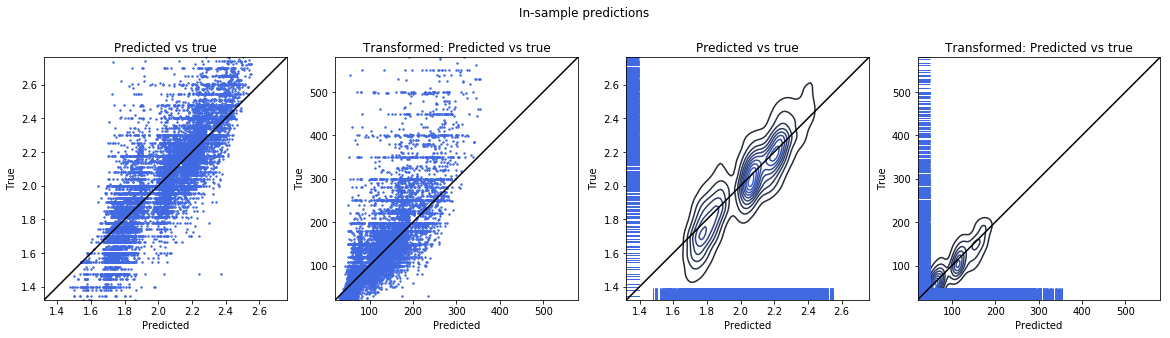

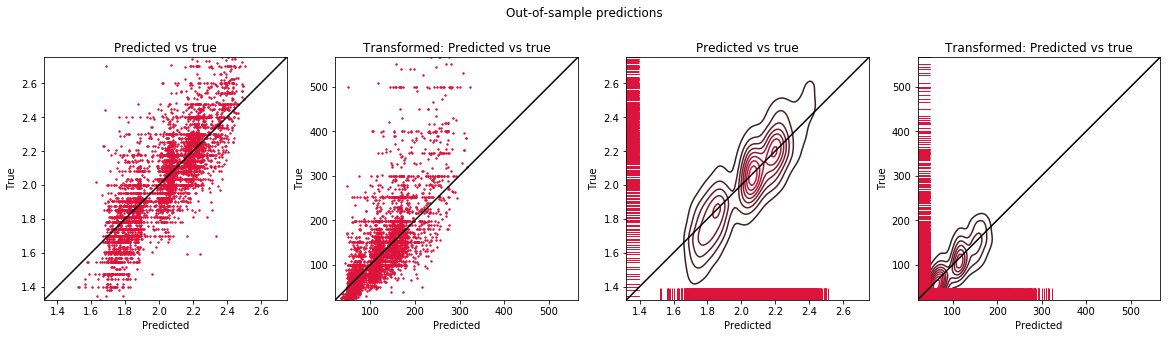

In [343]:
train_tpl = (X_train_suburb, y_train_suburb)
test_tpl = (X_test_suburb, y_test_suburb)
rf_suburb = print_results('RF_suburbs.p', test_tpl, train_tpl, 'both', True)

In [344]:
best_params = rf_suburb['fitted_model'].best_params_
best_params

{'n_estimators': 120,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10}

Feature importance

In [345]:
names = tuple(np.delete(train_suburb.columns.values, 0))
values = tuple(rf_suburb['fitted_model'].best_estimator_.feature_importances_)

fi_suburb = pd.DataFrame(zip(names,values))
fi_suburb.columns = ('Variable', 'Importance')
fi_suburb

Variable  Importance
0            Air_log_price_suburb_same_room_type    0.233019
1             Air_calculated_host_listings_count    0.015235
2                                  Air_bathrooms    0.044644
3                                       Air_beds    0.077019
4                                   Air_bedrooms    0.147770
5                               Air_accommodates    0.144688
6                               Air_extra_people    0.021330
7                            Air_guests_included    0.042929
8                            Air_distance_to_CBD    0.028742
9        Air_property_type_2_House_Cottage_Villa    0.016916
10                     Air_property_type_2_Other    0.005451
11                 Air_property_type_2_Townhouse    0.001316
12                    Air_room_type_Private room    0.160782
13                     Air_room_type_Shared room    0.019600
14            Air_cancellation_policy_2_moderate    0.001176
15              Air_cancellation_policy_2_strict    0.008686
16            Air_neighbourhood_cleansed_Bayside    0.000529
17         Air_neighbourhood_cleansed_Boroondara    0.000226
18           Air_neighbourhood_cleansed_Brimbank    0.000337
19           Air_neighbourhood_cleansed_Cardinia    0.000331
20              Air_neighbourhood_cleansed_Casey    0.000139
21            Air_neighbourhood_cleansed_Darebin    0.000923
22          Air_neighbourhood_cleansed_Frankston    0.000213
23          Air_neighbourhood_cleansed_Glen Eira    0.000336
24  Air_neighbourhood_cleansed_Greater Dandenong    0.000453
25        Air_neighbourhood_cleansed_Hobsons Bay    0.000179
26               Air_neighbourhood_cleansed_Hume    0.000533
27           Air_neighbourhood_cleansed_Kingston    0.000123
28               Air_neighbourhood_cleansed_Knox    0.000094
29         Air_neighbourhood_cleansed_Manningham    0.000364
30        Air_neighbourhood_cleansed_Maribyrnong    0.000349
31          Air_neighbourhood_cleansed_Maroondah    0.000139
32          Air_neighbourhood_cleansed_Melbourne    0.005493
33             Air_neighbourhood_cleansed_Melton    0.000402
34             Air_neighbourhood_cleansed_Monash    0.001478
35      Air_neighbourhood_cleansed_Moonee Valley    0.000290
36           Air_neighbourhood_cleansed_Moreland    0.001244
37          Air_neighbourhood_cleansed_Nillumbik    0.000116
38       Air_neighbourhood_cleansed_Port Phillip    0.002326
39        Air_neighbourhood_cleansed_Stonnington    0.000815
40         Air_neighbourhood_cleansed_Whitehorse    0.001018
41         Air_neighbourhood_cleansed_Whittlesea    0.000539
42            Air_neighbourhood_cleansed_Wyndham    0.001038
43              Air_neighbourhood_cleansed_Yarra    0.000783
44       Air_neighbourhood_cleansed_Yarra Ranges    0.009887

Hyper-parameter patterns

In [346]:
n_estimators = np.array(rf_suburb['fitted_model'].cv_results_['param_n_estimators'])
max_features = np.array(rf_suburb['fitted_model'].cv_results_['param_max_features'])
max_depth = np.array(rf_suburb['fitted_model'].cv_results_['param_max_depth'])
min_samples_split = np.array(rf_suburb['fitted_model'].cv_results_['param_min_samples_split'])
min_samples_leaf = np.array(rf_suburb['fitted_model'].cv_results_['param_min_samples_leaf'])
mean_test_score = np.array(rf_suburb['fitted_model'].cv_results_['mean_test_score'])

df = pd.DataFrame(data={'n_estimators': n_estimators,
                        'max_features': max_features,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'mean_test_score': mean_test_score})
df = df.sort_values(by='mean_test_score', ascending=False)

The `mean_test_score` is the score on the validation test. Since there is no cross validation no mean is actually computed. The scores on the validation set are lower than on the test set.

In [347]:
df.head(10)

n_estimators max_features max_depth min_samples_split min_samples_leaf  \
42          120         sqrt        10                 5                4   
16           40         sqrt        10                10                1   
3           100         sqrt        10                 5                2   
36          160         sqrt      None                10                4   
49          120         sqrt        30                10                4   
27          160         sqrt        30                 5                4   
25           60         sqrt       110                10                4   
4            60         sqrt        40                10                4   
19          180         sqrt       100                 2                4   
15          160         sqrt        40                 2                4   

    mean_test_score  
42         0.629192  
16         0.625705  
3          0.624303  
36         0.591857  
49         0.591758  
27         0.590892  
25         0.590569  
4          0.590569  
19         0.590168  
15         0.589283

In [348]:
df.tail(10)

n_estimators max_features max_depth min_samples_split min_samples_leaf  \
18          180         auto        60                 5                1   
23          160         auto        50                 5                1   
12          100         auto       110                 5                1   
47          120         auto        40                 5                2   
22           80         auto        50                 5                1   
33           40         auto       100                 5                2   
46           20         auto        30                 5                1   
30          180         auto      None                 2                1   
7           180         auto       110                 2                1   
24           60         auto      None                 2                1   

    mean_test_score  
18        -0.736671  
23        -0.745722  
12        -0.752102  
47        -0.759208  
22        -0.762301  
33        -0.796160  
46        -0.814335  
30        -0.814537  
7         -0.814537  
24        -0.890496

Random Forest v2

From the output we see that `auto` leads to poor results.

In [349]:
# Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2']

# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(1, 110, num = 11)]
max_depth = [int(x) for x in np.linspace(5, 20, num = 4)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 10]

In [350]:
param_grid_rf_v2 = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf}

print(param_grid_rf_v2)

{'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'max_features': ['sqrt', 'log2'], 'max_depth': [5, 10, 15, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 6, 10]}


*This step is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.72 / RMSE train 0.14 / MAE train 0.10 / Nobs: 14261
R2 test: 0.67 / RMSE test 0.15 / MAE test 0.12 / Nobs: 4451

Transformed
-----------
R2 train: 0.61 / RMSE train 54.07 / MAE train 31.49 / Nobs: 14261
R2 test: 0.56 / RMSE test 57.01 / MAE test 34.55 / Nobs: 4451



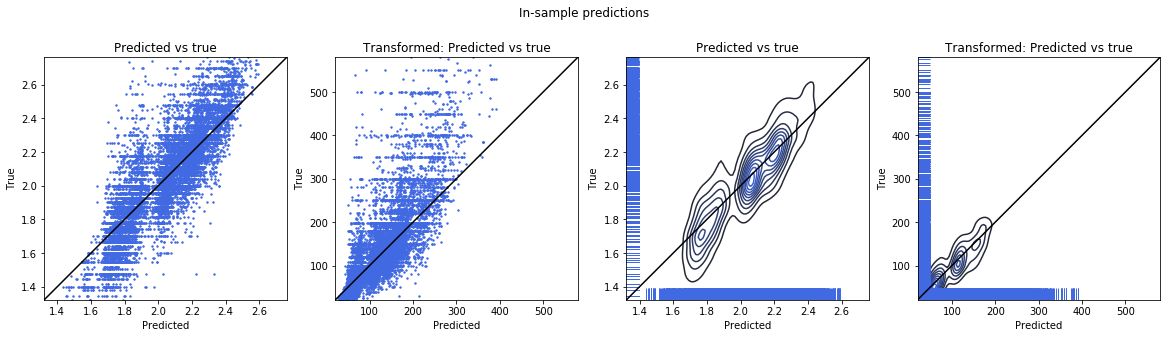

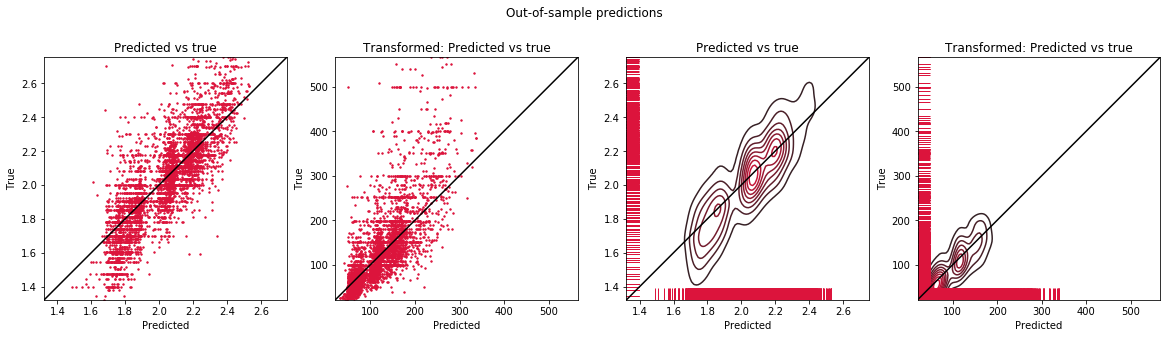

In [351]:
train_tpl = (X_train_suburb, y_train_suburb)
test_tpl = (X_test_suburb, y_test_suburb)
rf_suburb_v2 = print_results('RF_suburbs_v2.p', test_tpl, train_tpl, 'both', True)

In [352]:
best_params = rf_suburb_v2['fitted_model'].best_params_
best_params

{'n_estimators': 120,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10}

Feature importance

In [353]:
names = tuple(np.delete(train_suburb.columns.values, 0))
values = tuple(rf_suburb_v2['fitted_model'].best_estimator_.feature_importances_)

fi_suburb = pd.DataFrame(zip(names,values))
fi_suburb.columns = ('Variable', 'Importance')
fi_suburb

Variable  Importance
0            Air_log_price_suburb_same_room_type    0.241896
1             Air_calculated_host_listings_count    0.015393
2                                  Air_bathrooms    0.043770
3                                       Air_beds    0.078926
4                                   Air_bedrooms    0.142347
5                               Air_accommodates    0.138603
6                               Air_extra_people    0.020929
7                            Air_guests_included    0.045600
8                            Air_distance_to_CBD    0.029462
9        Air_property_type_2_House_Cottage_Villa    0.016584
10                     Air_property_type_2_Other    0.005123
11                 Air_property_type_2_Townhouse    0.001493
12                    Air_room_type_Private room    0.158751
13                     Air_room_type_Shared room    0.018153
14            Air_cancellation_policy_2_moderate    0.001103
15              Air_cancellation_policy_2_strict    0.009429
16            Air_neighbourhood_cleansed_Bayside    0.000688
17         Air_neighbourhood_cleansed_Boroondara    0.000322
18           Air_neighbourhood_cleansed_Brimbank    0.000375
19           Air_neighbourhood_cleansed_Cardinia    0.000458
20              Air_neighbourhood_cleansed_Casey    0.000211
21            Air_neighbourhood_cleansed_Darebin    0.000851
22          Air_neighbourhood_cleansed_Frankston    0.000176
23          Air_neighbourhood_cleansed_Glen Eira    0.000415
24  Air_neighbourhood_cleansed_Greater Dandenong    0.000540
25        Air_neighbourhood_cleansed_Hobsons Bay    0.000344
26               Air_neighbourhood_cleansed_Hume    0.000530
27           Air_neighbourhood_cleansed_Kingston    0.000199
28               Air_neighbourhood_cleansed_Knox    0.000209
29         Air_neighbourhood_cleansed_Manningham    0.000415
30        Air_neighbourhood_cleansed_Maribyrnong    0.000457
31          Air_neighbourhood_cleansed_Maroondah    0.000220
32          Air_neighbourhood_cleansed_Melbourne    0.005099
33             Air_neighbourhood_cleansed_Melton    0.000543
34             Air_neighbourhood_cleansed_Monash    0.001211
35      Air_neighbourhood_cleansed_Moonee Valley    0.000400
36           Air_neighbourhood_cleansed_Moreland    0.001185
37          Air_neighbourhood_cleansed_Nillumbik    0.000178
38       Air_neighbourhood_cleansed_Port Phillip    0.002322
39        Air_neighbourhood_cleansed_Stonnington    0.000951
40         Air_neighbourhood_cleansed_Whitehorse    0.001128
41         Air_neighbourhood_cleansed_Whittlesea    0.000451
42            Air_neighbourhood_cleansed_Wyndham    0.001302
43              Air_neighbourhood_cleansed_Yarra    0.000900
44       Air_neighbourhood_cleansed_Yarra Ranges    0.010358

Hyper-parameter patterns 

In [354]:
n_estimators = np.array(rf_suburb_v2['fitted_model'].cv_results_['param_n_estimators'])
max_features = np.array(rf_suburb_v2['fitted_model'].cv_results_['param_max_features'])
max_depth = np.array(rf_suburb_v2['fitted_model'].cv_results_['param_max_depth'])
min_samples_split = np.array(rf_suburb_v2['fitted_model'].cv_results_['param_min_samples_split'])
min_samples_leaf = np.array(rf_suburb_v2['fitted_model'].cv_results_['param_min_samples_leaf'])
mean_test_score = np.array(rf_suburb_v2['fitted_model'].cv_results_['mean_test_score'])

df = pd.DataFrame(data={'n_estimators': n_estimators,
                        'max_features': max_features,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'mean_test_score': mean_test_score})
df = df.sort_values(by='mean_test_score', ascending=False)

In [355]:
df.head(10)

n_estimators max_features max_depth min_samples_split min_samples_leaf  \
9           120         sqrt        10                 2                2   
19          100         sqrt        10                10                6   
41           40         log2        10                10                6   
3            20         sqrt        10                 2                2   
43          200         log2        10                 5               10   
47          120         log2        15                10               10   
44          100         log2        15                10               10   
23          180         log2        15                10                2   
14           60         sqrt        15                 2                6   
45          160         sqrt        15                 2                6   

    mean_test_score  
9          0.632367  
19         0.628509  
41         0.627645  
3          0.627554  
43         0.626010  
47         0.622606  
44         0.622228  
23         0.619132  
14         0.618556  
45         0.618343

In [356]:
df.tail(10)

n_estimators max_features max_depth min_samples_split min_samples_leaf  \
34           40         log2         5                10                4   
31           60         log2         5                10               10   
2           100         sqrt      None                 2                4   
25          200         log2      None                 5                2   
17          140         sqrt        20                10                1   
40          120         sqrt        20                10                1   
26           80         sqrt      None                 5                2   
27           60         sqrt        20                10                1   
46           40         sqrt      None                 5                1   
12           20         sqrt      None                10                1   

    mean_test_score  
34         0.586147  
31         0.584609  
2          0.582612  
25         0.567639  
17         0.552705  
40         0.548198  
26         0.543004  
27         0.536130  
46         0.462435  
12         0.451988

Since the variables are correlated, a multivariate regression is considered to investigate the effect of the different parameters. The fit is better when `max_features` and `min_samples_leaf` are high. However, a lot of variation cannot be explained by the model. The fit is poor.

<!---We see that the score is smaller the larger `min_samples_split` is. As opposed to this, the score seems to be increasing with `min_samples_leaf`. However, the effects are contradicting since higher values in the two variables correspond to a smaller model. Furthermore, a lot of variation cannot be explained by the model.
--->

In [357]:
X = df.loc[:, ['n_estimators', 'max_features', 'max_depth', 'min_samples_split', 'min_samples_leaf']]
X['max_features'] = pd.factorize(X['max_features'])[0]
X['max_depth'] = pd.factorize(X['max_depth'])[0]
#X['n_estimators_sq'] = X['n_estimators']**2
#X['max_features_sq'] = X['max_features']**2
#X['min_samples_split_sq'] = X['min_samples_split']**2
#X['min_samples_leaf_sq'] = X['min_samples_leaf']**2
y = df.loc[:, ['mean_test_score']]
X = sm.add_constant(X)
rf_results = sm.OLS(y, X.astype(float)).fit()
print(rf_results.summary())

                            OLS Regression Results                            
Dep. Variable:        mean_test_score   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     5.270
Date:                Wed, 08 Jul 2020   Prob (F-statistic):           0.000705
Time:                        19:19:21   Log-Likelihood:                 107.81
No. Observations:                  50   AIC:                            -203.6
Df Residuals:                      44   BIC:                            -192.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5606      0.01

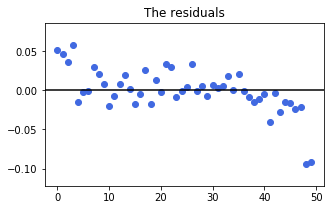

In [358]:
mean = np.mean(rf_results.resid)
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.scatter(x=range(rf_results.resid.shape[0]), y=rf_results.resid, alpha=1, color=col1)
ax.axhline(mean, color="black")
ax.set_title("The residuals");

*Constructed aggregation - 500m*

`param_grid_rf_v2` is used for hyper-parameter optimization.

*This set is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.80 / RMSE train 0.12 / MAE train 0.09 / Nobs: 13230
R2 test: 0.70 / RMSE test 0.14 / MAE test 0.10 / Nobs: 3739

Transformed
-----------
R2 train: 0.73 / RMSE train 44.96 / MAE train 26.36 / Nobs: 13230
R2 test: 0.60 / RMSE test 54.05 / MAE test 31.85 / Nobs: 3739



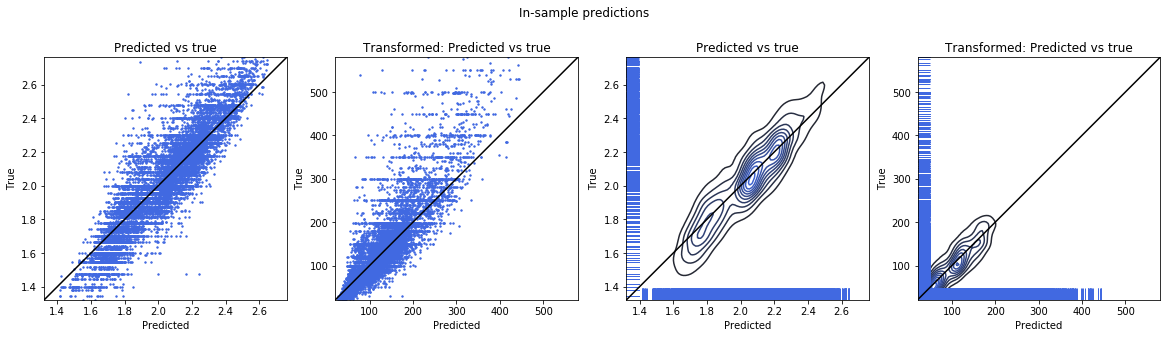

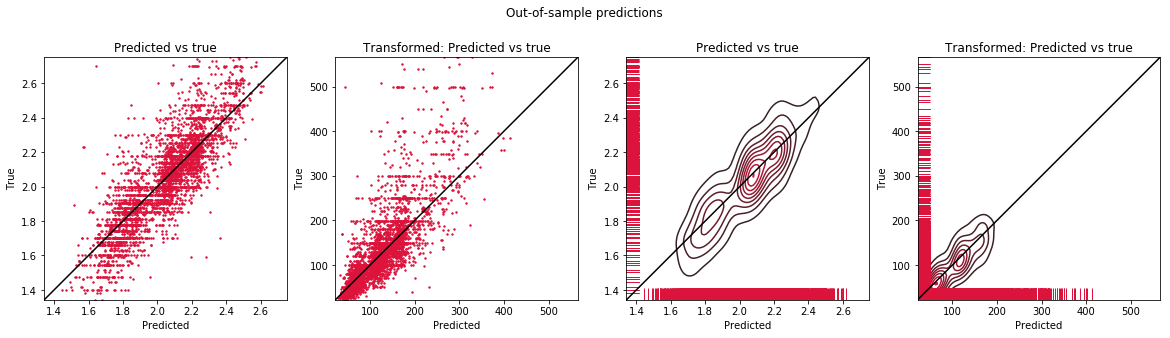

In [359]:
train_tpl = (X_train_500m, y_train_500m)
test_tpl = (X_test_500m, y_test_500m)
rf_500m = print_results('RF_500m.p', test_tpl, train_tpl, 'both', True)

In [360]:
best_params = rf_500m['fitted_model'].best_params_
best_params

{'n_estimators': 120,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20}

Feature importance

In [361]:
names = tuple(np.delete(train_500m.columns.values, 0))
values = tuple(rf_500m['fitted_model'].best_estimator_.feature_importances_)

fi_500m = pd.DataFrame(zip(names,values))
fi_500m.columns = ('Variable', 'Importance')
fi_500m

Variable  Importance
0              Air_log_price_500m_same_room_type    0.215327
1             Air_calculated_host_listings_count    0.025822
2                                  Air_bathrooms    0.046467
3                                       Air_beds    0.070695
4                                   Air_bedrooms    0.139753
5                               Air_accommodates    0.125851
6                               Air_extra_people    0.030904
7                            Air_guests_included    0.041669
8                            Air_distance_to_CBD    0.051778
9        Air_property_type_2_House_Cottage_Villa    0.017673
10                     Air_property_type_2_Other    0.006982
11                 Air_property_type_2_Townhouse    0.003545
12                    Air_room_type_Private room    0.142500
13                     Air_room_type_Shared room    0.016395
14            Air_cancellation_policy_2_moderate    0.003752
15              Air_cancellation_policy_2_strict    0.009232
16            Air_neighbourhood_cleansed_Bayside    0.001530
17         Air_neighbourhood_cleansed_Boroondara    0.001756
18           Air_neighbourhood_cleansed_Brimbank    0.000999
19           Air_neighbourhood_cleansed_Cardinia    0.000446
20              Air_neighbourhood_cleansed_Casey    0.000289
21            Air_neighbourhood_cleansed_Darebin    0.002335
22          Air_neighbourhood_cleansed_Frankston    0.000588
23          Air_neighbourhood_cleansed_Glen Eira    0.001630
24  Air_neighbourhood_cleansed_Greater Dandenong    0.000582
25        Air_neighbourhood_cleansed_Hobsons Bay    0.001051
26               Air_neighbourhood_cleansed_Hume    0.001020
27           Air_neighbourhood_cleansed_Kingston    0.000839
28               Air_neighbourhood_cleansed_Knox    0.000449
29         Air_neighbourhood_cleansed_Manningham    0.001385
30        Air_neighbourhood_cleansed_Maribyrnong    0.001490
31          Air_neighbourhood_cleansed_Maroondah    0.000592
32          Air_neighbourhood_cleansed_Melbourne    0.005193
33             Air_neighbourhood_cleansed_Melton    0.000945
34             Air_neighbourhood_cleansed_Monash    0.002058
35      Air_neighbourhood_cleansed_Moonee Valley    0.001442
36           Air_neighbourhood_cleansed_Moreland    0.002886
37          Air_neighbourhood_cleansed_Nillumbik    0.000035
38       Air_neighbourhood_cleansed_Port Phillip    0.004211
39        Air_neighbourhood_cleansed_Stonnington    0.003075
40         Air_neighbourhood_cleansed_Whitehorse    0.001751
41         Air_neighbourhood_cleansed_Whittlesea    0.000786
42            Air_neighbourhood_cleansed_Wyndham    0.002261
43              Air_neighbourhood_cleansed_Yarra    0.002480
44       Air_neighbourhood_cleansed_Yarra Ranges    0.007552

*Consructed aggregation - 100m*

`param_grid_rf_v2` is used for hyper-parameter optimization.

*This step is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.80 / RMSE train 0.11 / MAE train 0.08 / Nobs: 9203
R2 test: 0.69 / RMSE test 0.13 / MAE test 0.10 / Nobs: 2177

Transformed
-----------
R2 train: 0.72 / RMSE train 44.20 / MAE train 26.11 / Nobs: 9203
R2 test: 0.60 / RMSE test 49.07 / MAE test 30.12 / Nobs: 2177



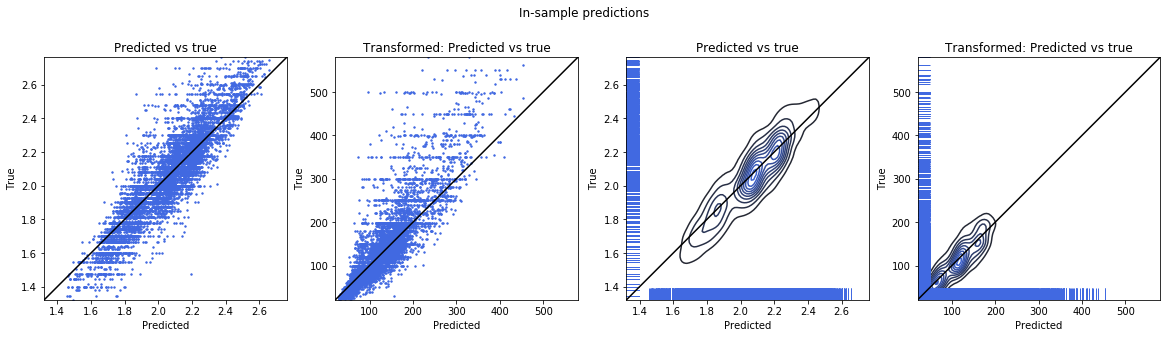

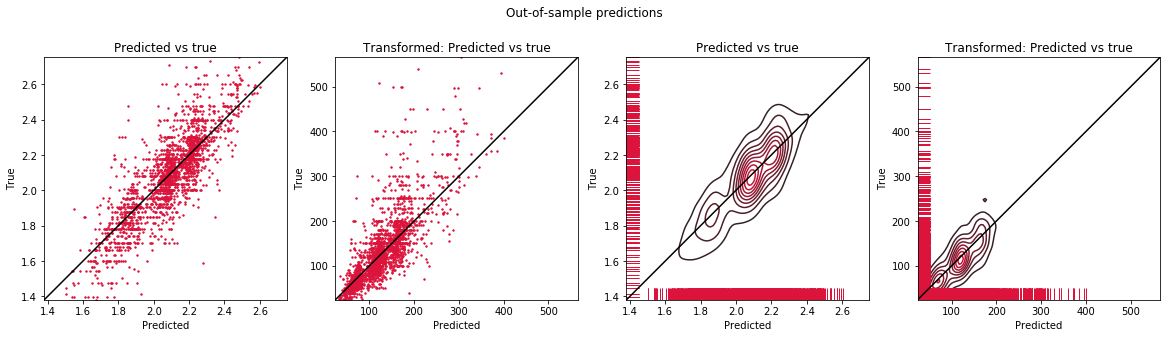

In [362]:
train_tpl = (X_train_100m, y_train_100m)
test_tpl = (X_test_100m, y_test_100m)
rf_100m = print_results('RF_100m.p', test_tpl, train_tpl, 'both', True)

In [363]:
best_params = rf_100m['fitted_model'].best_params_
best_params

{'n_estimators': 140,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20}

Feature importance

In [364]:
names = tuple(np.delete(train_100m.columns.values, 0))
values = tuple(rf_100m['fitted_model'].best_estimator_.feature_importances_)

fi_100m = pd.DataFrame(zip(names,values))
fi_100m.columns = ('Variable', 'Importance')
fi_100m

Variable  Importance
0              Air_log_price_100m_same_room_type    0.195930
1             Air_calculated_host_listings_count    0.027431
2                                  Air_bathrooms    0.049560
3                                       Air_beds    0.068292
4                                   Air_bedrooms    0.150884
5                               Air_accommodates    0.126911
6                               Air_extra_people    0.034544
7                            Air_guests_included    0.050526
8                            Air_distance_to_CBD    0.051392
9        Air_property_type_2_House_Cottage_Villa    0.016114
10                     Air_property_type_2_Other    0.009098
11                 Air_property_type_2_Townhouse    0.003523
12                    Air_room_type_Private room    0.142812
13                     Air_room_type_Shared room    0.014683
14            Air_cancellation_policy_2_moderate    0.004153
15              Air_cancellation_policy_2_strict    0.008017
16            Air_neighbourhood_cleansed_Bayside    0.000751
17         Air_neighbourhood_cleansed_Boroondara    0.000931
18           Air_neighbourhood_cleansed_Brimbank    0.000523
19           Air_neighbourhood_cleansed_Cardinia    0.000401
20              Air_neighbourhood_cleansed_Casey    0.000078
21            Air_neighbourhood_cleansed_Darebin    0.002790
22          Air_neighbourhood_cleansed_Frankston    0.000350
23          Air_neighbourhood_cleansed_Glen Eira    0.001418
24  Air_neighbourhood_cleansed_Greater Dandenong    0.000699
25        Air_neighbourhood_cleansed_Hobsons Bay    0.001202
26               Air_neighbourhood_cleansed_Hume    0.000894
27           Air_neighbourhood_cleansed_Kingston    0.000256
28               Air_neighbourhood_cleansed_Knox    0.000262
29         Air_neighbourhood_cleansed_Manningham    0.000964
30        Air_neighbourhood_cleansed_Maribyrnong    0.001409
31          Air_neighbourhood_cleansed_Maroondah    0.000121
32          Air_neighbourhood_cleansed_Melbourne    0.004588
33             Air_neighbourhood_cleansed_Melton    0.001268
34             Air_neighbourhood_cleansed_Monash    0.001581
35      Air_neighbourhood_cleansed_Moonee Valley    0.001483
36           Air_neighbourhood_cleansed_Moreland    0.003888
37          Air_neighbourhood_cleansed_Nillumbik    0.000039
38       Air_neighbourhood_cleansed_Port Phillip    0.004237
39        Air_neighbourhood_cleansed_Stonnington    0.003865
40         Air_neighbourhood_cleansed_Whitehorse    0.001692
41         Air_neighbourhood_cleansed_Whittlesea    0.000821
42            Air_neighbourhood_cleansed_Wyndham    0.001008
43              Air_neighbourhood_cleansed_Yarra    0.003052
44       Air_neighbourhood_cleansed_Yarra Ranges    0.005562

*Constructed aggregation - 50m*

`param_grid_rf_v2` is used for hyper-parameter optimization.

*This step is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.79 / RMSE train 0.11 / MAE train 0.08 / Nobs: 6522
R2 test: 0.68 / RMSE test 0.12 / MAE test 0.09 / Nobs: 1340

Transformed
-----------
R2 train: 0.70 / RMSE train 44.13 / MAE train 25.79 / Nobs: 6522
R2 test: 0.59 / RMSE test 46.71 / MAE test 29.16 / Nobs: 1340



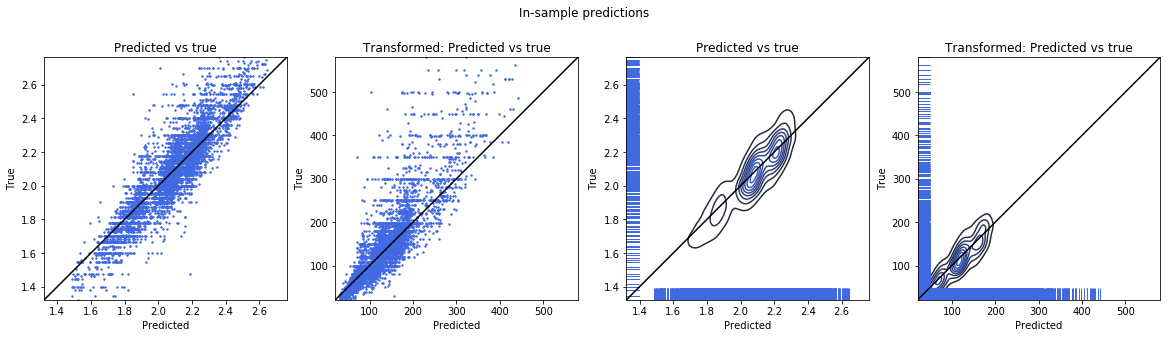

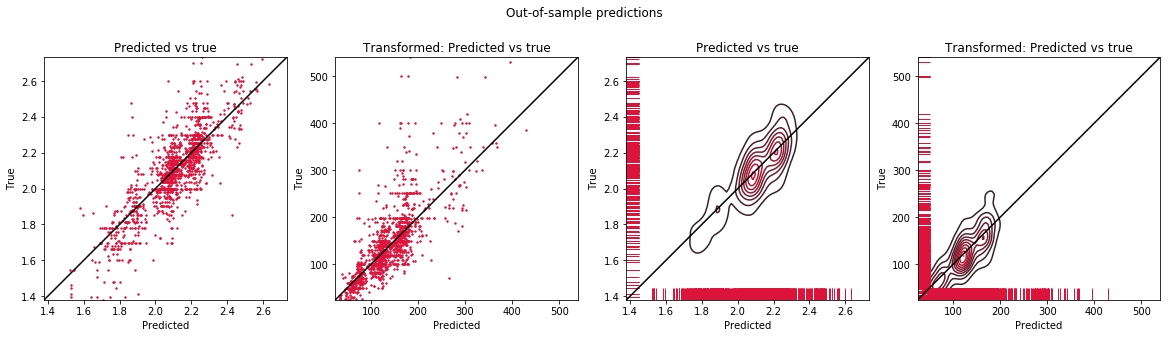

In [365]:
train_tpl = (X_train_50m, y_train_50m)
test_tpl = (X_test_50m, y_test_50m)
rf_50m = print_results('RF_50m.p', test_tpl, train_tpl, 'both', True)

In [366]:
best_params = rf_50m['fitted_model'].best_params_
best_params

{'n_estimators': 120,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20}

Feature importance

In [367]:
names = tuple(np.delete(train_50m.columns.values, 0))
values = tuple(rf_50m['fitted_model'].best_estimator_.feature_importances_)

fi_50m = pd.DataFrame(zip(names,values))
fi_50m.columns = ('Variable', 'Importance')
fi_50m

Variable  Importance
0               Air_log_price_50m_same_room_type    0.147638
1             Air_calculated_host_listings_count    0.030989
2                                  Air_bathrooms    0.050224
3                                       Air_beds    0.073479
4                                   Air_bedrooms    0.169894
5                               Air_accommodates    0.118003
6                               Air_extra_people    0.042272
7                            Air_guests_included    0.060633
8                            Air_distance_to_CBD    0.052835
9        Air_property_type_2_House_Cottage_Villa    0.017746
10                     Air_property_type_2_Other    0.011134
11                 Air_property_type_2_Townhouse    0.003949
12                    Air_room_type_Private room    0.145983
13                     Air_room_type_Shared room    0.022102
14            Air_cancellation_policy_2_moderate    0.003917
15              Air_cancellation_policy_2_strict    0.007631
16            Air_neighbourhood_cleansed_Bayside    0.000974
17         Air_neighbourhood_cleansed_Boroondara    0.000889
18           Air_neighbourhood_cleansed_Brimbank    0.000363
19           Air_neighbourhood_cleansed_Cardinia    0.000362
20              Air_neighbourhood_cleansed_Casey    0.000043
21            Air_neighbourhood_cleansed_Darebin    0.002611
22          Air_neighbourhood_cleansed_Frankston    0.000245
23          Air_neighbourhood_cleansed_Glen Eira    0.000602
24  Air_neighbourhood_cleansed_Greater Dandenong    0.000587
25        Air_neighbourhood_cleansed_Hobsons Bay    0.000843
26               Air_neighbourhood_cleansed_Hume    0.000620
27           Air_neighbourhood_cleansed_Kingston    0.000217
28               Air_neighbourhood_cleansed_Knox    0.000122
29         Air_neighbourhood_cleansed_Manningham    0.001132
30        Air_neighbourhood_cleansed_Maribyrnong    0.001531
31          Air_neighbourhood_cleansed_Maroondah    0.000297
32          Air_neighbourhood_cleansed_Melbourne    0.004878
33             Air_neighbourhood_cleansed_Melton    0.001320
34             Air_neighbourhood_cleansed_Monash    0.001296
35      Air_neighbourhood_cleansed_Moonee Valley    0.000900
36           Air_neighbourhood_cleansed_Moreland    0.003604
37          Air_neighbourhood_cleansed_Nillumbik    0.000032
38       Air_neighbourhood_cleansed_Port Phillip    0.004289
39        Air_neighbourhood_cleansed_Stonnington    0.004316
40         Air_neighbourhood_cleansed_Whitehorse    0.001471
41         Air_neighbourhood_cleansed_Whittlesea    0.001129
42            Air_neighbourhood_cleansed_Wyndham    0.000503
43              Air_neighbourhood_cleansed_Yarra    0.003355
44       Air_neighbourhood_cleansed_Yarra Ranges    0.003038

**5. Boosting**

In this section the two boosting algorithmns `AdaBoost` and `XGBoost` are investigated. Sklearn's `GradientBoostingRegressor` does not seem to perform well and is slow. It is only applied for the suburb example as a test. `StandardScaler()` is used upfront with the aim to speed up the optimization.

For `XGBoost` we use sklearn's wrappper interface. `eta` is in this set-up the learning rate. Building the trees can be randomized by the several parameters (https://stackoverflow.com/questions/51022822/subsample-colsample-bytree-colsample-bylevel-in-xgbclassifier-python-3-x, https://xgboost.readthedocs.io/en/latest/parameter.html):
- `subsample`: is the fraction of obervations that are used to train the model,
- `colsample_bytree`: is the fraction of features that are used to build each tree.
- `colsample_bynode`: is the fraction of features that are in each node.

There is also the parameter `colsample_bylevel`.

To speed up the optimization `RandomizedSearchCV()` is used instead of `GridSearchCV()`.

*Remark*: Retrieving the feature importance does not seem to work for `XGBoost` (https://datascience.stackexchange.com/questions/16008/how-to-determine-feature-importance-while-using-xgboost-in-pipeline).

The following grids are used:

In [368]:
# AdaBoost
# --------
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# Loss function
loss = ['linear', 'square', 'exponential']
# Learinign rate
learning_rate = np.logspace(start = -3, stop = 3, num = 7)

param_grid_ada = {'ada__n_estimators': n_estimators,
                  'ada__loss': loss,
                  'ada__learning_rate': learning_rate}
print(param_grid_ada)

# XGBoost
# -------
#'xgb__learning_rate': [0.01, 0.02, 0.05, 0.1 ],
param_grid_xgb = {'xgb__eta': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                  'xgb__max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
                  'xgb__min_child_weight' : [ 1, 3, 5, 7 ],
                  'xgb__gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                  'xgb__colsample_bytree': [0.3, 0.5, 0.7, 1]}
print(param_grid_xgb)

# Gradient Boosting
# -----------------
# Loss function
loss = ['ls', 'lad', 'huber', 'quantile']

# Learinign rate
learning_rate = np.logspace(start = -3, stop = 3, num = 7)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10] 

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

param_grid_gb = {'gb__loss': loss,
                 'gb__learning_rate': learning_rate,
                 'gb__n_estimators': n_estimators,
                 'gb__min_samples_split': min_samples_split,
                 'gb__max_depth': max_depth,
                 'gb__max_features': max_features}
param_grid_gb

{'ada__n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'ada__loss': ['linear', 'square', 'exponential'], 'ada__learning_rate': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}
{'xgb__eta': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'xgb__max_depth': [3, 4, 5, 6, 8, 10, 12, 15], 'xgb__min_child_weight': [1, 3, 5, 7], 'xgb__gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'xgb__colsample_bytree': [0.3, 0.5, 0.7, 1]}


{'gb__loss': ['ls', 'lad', 'huber', 'quantile'],
 'gb__learning_rate': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'gb__n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
 'gb__min_samples_split': [2, 5, 10],
 'gb__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'gb__max_features': ['auto', 'sqrt', 'log2']}

*Aggregation by Suburbs*

AdaBoost

*This step is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.58 / RMSE train 0.17 / MAE train 0.13 / Nobs: 14261
R2 test: 0.59 / RMSE test 0.17 / MAE test 0.13 / Nobs: 4451

Transformed
-----------
R2 train: 0.47 / RMSE train 63.08 / MAE train 39.14 / Nobs: 14261
R2 test: 0.49 / RMSE test 61.15 / MAE test 38.45 / Nobs: 4451



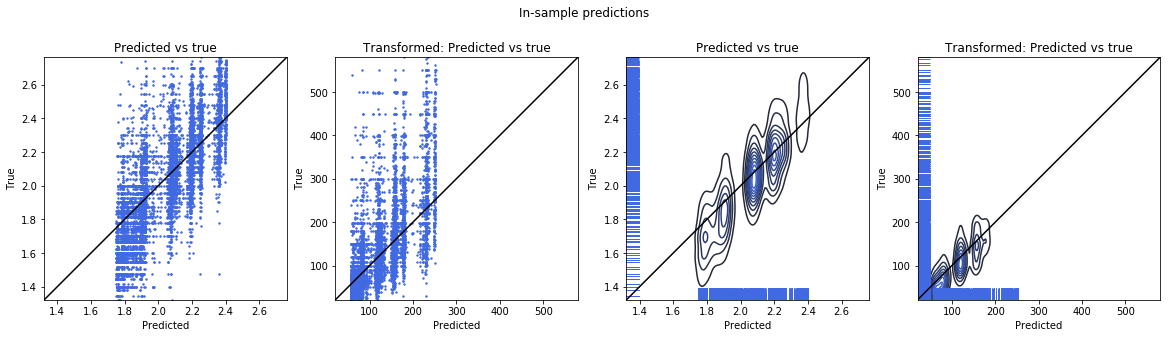

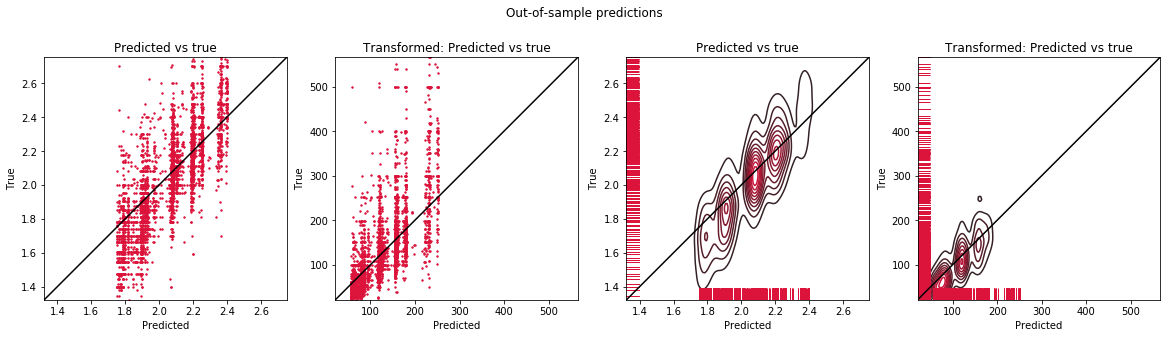

In [369]:
train_tpl = (X_train_suburb, y_train_suburb)
test_tpl = (X_test_suburb, y_test_suburb)
ada_suburb = print_results('Ada_suburbs.p', test_tpl, train_tpl, 'both', True)

In [370]:
best_params = ada_suburb['fitted_model'].best_params_
best_params

{'ada__n_estimators': 100,
 'ada__loss': 'exponential',
 'ada__learning_rate': 0.1}

Feature importance

In [371]:
names = tuple(np.delete(train_suburb.columns.values, 0))
values = tuple(ada_suburb['fitted_model'].best_estimator_.named_steps['ada'].feature_importances_)

fi_suburb = pd.DataFrame(zip(names,values))
fi_suburb.columns = ('Variable', 'Importance')
fi_suburb

Variable  Importance
0            Air_log_price_suburb_same_room_type    0.652078
1             Air_calculated_host_listings_count    0.011896
2                                  Air_bathrooms    0.049620
3                                       Air_beds    0.009021
4                                   Air_bedrooms    0.101116
5                               Air_accommodates    0.078223
6                               Air_extra_people    0.040450
7                            Air_guests_included    0.010855
8                            Air_distance_to_CBD    0.027919
9        Air_property_type_2_House_Cottage_Villa    0.000374
10                     Air_property_type_2_Other    0.001882
11                 Air_property_type_2_Townhouse    0.000995
12                    Air_room_type_Private room    0.000000
13                     Air_room_type_Shared room    0.008898
14            Air_cancellation_policy_2_moderate    0.000000
15              Air_cancellation_policy_2_strict    0.001414
16            Air_neighbourhood_cleansed_Bayside    0.000000
17         Air_neighbourhood_cleansed_Boroondara    0.000000
18           Air_neighbourhood_cleansed_Brimbank    0.000000
19           Air_neighbourhood_cleansed_Cardinia    0.000000
20              Air_neighbourhood_cleansed_Casey    0.000000
21            Air_neighbourhood_cleansed_Darebin    0.000000
22          Air_neighbourhood_cleansed_Frankston    0.000000
23          Air_neighbourhood_cleansed_Glen Eira    0.000000
24  Air_neighbourhood_cleansed_Greater Dandenong    0.000000
25        Air_neighbourhood_cleansed_Hobsons Bay    0.000000
26               Air_neighbourhood_cleansed_Hume    0.000000
27           Air_neighbourhood_cleansed_Kingston    0.000000
28               Air_neighbourhood_cleansed_Knox    0.000000
29         Air_neighbourhood_cleansed_Manningham    0.000000
30        Air_neighbourhood_cleansed_Maribyrnong    0.000000
31          Air_neighbourhood_cleansed_Maroondah    0.000000
32          Air_neighbourhood_cleansed_Melbourne    0.000000
33             Air_neighbourhood_cleansed_Melton    0.000508
34             Air_neighbourhood_cleansed_Monash    0.000000
35      Air_neighbourhood_cleansed_Moonee Valley    0.000000
36           Air_neighbourhood_cleansed_Moreland    0.000000
37          Air_neighbourhood_cleansed_Nillumbik    0.000000
38       Air_neighbourhood_cleansed_Port Phillip    0.000000
39        Air_neighbourhood_cleansed_Stonnington    0.000483
40         Air_neighbourhood_cleansed_Whitehorse    0.000000
41         Air_neighbourhood_cleansed_Whittlesea    0.000000
42            Air_neighbourhood_cleansed_Wyndham    0.001547
43              Air_neighbourhood_cleansed_Yarra    0.001396
44       Air_neighbourhood_cleansed_Yarra Ranges    0.001324

*XGBoost*

*This step is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.73 / RMSE train 0.14 / MAE train 0.10 / Nobs: 14261
R2 test: 0.66 / RMSE test 0.16 / MAE test 0.12 / Nobs: 4451

Transformed
-----------
R2 train: 0.64 / RMSE train 51.55 / MAE train 30.32 / Nobs: 14261
R2 test: 0.55 / RMSE test 57.69 / MAE test 34.86 / Nobs: 4451



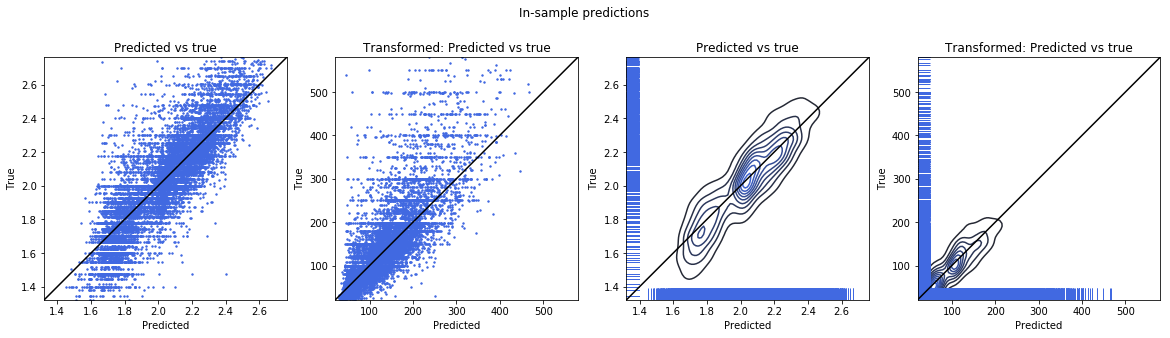

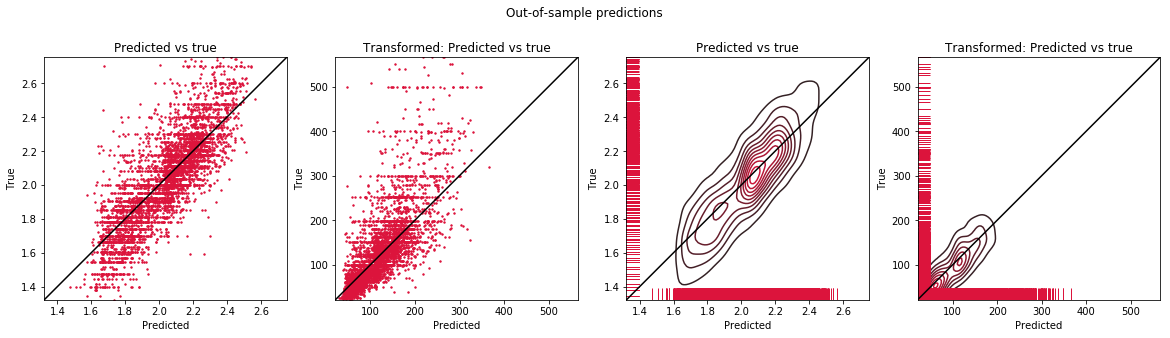

In [372]:
train_tpl = (X_train_suburb, y_train_suburb)
test_tpl = (X_test_suburb, y_test_suburb)
xgb_suburb = print_results('XGB_suburbs.p', test_tpl, train_tpl, 'both', True)

In [373]:
best_params = xgb_suburb['fitted_model'].best_params_
best_params

{'xgb__min_child_weight': 7,
 'xgb__max_depth': 3,
 'xgb__gamma': 0.3,
 'xgb__eta': 0.25,
 'xgb__colsample_bytree': 0.3}

Feature importance (not working)

Hyper-parameter patterns

In [374]:
min_child_weight = np.array(xgb_suburb['fitted_model'].cv_results_['param_xgb__min_child_weight'])
max_depth = np.array(xgb_suburb['fitted_model'].cv_results_['param_xgb__max_depth'])
gamma = np.array(xgb_suburb['fitted_model'].cv_results_['param_xgb__gamma'])
eta = np.array(xgb_suburb['fitted_model'].cv_results_['param_xgb__eta'])
colsample_bytree = np.array(xgb_suburb['fitted_model'].cv_results_['param_xgb__colsample_bytree'])
mean_test_score = np.array(xgb_suburb['fitted_model'].cv_results_['mean_test_score'])

df = pd.DataFrame(data={'min_child_weight': min_child_weight,
                        'max_depth': max_depth,
                        #'learning_rate': learning_rate,
                        'gamma': gamma,
                        'eta': eta,
                        'colsample_bytree': colsample_bytree,
                        'mean_test_score': mean_test_score})
df = df.sort_values(by='mean_test_score', ascending=False)

In [375]:
df.head(10)

min_child_weight max_depth gamma   eta colsample_bytree  mean_test_score
21                7         3   0.3  0.25              0.3         0.609758
9                 1         4   0.3  0.15              0.3         0.607183
10                5         4   0.2  0.25              0.3         0.606978
19                5         3   0.1   0.1              0.3         0.603239
20                3         4   0.4  0.25              0.3         0.599728
1                 1         3     0   0.3              0.5         0.587441
37                3         4     0   0.1              0.5         0.577438
7                 3         5   0.1   0.1              0.3         0.576363
31                1         4   0.3  0.15              0.5         0.563904
8                 3         6   0.3   0.2              0.3         0.551558

In [376]:
df.tail(10)

min_child_weight max_depth gamma   eta colsample_bytree  mean_test_score
26                7         5   0.1   0.3                1         0.162229
6                 1        12   0.1   0.1              0.5         0.153108
46                1        15   0.4   0.3                1         0.140034
47                7        15   0.3   0.3                1         0.101599
35                5        12   0.2   0.1                1         0.083019
29                5        12     0  0.05              0.5         0.019498
41                5        12   0.1  0.15              0.7        -0.017318
4                 7        10   0.1  0.15                1        -0.037604
17                3        15   0.1   0.3              0.7        -0.106239
33                5        15     0  0.05              0.7        -0.344520

The fit is worse when `max_depth` and `colsample_bytree` is large. A high learning rate `eta` increases the fit.

In [377]:
X = df.loc[:, ['min_child_weight', 'max_depth', 'gamma', 'eta', 'colsample_bytree']]
y = df.loc[:, ['mean_test_score']]
X = sm.add_constant(X)
xgb_results = sm.OLS(y, X.astype(float)).fit()
print(xgb_results.summary())

                            OLS Regression Results                            
Dep. Variable:        mean_test_score   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     50.35
Date:                Wed, 08 Jul 2020   Prob (F-statistic):           4.18e-17
Time:                        19:22:35   Log-Likelihood:                 54.735
No. Observations:                  50   AIC:                            -97.47
Df Residuals:                      44   BIC:                            -86.00
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7350      0.048  

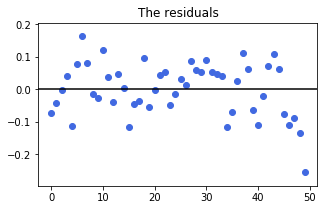

In [378]:
mean = np.mean(xgb_results.resid)
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.scatter(x=range(xgb_results.resid.shape[0]), y=xgb_results.resid, alpha=1, color=col1)
ax.axhline(mean, color="black")
ax.set_title("The residuals");

Gradient Boosting (bad performance, not considered for the other aggregations)

The algorithm is very slow so that only 10 random samples of hyper-parameter combinations are considered.

*This step is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.65 / RMSE train 0.16 / MAE train 0.13 / Nobs: 14261
R2 test: 0.43 / RMSE test 0.20 / MAE test 0.16 / Nobs: 4451

Transformed
-----------
R2 train: 0.47 / RMSE train 62.96 / MAE train 37.92 / Nobs: 14261
R2 test: 0.30 / RMSE test 71.57 / MAE test 45.60 / Nobs: 4451



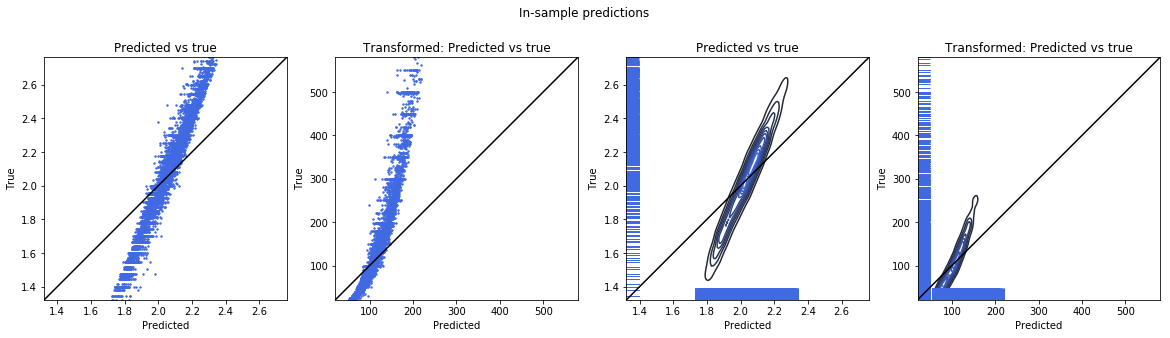

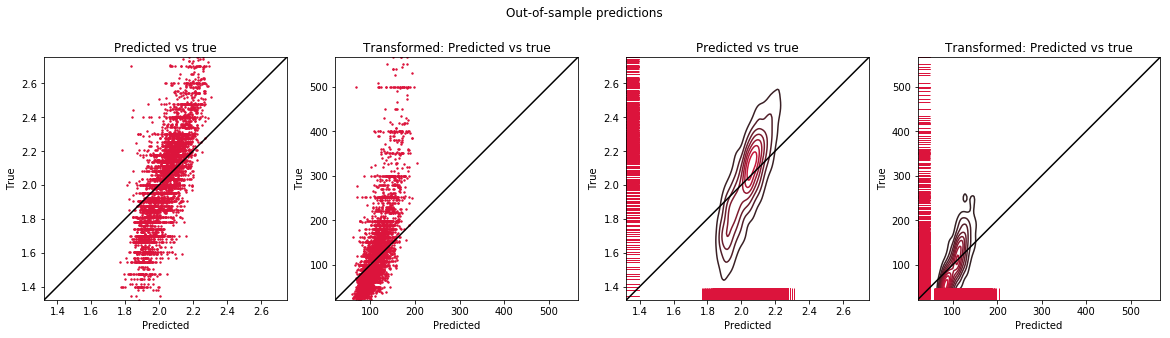

In [379]:
train_tpl = (X_train_suburb, y_train_suburb)
test_tpl = (X_test_suburb, y_test_suburb)
gb_suburb = print_results('GB_suburbs.p', test_tpl, train_tpl, 'both', True)

In [380]:
best_params = gb_suburb['fitted_model'].best_params_
best_params

{'gb__n_estimators': 60,
 'gb__min_samples_split': 2,
 'gb__max_features': 'log2',
 'gb__max_depth': 100,
 'gb__loss': 'ls',
 'gb__learning_rate': 0.01}

Feature importance

In [381]:
names = tuple(np.delete(train_suburb.columns.values, 0))
values = tuple(gb_suburb['fitted_model'].best_estimator_.named_steps['gb'].feature_importances_)

fi_suburb = pd.DataFrame(zip(names,values))
fi_suburb.columns = ('Variable', 'Importance')
fi_suburb

Variable  Importance
0            Air_log_price_suburb_same_room_type    0.244436
1             Air_calculated_host_listings_count    0.032123
2                                  Air_bathrooms    0.039486
3                                       Air_beds    0.056874
4                                   Air_bedrooms    0.110083
5                               Air_accommodates    0.106749
6                               Air_extra_people    0.039766
7                            Air_guests_included    0.040263
8                            Air_distance_to_CBD    0.092482
9        Air_property_type_2_House_Cottage_Villa    0.015434
10                     Air_property_type_2_Other    0.008597
11                 Air_property_type_2_Townhouse    0.004731
12                    Air_room_type_Private room    0.109847
13                     Air_room_type_Shared room    0.010498
14            Air_cancellation_policy_2_moderate    0.008224
15              Air_cancellation_policy_2_strict    0.014394
16            Air_neighbourhood_cleansed_Bayside    0.001963
17         Air_neighbourhood_cleansed_Boroondara    0.002236
18           Air_neighbourhood_cleansed_Brimbank    0.001386
19           Air_neighbourhood_cleansed_Cardinia    0.000911
20              Air_neighbourhood_cleansed_Casey    0.000949
21            Air_neighbourhood_cleansed_Darebin    0.002595
22          Air_neighbourhood_cleansed_Frankston    0.001163
23          Air_neighbourhood_cleansed_Glen Eira    0.002353
24  Air_neighbourhood_cleansed_Greater Dandenong    0.000892
25        Air_neighbourhood_cleansed_Hobsons Bay    0.001647
26               Air_neighbourhood_cleansed_Hume    0.001673
27           Air_neighbourhood_cleansed_Kingston    0.001485
28               Air_neighbourhood_cleansed_Knox    0.001123
29         Air_neighbourhood_cleansed_Manningham    0.001708
30        Air_neighbourhood_cleansed_Maribyrnong    0.001748
31          Air_neighbourhood_cleansed_Maroondah    0.001145
32          Air_neighbourhood_cleansed_Melbourne    0.006619
33             Air_neighbourhood_cleansed_Melton    0.001102
34             Air_neighbourhood_cleansed_Monash    0.002385
35      Air_neighbourhood_cleansed_Moonee Valley    0.001910
36           Air_neighbourhood_cleansed_Moreland    0.003374
37          Air_neighbourhood_cleansed_Nillumbik    0.000545
38       Air_neighbourhood_cleansed_Port Phillip    0.005442
39        Air_neighbourhood_cleansed_Stonnington    0.003688
40         Air_neighbourhood_cleansed_Whitehorse    0.002270
41         Air_neighbourhood_cleansed_Whittlesea    0.001570
42            Air_neighbourhood_cleansed_Wyndham    0.002962
43              Air_neighbourhood_cleansed_Yarra    0.003470
44       Air_neighbourhood_cleansed_Yarra Ranges    0.005700

*Constructed aggregation - 500m*

AdaBoost

*This step is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.59 / RMSE train 0.17 / MAE train 0.13 / Nobs: 13230
R2 test: 0.59 / RMSE test 0.17 / MAE test 0.13 / Nobs: 3739

Transformed
-----------
R2 train: 0.47 / RMSE train 62.45 / MAE train 38.84 / Nobs: 13230
R2 test: 0.47 / RMSE test 62.25 / MAE test 38.42 / Nobs: 3739



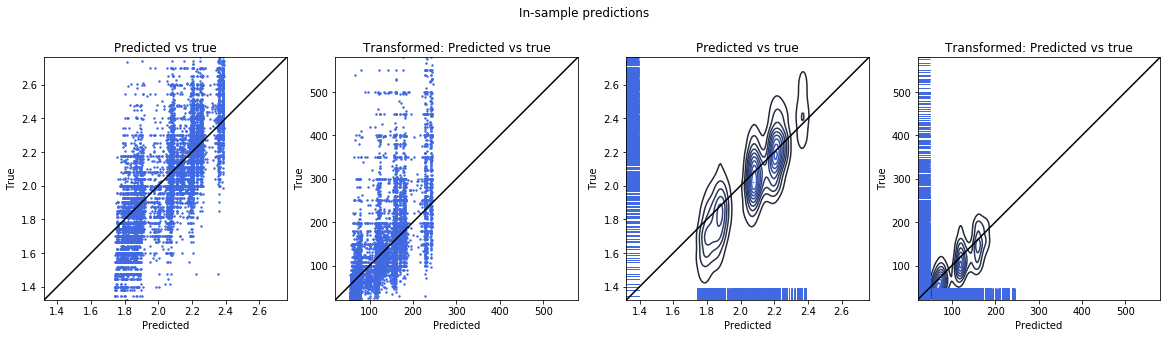

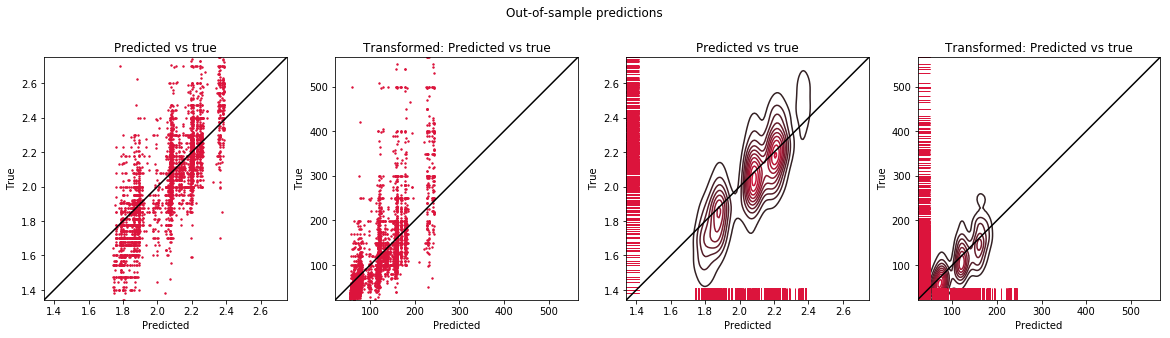

In [382]:
train_tpl = (X_train_500m, y_train_500m)
test_tpl = (X_test_500m, y_test_500m)
ada_500m = print_results('Ada_500m.p', test_tpl, train_tpl, 'both', True)

In [383]:
best_params = ada_500m['fitted_model'].best_params_
best_params

{'ada__n_estimators': 100,
 'ada__loss': 'exponential',
 'ada__learning_rate': 0.1}

In [384]:
names = tuple(np.delete(train_500m.columns.values, 0))
values = tuple(ada_500m['fitted_model'].best_estimator_.named_steps['ada'].feature_importances_)

fi_500m = pd.DataFrame(zip(names,values))
fi_500m.columns = ('Variable', 'Importance')
fi_500m

Variable  Importance
0              Air_log_price_500m_same_room_type    0.595365
1             Air_calculated_host_listings_count    0.019116
2                                  Air_bathrooms    0.041588
3                                       Air_beds    0.006979
4                                   Air_bedrooms    0.103644
5                               Air_accommodates    0.128927
6                               Air_extra_people    0.020875
7                            Air_guests_included    0.013145
8                            Air_distance_to_CBD    0.044578
9        Air_property_type_2_House_Cottage_Villa    0.000231
10                     Air_property_type_2_Other    0.002430
11                 Air_property_type_2_Townhouse    0.000425
12                    Air_room_type_Private room    0.007487
13                     Air_room_type_Shared room    0.001940
14            Air_cancellation_policy_2_moderate    0.000000
15              Air_cancellation_policy_2_strict    0.000159
16            Air_neighbourhood_cleansed_Bayside    0.000000
17         Air_neighbourhood_cleansed_Boroondara    0.000000
18           Air_neighbourhood_cleansed_Brimbank    0.000000
19           Air_neighbourhood_cleansed_Cardinia    0.000000
20              Air_neighbourhood_cleansed_Casey    0.000000
21            Air_neighbourhood_cleansed_Darebin    0.000000
22          Air_neighbourhood_cleansed_Frankston    0.000000
23          Air_neighbourhood_cleansed_Glen Eira    0.000212
24  Air_neighbourhood_cleansed_Greater Dandenong    0.000000
25        Air_neighbourhood_cleansed_Hobsons Bay    0.000000
26               Air_neighbourhood_cleansed_Hume    0.000000
27           Air_neighbourhood_cleansed_Kingston    0.000095
28               Air_neighbourhood_cleansed_Knox    0.000000
29         Air_neighbourhood_cleansed_Manningham    0.000000
30        Air_neighbourhood_cleansed_Maribyrnong    0.000000
31          Air_neighbourhood_cleansed_Maroondah    0.000000
32          Air_neighbourhood_cleansed_Melbourne    0.000000
33             Air_neighbourhood_cleansed_Melton    0.000619
34             Air_neighbourhood_cleansed_Monash    0.000007
35      Air_neighbourhood_cleansed_Moonee Valley    0.000000
36           Air_neighbourhood_cleansed_Moreland    0.000000
37          Air_neighbourhood_cleansed_Nillumbik    0.000000
38       Air_neighbourhood_cleansed_Port Phillip    0.000615
39        Air_neighbourhood_cleansed_Stonnington    0.000502
40         Air_neighbourhood_cleansed_Whitehorse    0.000000
41         Air_neighbourhood_cleansed_Whittlesea    0.000000
42            Air_neighbourhood_cleansed_Wyndham    0.000000
43              Air_neighbourhood_cleansed_Yarra    0.000813
44       Air_neighbourhood_cleansed_Yarra Ranges    0.010247

XGBoost

*This step is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.77 / RMSE train 0.13 / MAE train 0.09 / Nobs: 13230
R2 test: 0.71 / RMSE test 0.14 / MAE test 0.10 / Nobs: 3739

Transformed
-----------
R2 train: 0.70 / RMSE train 47.36 / MAE train 28.31 / Nobs: 13230
R2 test: 0.63 / RMSE test 52.10 / MAE test 31.18 / Nobs: 3739



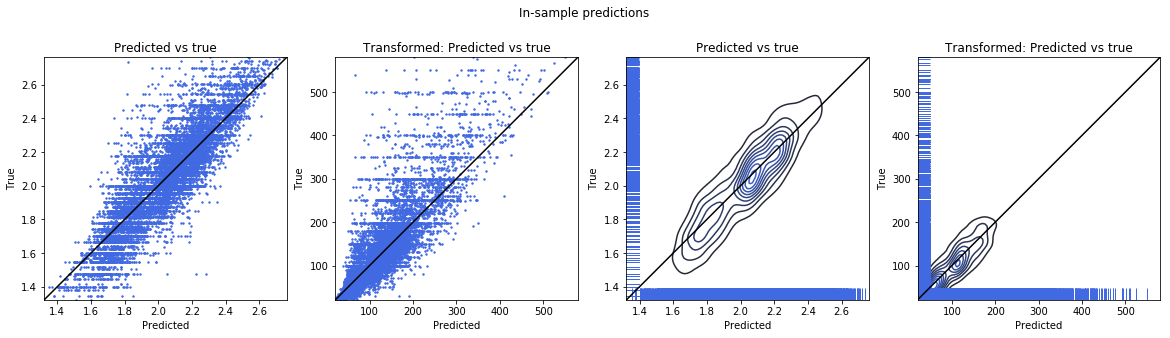

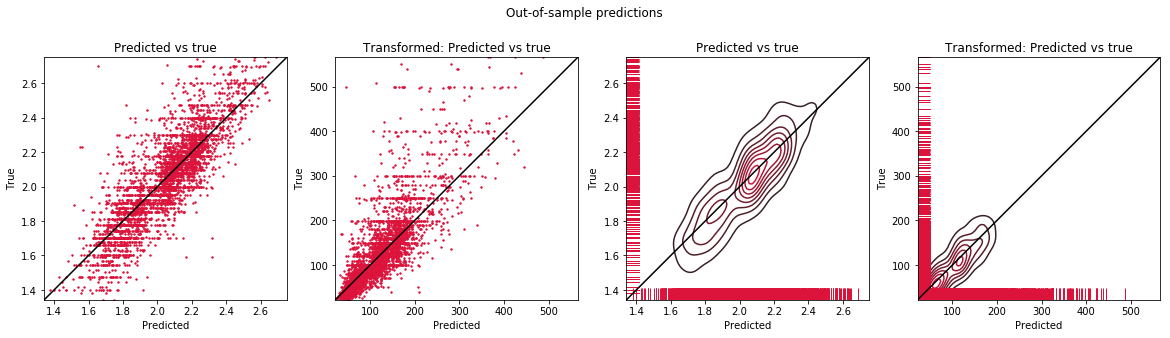

In [385]:
train_tpl = (X_train_500m, y_train_500m)
test_tpl = (X_test_500m, y_test_500m)
xgb_500m = print_results('XGB_500m.p', test_tpl, train_tpl, 'both', True)

In [386]:
best_params = xgb_500m['fitted_model'].best_params_
best_params

{'xgb__min_child_weight': 7,
 'xgb__max_depth': 8,
 'xgb__gamma': 0.0,
 'xgb__eta': 0.05,
 'xgb__colsample_bytree': 0.3}

*Constructed aggregation - 100m*

Ada Boost

*This step is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.58 / RMSE train 0.16 / MAE train 0.12 / Nobs: 9203
R2 test: 0.60 / RMSE test 0.15 / MAE test 0.11 / Nobs: 2177

Transformed
-----------
R2 train: 0.45 / RMSE train 61.71 / MAE train 37.56 / Nobs: 9203
R2 test: 0.48 / RMSE test 55.59 / MAE test 35.24 / Nobs: 2177



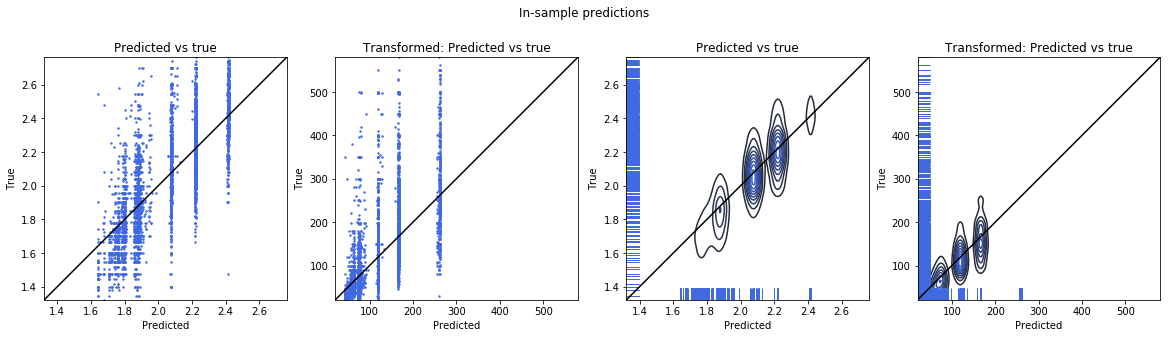

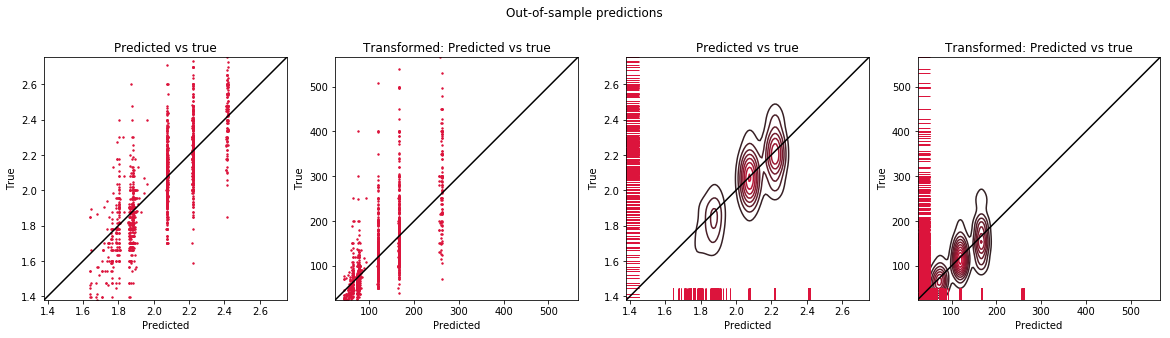

In [387]:
train_tpl = (X_train_100m, y_train_100m)
test_tpl = (X_test_100m, y_test_100m)
ada_100m = print_results('Ada_100m.p', test_tpl, train_tpl, 'both', True)

In [388]:
best_params = ada_100m['fitted_model'].best_params_
best_params

{'ada__n_estimators': 180, 'ada__loss': 'linear', 'ada__learning_rate': 0.01}

Feature importance

In [389]:
names = tuple(np.delete(train_100m.columns.values, 0))
values = tuple(ada_suburb['fitted_model'].best_estimator_.named_steps['ada'].feature_importances_)

fi_100m = pd.DataFrame(zip(names,values))
fi_100m.columns = ('Variable', 'Importance')
fi_100m

Variable  Importance
0              Air_log_price_100m_same_room_type    0.652078
1             Air_calculated_host_listings_count    0.011896
2                                  Air_bathrooms    0.049620
3                                       Air_beds    0.009021
4                                   Air_bedrooms    0.101116
5                               Air_accommodates    0.078223
6                               Air_extra_people    0.040450
7                            Air_guests_included    0.010855
8                            Air_distance_to_CBD    0.027919
9        Air_property_type_2_House_Cottage_Villa    0.000374
10                     Air_property_type_2_Other    0.001882
11                 Air_property_type_2_Townhouse    0.000995
12                    Air_room_type_Private room    0.000000
13                     Air_room_type_Shared room    0.008898
14            Air_cancellation_policy_2_moderate    0.000000
15              Air_cancellation_policy_2_strict    0.001414
16            Air_neighbourhood_cleansed_Bayside    0.000000
17         Air_neighbourhood_cleansed_Boroondara    0.000000
18           Air_neighbourhood_cleansed_Brimbank    0.000000
19           Air_neighbourhood_cleansed_Cardinia    0.000000
20              Air_neighbourhood_cleansed_Casey    0.000000
21            Air_neighbourhood_cleansed_Darebin    0.000000
22          Air_neighbourhood_cleansed_Frankston    0.000000
23          Air_neighbourhood_cleansed_Glen Eira    0.000000
24  Air_neighbourhood_cleansed_Greater Dandenong    0.000000
25        Air_neighbourhood_cleansed_Hobsons Bay    0.000000
26               Air_neighbourhood_cleansed_Hume    0.000000
27           Air_neighbourhood_cleansed_Kingston    0.000000
28               Air_neighbourhood_cleansed_Knox    0.000000
29         Air_neighbourhood_cleansed_Manningham    0.000000
30        Air_neighbourhood_cleansed_Maribyrnong    0.000000
31          Air_neighbourhood_cleansed_Maroondah    0.000000
32          Air_neighbourhood_cleansed_Melbourne    0.000000
33             Air_neighbourhood_cleansed_Melton    0.000508
34             Air_neighbourhood_cleansed_Monash    0.000000
35      Air_neighbourhood_cleansed_Moonee Valley    0.000000
36           Air_neighbourhood_cleansed_Moreland    0.000000
37          Air_neighbourhood_cleansed_Nillumbik    0.000000
38       Air_neighbourhood_cleansed_Port Phillip    0.000000
39        Air_neighbourhood_cleansed_Stonnington    0.000483
40         Air_neighbourhood_cleansed_Whitehorse    0.000000
41         Air_neighbourhood_cleansed_Whittlesea    0.000000
42            Air_neighbourhood_cleansed_Wyndham    0.001547
43              Air_neighbourhood_cleansed_Yarra    0.001396
44       Air_neighbourhood_cleansed_Yarra Ranges    0.001324

XGBoost

Untransformed
-------------
R2 train: 0.78 / RMSE train 0.12 / MAE train 0.09 / Nobs: 9203
R2 test: 0.68 / RMSE test 0.13 / MAE test 0.10 / Nobs: 2177

Transformed
-----------
R2 train: 0.70 / RMSE train 45.04 / MAE train 27.37 / Nobs: 9203
R2 test: 0.60 / RMSE test 48.65 / MAE test 30.13 / Nobs: 2177



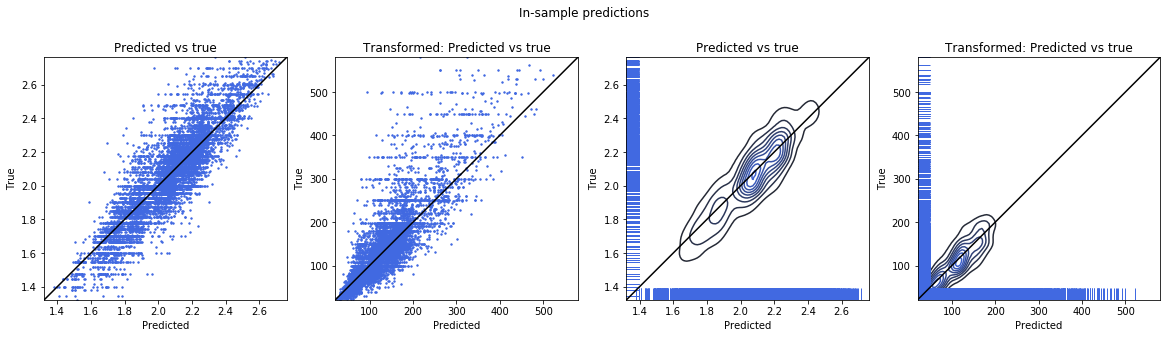

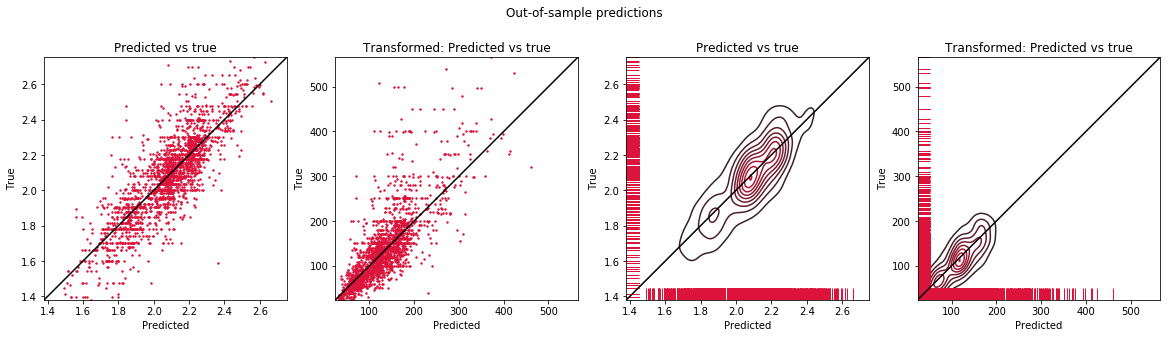

In [390]:
train_tpl = (X_train_100m, y_train_100m)
test_tpl = (X_test_100m, y_test_100m)
xgb_100m = print_results('XGB_100m.p', test_tpl, train_tpl, 'both', True)

In [391]:
best_params = xgb_100m['fitted_model'].best_params_
best_params

{'xgb__min_child_weight': 1,
 'xgb__max_depth': 12,
 'xgb__gamma': 0.1,
 'xgb__eta': 0.1,
 'xgb__colsample_bytree': 0.5}

*Constructed aggregation - 50m*

Ada Boost

*This step is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.56 / RMSE train 0.15 / MAE train 0.11 / Nobs: 6522
R2 test: 0.60 / RMSE test 0.14 / MAE test 0.10 / Nobs: 1340

Transformed
-----------
R2 train: 0.42 / RMSE train 61.38 / MAE train 37.04 / Nobs: 6522
R2 test: 0.47 / RMSE test 52.96 / MAE test 33.70 / Nobs: 1340



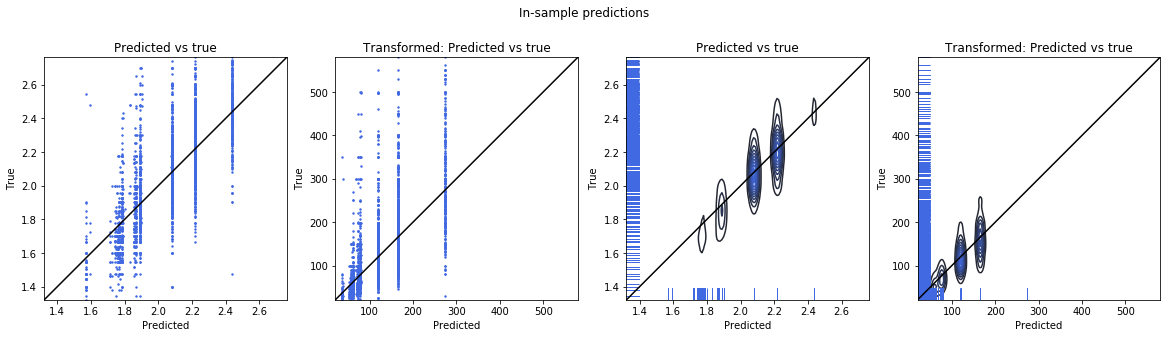

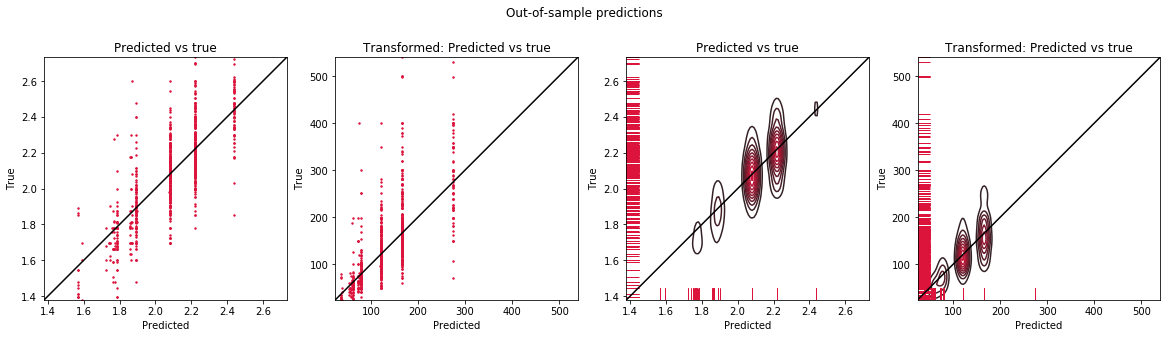

In [392]:
train_tpl = (X_train_50m, y_train_50m)
test_tpl = (X_test_50m, y_test_50m)
ada_50m = print_results('Ada_50m.p', test_tpl, train_tpl, 'both', True)

In [393]:
best_params = ada_50m['fitted_model'].best_params_
best_params

{'ada__n_estimators': 20, 'ada__loss': 'square', 'ada__learning_rate': 0.01}

Feature importance

In [394]:
names = tuple(np.delete(train_50m.columns.values, 0))
values = tuple(ada_50m['fitted_model'].best_estimator_.named_steps['ada'].feature_importances_)

fi_50m = pd.DataFrame(zip(names,values))
fi_50m.columns = ('Variable', 'Importance')
fi_50m

Variable  Importance
0               Air_log_price_50m_same_room_type    0.026413
1             Air_calculated_host_listings_count    0.000124
2                                  Air_bathrooms    0.000000
3                                       Air_beds    0.000577
4                                   Air_bedrooms    0.303180
5                               Air_accommodates    0.014366
6                               Air_extra_people    0.005709
7                            Air_guests_included    0.000547
8                            Air_distance_to_CBD    0.007910
9        Air_property_type_2_House_Cottage_Villa    0.006255
10                     Air_property_type_2_Other    0.000000
11                 Air_property_type_2_Townhouse    0.000000
12                    Air_room_type_Private room    0.579526
13                     Air_room_type_Shared room    0.054795
14            Air_cancellation_policy_2_moderate    0.000000
15              Air_cancellation_policy_2_strict    0.000000
16            Air_neighbourhood_cleansed_Bayside    0.000000
17         Air_neighbourhood_cleansed_Boroondara    0.000000
18           Air_neighbourhood_cleansed_Brimbank    0.000000
19           Air_neighbourhood_cleansed_Cardinia    0.000000
20              Air_neighbourhood_cleansed_Casey    0.000000
21            Air_neighbourhood_cleansed_Darebin    0.000000
22          Air_neighbourhood_cleansed_Frankston    0.000000
23          Air_neighbourhood_cleansed_Glen Eira    0.000000
24  Air_neighbourhood_cleansed_Greater Dandenong    0.000000
25        Air_neighbourhood_cleansed_Hobsons Bay    0.000000
26               Air_neighbourhood_cleansed_Hume    0.000000
27           Air_neighbourhood_cleansed_Kingston    0.000000
28               Air_neighbourhood_cleansed_Knox    0.000000
29         Air_neighbourhood_cleansed_Manningham    0.000598
30        Air_neighbourhood_cleansed_Maribyrnong    0.000000
31          Air_neighbourhood_cleansed_Maroondah    0.000000
32          Air_neighbourhood_cleansed_Melbourne    0.000000
33             Air_neighbourhood_cleansed_Melton    0.000000
34             Air_neighbourhood_cleansed_Monash    0.000000
35      Air_neighbourhood_cleansed_Moonee Valley    0.000000
36           Air_neighbourhood_cleansed_Moreland    0.000000
37          Air_neighbourhood_cleansed_Nillumbik    0.000000
38       Air_neighbourhood_cleansed_Port Phillip    0.000000
39        Air_neighbourhood_cleansed_Stonnington    0.000000
40         Air_neighbourhood_cleansed_Whitehorse    0.000000
41         Air_neighbourhood_cleansed_Whittlesea    0.000000
42            Air_neighbourhood_cleansed_Wyndham    0.000000
43              Air_neighbourhood_cleansed_Yarra    0.000000
44       Air_neighbourhood_cleansed_Yarra Ranges    0.000000

XGBoost

*This step is time consuming and thus set to Raw*

Untransformed
-------------
R2 train: 0.76 / RMSE train 0.11 / MAE train 0.08 / Nobs: 6522
R2 test: 0.68 / RMSE test 0.12 / MAE test 0.09 / Nobs: 1340

Transformed
-----------
R2 train: 0.69 / RMSE train 45.05 / MAE train 26.65 / Nobs: 6522
R2 test: 0.60 / RMSE test 46.15 / MAE test 28.56 / Nobs: 1340



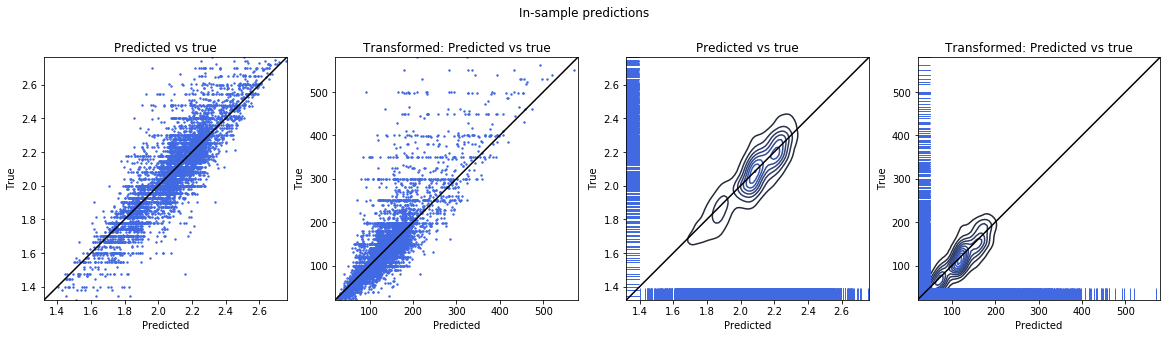

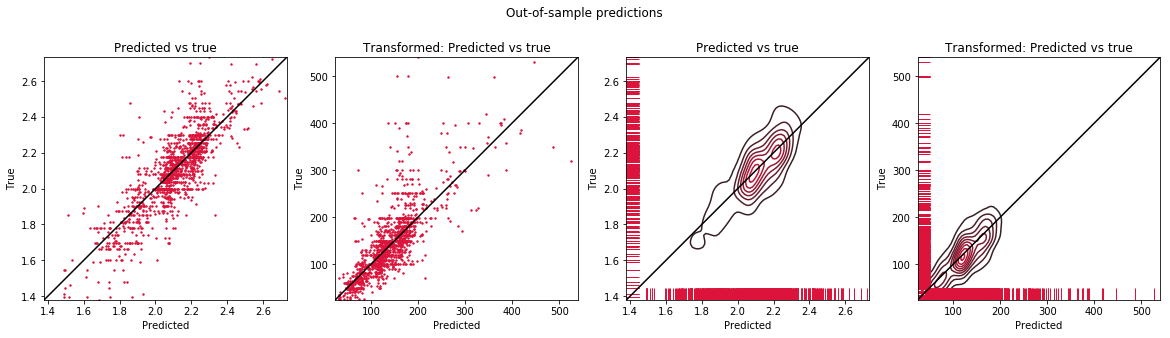

In [395]:
train_tpl = (X_train_50m, y_train_50m)
test_tpl = (X_test_50m, y_test_50m)
xgb_50m = print_results('XGB_50m.p', test_tpl, train_tpl, 'both', True)

In [396]:
best_params = xgb_50m['fitted_model'].best_params_
best_params

{'xgb__min_child_weight': 7,
 'xgb__max_depth': 8,
 'xgb__gamma': 0.0,
 'xgb__eta': 0.05,
 'xgb__colsample_bytree': 0.3}

#### Summary

Let's plot the $R^2$-scores RMSE and MAE of the different model. For all of the models log airbnb prices are used as target and predictions are back transformed to airbnb prices to measure the performance.  We see that `RandomForest` and `xgboost` perform better than the other models. The constructed aggregations as `Air_log_price_500m_same_room_type`, `Air_log_price_100m_same_room_type` and `Air_log_price_50m_same_room_type` also increase the predictive power of the models. The code for the plots is adapted from https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

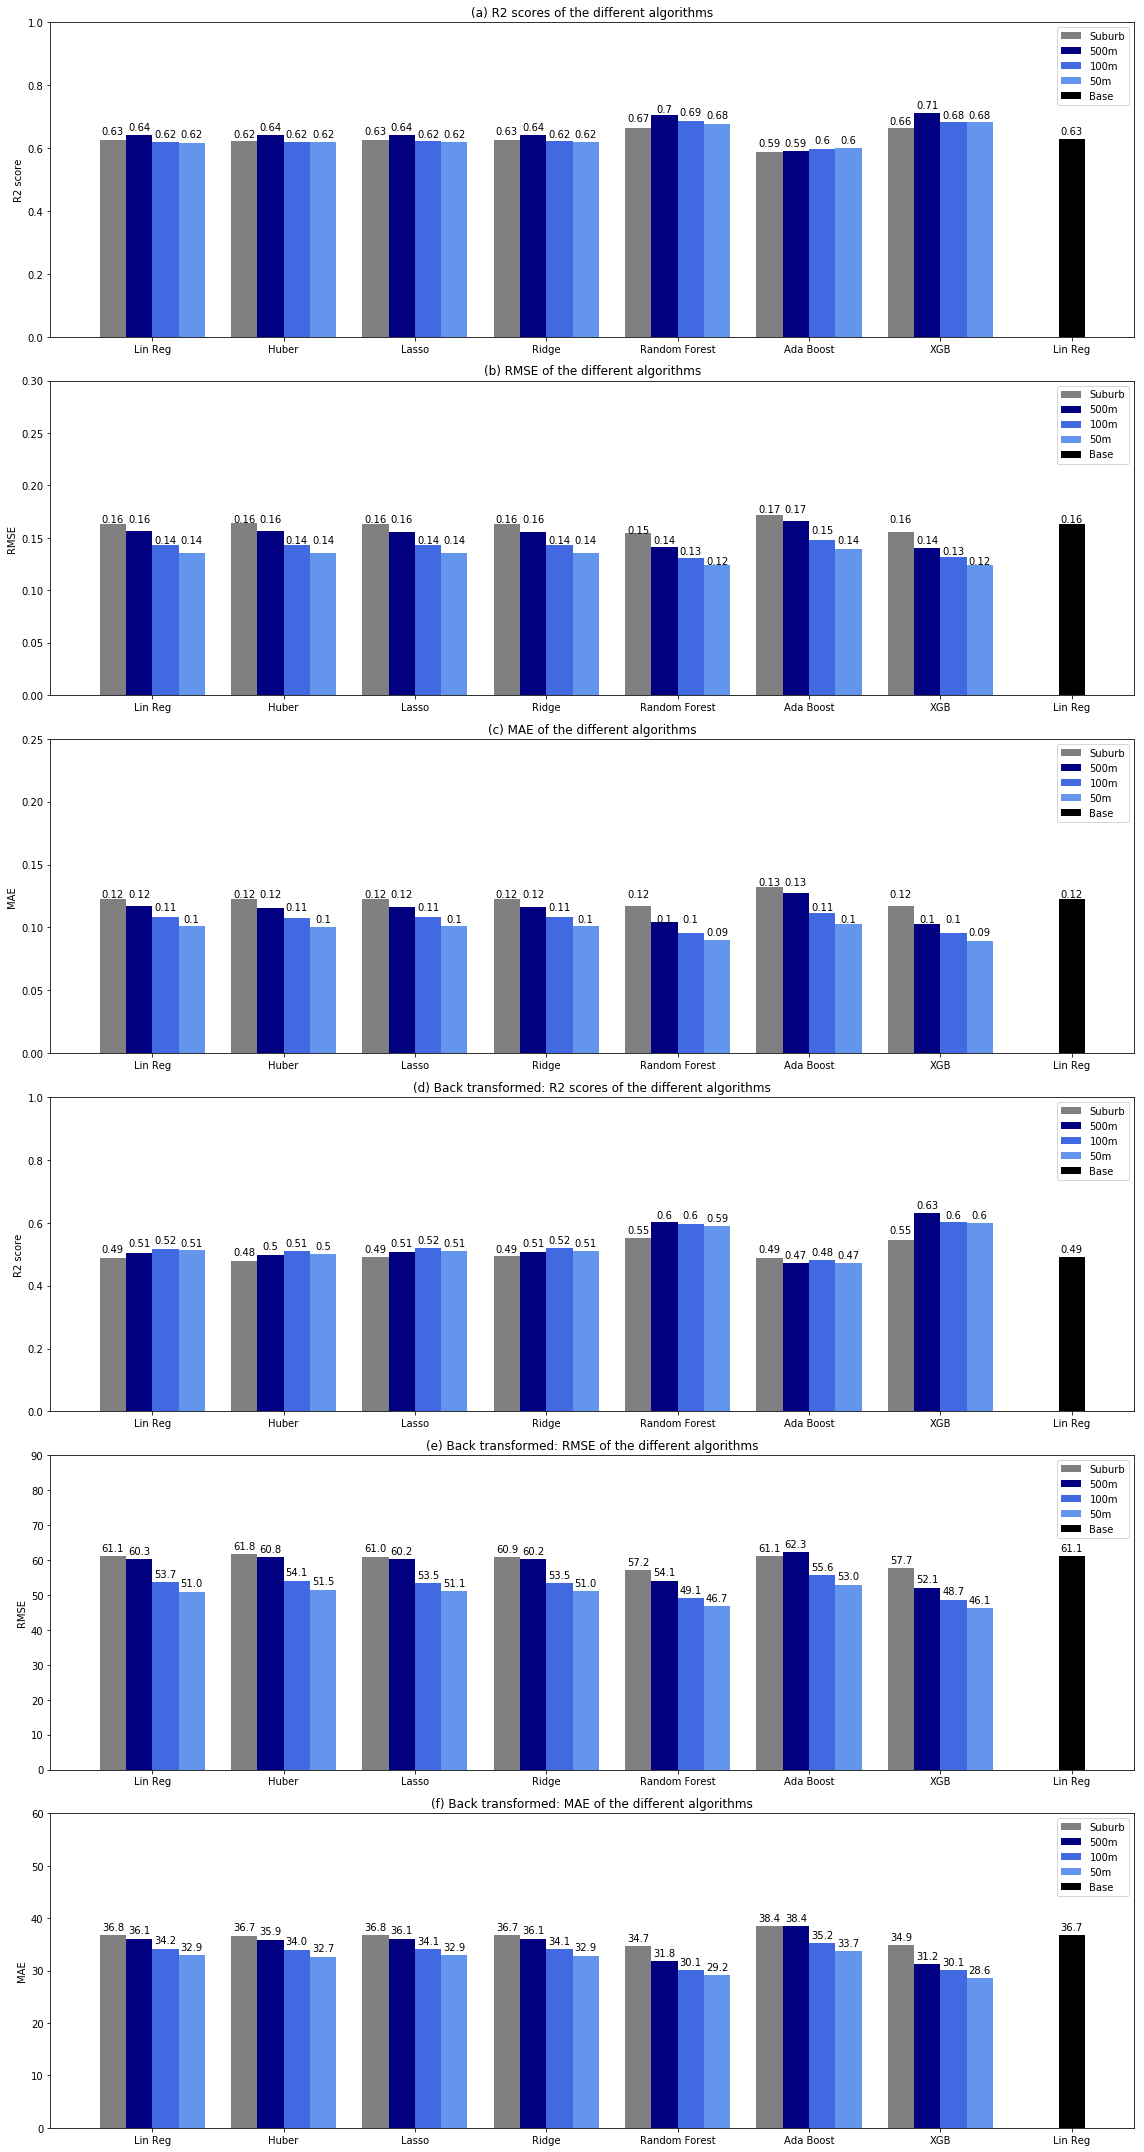

In [397]:
# Source: https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

#base['test_r2']

c1 = 'gray'
c2 = 'navy'
c3 = 'royalblue'
c4 = 'cornflowerblue'

# TRANSFORMED
#############

# R2 score
# --------
r2_suburb = [lin_reg_suburb['test_r2'], 
                huber_suburb['test_r2'],
                lasso_suburb['test_r2'],
                ridge_suburb['test_r2'],
                rf_suburb['test_r2'], 
                ada_suburb['test_r2'],
                xgb_suburb['test_r2']]

r2_500m = [lin_reg_500m['test_r2'],
              huber_500m['test_r2'],
              lasso_500m['test_r2'],
              ridge_500m['test_r2'],
              rf_500m['test_r2'],
              ada_500m['test_r2'],
              xgb_500m['test_r2']]

r2_100m = [lin_reg_100m['test_r2'],
              huber_100m['test_r2'],
              lasso_100m['test_r2'],
              ridge_100m['test_r2'],
              rf_100m['test_r2'],
              ada_100m['test_r2'],
              xgb_100m['test_r2']]

r2_50m = [lin_reg_50m['test_r2'],
              huber_50m['test_r2'],
              lasso_50m['test_r2'],
              ridge_50m['test_r2'],
              rf_50m['test_r2'],
              ada_50m['test_r2'],
              xgb_50m['test_r2']]

r2_base = base['test_r2']

# RMSE
# --------
rmse_suburb = [lin_reg_suburb['test_rmse'], 
                huber_suburb['test_rmse'],
                lasso_suburb['test_rmse'],
                ridge_suburb['test_rmse'],
                rf_suburb['test_rmse'], 
                ada_suburb['test_rmse'],
                xgb_suburb['test_rmse']]

rmse_500m = [lin_reg_500m['test_rmse'],
              huber_500m['test_rmse'],
              lasso_500m['test_rmse'],
              ridge_500m['test_rmse'],
              rf_500m['test_rmse'],
              ada_500m['test_rmse'],
              xgb_500m['test_rmse']]

rmse_100m = [lin_reg_100m['test_rmse'],
              huber_100m['test_rmse'],
              lasso_100m['test_rmse'],
              ridge_100m['test_rmse'],
              rf_100m['test_rmse'],
              ada_100m['test_rmse'],
              xgb_100m['test_rmse']]

rmse_50m = [lin_reg_50m['test_rmse'],
              huber_50m['test_rmse'],
              lasso_50m['test_rmse'],
              ridge_50m['test_rmse'],
              rf_50m['test_rmse'],
              ada_50m['test_rmse'],
              xgb_50m['test_rmse']]

rmse_base = base['test_rmse']

# MAE score
# --------
mae_suburb = [lin_reg_suburb['test_mae'], 
                huber_suburb['test_mae'],
                lasso_suburb['test_mae'],
                ridge_suburb['test_mae'],
                rf_suburb['test_mae'], 
                ada_suburb['test_mae'],
                xgb_suburb['test_mae']]

mae_500m = [lin_reg_500m['test_mae'],
              huber_500m['test_mae'],
              lasso_500m['test_mae'],
              ridge_500m['test_mae'],
              rf_500m['test_mae'],
              ada_500m['test_mae'],
              xgb_500m['test_mae']]

mae_100m = [lin_reg_100m['test_mae'],
              huber_100m['test_mae'],
              lasso_100m['test_mae'],
              ridge_100m['test_mae'],
              rf_100m['test_mae'],
              ada_100m['test_mae'],
              xgb_100m['test_mae']]

mae_50m = [lin_reg_50m['test_mae'],
              huber_50m['test_mae'],
              lasso_50m['test_mae'],
              ridge_50m['test_mae'],
              rf_50m['test_mae'],
              ada_50m['test_mae'],
              xgb_50m['test_mae']]

mae_base = base['test_mae']

# BACK TRANSFORMED
####################

# R2 score
# --------
r2_suburb_back = [lin_reg_suburb['test_r2_transformed'], 
                huber_suburb['test_r2_transformed'],
                lasso_suburb['test_r2_transformed'],
                ridge_suburb['test_r2_transformed'],
                rf_suburb['test_r2_transformed'], 
                ada_suburb['test_r2_transformed'],
                xgb_suburb['test_r2_transformed']]

r2_500m_back = [lin_reg_500m['test_r2_transformed'],
              huber_500m['test_r2_transformed'],
              lasso_500m['test_r2_transformed'],
              ridge_500m['test_r2_transformed'],
              rf_500m['test_r2_transformed'],
              ada_500m['test_r2_transformed'],
              xgb_500m['test_r2_transformed']]

r2_100m_back = [lin_reg_100m['test_r2_transformed'],
              huber_100m['test_r2_transformed'],
              lasso_100m['test_r2_transformed'],
              ridge_100m['test_r2_transformed'],
              rf_100m['test_r2_transformed'],
              ada_100m['test_r2_transformed'],
              xgb_100m['test_r2_transformed']]

r2_50m_back = [lin_reg_50m['test_r2_transformed'],
              huber_50m['test_r2_transformed'],
              lasso_50m['test_r2_transformed'],
              ridge_50m['test_r2_transformed'],
              rf_50m['test_r2_transformed'],
              ada_50m['test_r2_transformed'],
              xgb_50m['test_r2_transformed']]

r2_base_back = base['test_r2_transformed']

# RMSE
# --------
rmse_suburb_back = [lin_reg_suburb['test_rmse_transformed'], 
                huber_suburb['test_rmse_transformed'],
                lasso_suburb['test_rmse_transformed'],
                ridge_suburb['test_rmse_transformed'],
                rf_suburb['test_rmse_transformed'], 
                ada_suburb['test_rmse_transformed'],
                xgb_suburb['test_rmse_transformed']]

rmse_500m_back = [lin_reg_500m['test_rmse_transformed'],
              huber_500m['test_rmse_transformed'],
              lasso_500m['test_rmse_transformed'],
              ridge_500m['test_rmse_transformed'],
              rf_500m['test_rmse_transformed'],
              ada_500m['test_rmse_transformed'],
              xgb_500m['test_rmse_transformed']]

rmse_100m_back = [lin_reg_100m['test_rmse_transformed'],
              huber_100m['test_rmse_transformed'],
              lasso_100m['test_rmse_transformed'],
              ridge_100m['test_rmse_transformed'],
              rf_100m['test_rmse_transformed'],
              ada_100m['test_rmse_transformed'],
              xgb_100m['test_rmse_transformed']]

rmse_50m_back = [lin_reg_50m['test_rmse_transformed'],
              huber_50m['test_rmse_transformed'],
              lasso_50m['test_rmse_transformed'],
              ridge_50m['test_rmse_transformed'],
              rf_50m['test_rmse_transformed'],
              ada_50m['test_rmse_transformed'],
              xgb_50m['test_rmse_transformed']]

rmse_base_back = base['test_rmse_transformed']

# MAE score
# --------
mae_suburb_back = [lin_reg_suburb['test_mae_transformed'], 
                huber_suburb['test_mae_transformed'],
                lasso_suburb['test_mae_transformed'],
                ridge_suburb['test_mae_transformed'],
                rf_suburb['test_mae_transformed'], 
                ada_suburb['test_mae_transformed'],
                xgb_suburb['test_mae_transformed']]

mae_500m_back = [lin_reg_500m['test_mae_transformed'],
              huber_500m['test_mae_transformed'],
              lasso_500m['test_mae_transformed'],
              ridge_500m['test_mae_transformed'],
              rf_500m['test_mae_transformed'],
              ada_500m['test_mae_transformed'],
              xgb_500m['test_mae_transformed']]

mae_100m_back = [lin_reg_100m['test_mae_transformed'],
              huber_100m['test_mae_transformed'],
              lasso_100m['test_mae_transformed'],
              ridge_100m['test_mae_transformed'],
              rf_100m['test_mae_transformed'],
              ada_100m['test_mae_transformed'],
              xgb_100m['test_mae_transformed']]

mae_50m_back = [lin_reg_50m['test_mae_transformed'],
              huber_50m['test_mae_transformed'],
              lasso_50m['test_mae_transformed'],
              ridge_50m['test_mae_transformed'],
              rf_50m['test_mae_transformed'],
              ada_50m['test_mae_transformed'],
              xgb_50m['test_mae_transformed']]

mae_base_back = base['test_mae_transformed']


labels = ['Lin Reg', 'Huber', 'Lasso', 'Ridge', 'Random Forest',
         'Ada Boost', 'XGB']

factor = 2
x = np.arange(len(labels))*factor  # the label locations
x_add = len(labels)*factor
width = 0.40  # the width of the bars

fig, ax = plt.subplots(6,1, figsize=(16, 30))

# Transformed
#############

# R2 score
# --------
rects_r2_1 = ax[0].bar(x - 1.5*width, r2_suburb, width, label='Suburb', color=c1)
rects_r2_2 = ax[0].bar(x - 0.5*width, r2_500m, width, label='500m', color=c2)
rects_r2_3 = ax[0].bar(x + 0.5*width, r2_100m, width, label='100m', color=c3)
rects_r2_4 = ax[0].bar(x + 1.5*width, r2_50m, width, label='50m', color=c4)
rect_r2_base = ax[0].bar(x_add, r2_base, width, label='Base', color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('R2 score')
ax[0].set_title('(a) R2 scores of the different algorithms')
ax[0].set_xticks(np.append(x, x_add))
ax[0].set_xticklabels(labels + ['Lin Reg'])
ax[0].legend()
ax[0].set_ylim([0.0,1])

# RMSE
# ----
rects_rmse_1 = ax[1].bar(x - 1.5*width, rmse_suburb, width, label='Suburb', color=c1)
rects_rmse_2 = ax[1].bar(x - 0.5*width, rmse_500m, width, label='500m', color=c2)
rects_rmse_3 = ax[1].bar(x + 0.5*width, rmse_100m, width, label='100m', color=c3)
rects_rmse_4 = ax[1].bar(x + 1.5*width, rmse_50m, width, label='50m', color=c4)
rect_rmse_base = ax[1].bar(x_add, rmse_base, width, label='Base', color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1].set_ylabel('RMSE')
ax[1].set_title('(b) RMSE of the different algorithms')
ax[1].set_xticks(np.append(x, x_add))
ax[1].set_xticklabels(labels + ['Lin Reg'])
ax[1].legend()
ax[1].set_ylim([0.0,0.3])

# MAE
# ---
rects_mae_1 = ax[2].bar(x - 1.5*width, mae_suburb, width, label='Suburb', color=c1)
rects_mae_2 = ax[2].bar(x - 0.5*width, mae_500m, width, label='500m', color=c2)
rects_mae_3 = ax[2].bar(x + 0.5*width, mae_100m, width, label='100m', color=c3)
rects_mae_4 = ax[2].bar(x + 1.5*width, mae_50m, width, label='50m', color=c4)
rect_mae_base = ax[2].bar(x_add, mae_base, width, label='Base', color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[2].set_ylabel('MAE')
ax[2].set_title('(c) MAE of the different algorithms')
ax[2].set_xticks(np.append(x, x_add))
ax[2].set_xticklabels(labels + ['Lin Reg'])
ax[2].legend()
ax[2].set_ylim([0.0,0.25])


# Back transformed
##################

# R2 score
# --------
rects_r2_1_back = ax[3].bar(x - 1.5*width, r2_suburb_back, width, label='Suburb', color=c1)
rects_r2_2_back = ax[3].bar(x - 0.5*width, r2_500m_back, width, label='500m', color=c2)
rects_r2_3_back = ax[3].bar(x + 0.5*width, r2_100m_back, width, label='100m', color=c3)
rects_r2_4_back = ax[3].bar(x + 1.5*width, r2_50m_back, width, label='50m', color=c4)
rect_r2_base_back = ax[3].bar(x_add, r2_base_back, width, label='Base', color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[3].set_ylabel('R2 score')
ax[3].set_title('(d) Back transformed: R2 scores of the different algorithms')
ax[3].set_xticks(np.append(x, x_add))
ax[3].set_xticklabels(labels + ['Lin Reg'])
ax[3].legend()
ax[3].set_ylim([0.0,1])

# RMSE
# ----
rects_rmse_1_back = ax[4].bar(x - 1.5*width, rmse_suburb_back, width, label='Suburb', color=c1)
rects_rmse_2_back = ax[4].bar(x - 0.5*width, rmse_500m_back, width, label='500m', color=c2)
rects_rmse_3_back = ax[4].bar(x + 0.5*width, rmse_100m_back, width, label='100m', color=c3)
rects_rmse_4_back = ax[4].bar(x + 1.5*width, rmse_50m_back, width, label='50m', color=c4)
rect_rmse_base_back = ax[4].bar(x_add, rmse_base_back, width, label='Base', color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[4].set_ylabel('RMSE')
ax[4].set_title('(e) Back transformed: RMSE of the different algorithms')
ax[4].set_xticks(np.append(x, x_add))
ax[4].set_xticklabels(labels + ['Lin Reg'])
ax[4].legend()
ax[4].set_ylim([0.0,90])

# MAE
# ---
rects_mae_1_back = ax[5].bar(x - 1.5*width, mae_suburb_back, width, label='Suburb', color=c1)
rects_mae_2_back = ax[5].bar(x - 0.5*width, mae_500m_back, width, label='500m', color=c2)
rects_mae_3_back = ax[5].bar(x + 0.5*width, mae_100m_back, width, label='100m', color=c3)
rects_mae_4_back = ax[5].bar(x + 1.5*width, mae_50m_back, width, label='50m', color=c4)
rect_mae_base_back = ax[5].bar(x_add, mae_base_back, width, label='Base', color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[5].set_ylabel('MAE')
ax[5].set_title('(f) Back transformed: MAE of the different algorithms')
ax[5].set_xticks(np.append(x, x_add))
ax[5].set_xticklabels(labels + ['Lin Reg'])
ax[5].legend()
ax[5].set_ylim([0.0,60])


def autolabel(rects, pos):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        if pos in [0,1,2,3]:
            height = np.round(rect.get_height(),2)
        else:
            height = np.round(rect.get_height(),1)
        ax[pos].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# Transformed
autolabel(rects_r2_1, 0)
autolabel(rects_r2_2, 0)
autolabel(rects_r2_3, 0)
autolabel(rects_r2_4, 0)
autolabel(rect_r2_base, 0)

autolabel(rects_rmse_1, 1)
autolabel(rects_rmse_2, 1)
autolabel(rects_rmse_3, 1)
autolabel(rects_rmse_4, 1)
autolabel(rect_rmse_base, 1)

autolabel(rects_mae_1, 2)
autolabel(rects_mae_2, 2)
autolabel(rects_mae_3, 2)
autolabel(rects_mae_4, 2)
autolabel(rect_mae_base, 2)

# Back transformed
autolabel(rects_r2_1_back, 3)
autolabel(rects_r2_2_back, 3)
autolabel(rects_r2_3_back, 3)
autolabel(rects_r2_4_back, 3)
autolabel(rect_r2_base_back, 3)

autolabel(rects_rmse_1_back, 4)
autolabel(rects_rmse_2_back, 4)
autolabel(rects_rmse_3_back, 4)
autolabel(rects_rmse_4_back, 4)
autolabel(rect_rmse_base_back, 4)

autolabel(rects_mae_1_back, 5)
autolabel(rects_mae_2_back, 5)
autolabel(rects_mae_3_back, 5)
autolabel(rects_mae_4_back, 5)
autolabel(rect_mae_base_back, 5)

fig.tight_layout()

plt.show()